## Imports
These are the set of packages that are required to run this script. Before running the script make sure that you have clone the repo (https://github.com/BonsaiNet/Staining-methods-and-morphologies).

In [1]:
import sys
path_to_McNeuron = "/path/to/McNeuron"
sys.path.append(path_to_McNeuron)
import numpy as np
import McNeuron
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy
from numpy.linalg import inv
from collections import Counter
import pickle
import pandas as pd
import operator
from scipy.stats import ks_2samp
from scipy import stats
from operator import itemgetter
from scipy.sparse import csr_matrix
from sklearn import preprocessing

## Downloading the data from neuromorpho.org
First, we should download the data of the morphology. Thanks to neuromorpho.org, we can access to the morphology of more than 100,000 neurons (based on the version 7.6). Since the data is big and to avoid any connection intruption in downloading, here we first download the data in small chunks and then retrive the whole data.

In [ ]:
# First dump the downloaded data in a folder:
path='/data/roozbeh_arch/All_Data/'
McNeuron.data_util.step_save_downloading(path=path,
                                         saving_neurons=5000,
                                         n_total_neurons=110000)
# Then retrive the whole data:
neurons_v76 = McNeuron.data_util.retrive_make_one_file(saving_neurons = 5000, 
                                                       n_total_neurons = 110000,
                                                       dump_data_path=path,
                                                       name_file = 'neurons_v76')
# and finally clean the data by removing irrelavant labels
neurons_v76 = McNeuron.data_util.clean_data(neuron_data = neurons_v76)

### Utilities to condition on the labels
In order to select the comparison groups from the data we need additional matices that we  generate here:

In [ ]:
labels = list(neurons_v76.keys())
labels_encoder, attribute_mat = McNeuron.data_util.selection_util(neurons=neurons_v76,
                                                        labels=labels)

## Finding Matching groups
We compare the extracted morphology of neurons collected from the same rodent species, experimental condition, gender distribution, age distribution, brain region and putative cell type, but obtained with distinct staining methods. In order to find this group, we  should be able to condition the whole data on labels. Here, we first give an example that how this conditioning can be done and then find all the matching groups.

The first jupyter cell shows how we can condition a group. For example, we want to find neurons that their 'Physical Integrity' is lableded as 'Dendrites & Axon Complete' or 'Dendrites Complete' and moreover their Species are rats. However, we want to exclude the 'young' age class from the group. We can then write:

In [3]:
labels_values = [{'Physical Integrity':['Dendrites & Axon Complete',
                                         'Dendrites Complete']},
                 {'Species Name':['rat']}]

not_labels_values = [ 
     {'age_classification':['young']},
               ]
group = McNeuron.data_util.get_neurons_with_given_values(neurons=neurons_v76,
    attribute_mat=attribute_mat,
    labels_encoder=labels_encoder,
    labels_values=labels_values,
    not_labels_values=not_labels_values)

We can see how many different staining methods are in this group:

In [4]:
McNeuron.data_util.count_label(group, label_name='stain')

[('enhanced green fluorescent protein', 5491),
 ('lucifer yellow', 535),
 ('biocytin', 295),
 ('green fluorescent protein, Alexa Fluor 488, immunostaining', 240),
 ('Golgi-Cox', 157),
 ('immunostaining', 81),
 ('green fluorescent protein', 58),
 ('neurobiotin', 46),
 ('horseradish peroxidase', 45),
 ('yellow fluorescent protein', 21),
 ('biotinylated dextran amine', 19),
 ('Alexa Fluor 594', 8),
 ('Sindbis palGFP virus', 3),
 ('Alexa Fluor 594 hydrazide', 2),
 ('Golgi', 2),
 ('Alexa Fluor 555', 1),
 ('Not reported', 1)]

Then, we follow the paper, and do the conditionig on all biological attributes. Here is the details

In [5]:
# The labels that should be satisfied by all of the matching groups
global_labels = [ {'Physical Integrity':[
             'Dendrites & Axon Complete',
             'Dendrites & Axon Moderate',
             'Dendrites Complete',
             'Dendrites Complete, Axon Incomplete',
             'Dendrites Complete, Axon Moderate',
             'Dendrites Moderate',
             'Dendrites Moderate, Axon Complete',
             'Dendrites Moderate, Axon Incomplete',
             'Neurites Complete',
             'Neurites Moderate',
             'Processes Moderate']},
     {'experiment_condition':['Control']},
      {'gender':['Male', 'Female', 'Male/Female']},
 {'age_classification': ['adult',
                         'young',
                         'young adult',
                         'neonatal',
                         'embryonic',
                         'old',
                         'fetus']},
     {'Species Name':['rat', 'mouse']},
                ]
# The labels to find the brain regions of the rodents (primary brain regions)
regions = [
    ['somatosensory', 'primary somatosensory', 'barrel'],
    ['primary visual'],
    ['motor', 'secondary motor', 'primary motor'],
    ['CA1'],
    ['CA3'],
    ['dentate gyrus'],
    ['amygdala'],
    ['brainstem'],
    ['striatum', 'ventral striatum'],
    ['main olfactory bulb'],
    ['retina'],
    ['spinal cord'],
    ['anterior cingulate'],
    ['prelimbic'],
    ['dorsal thalamus', 'ventral thalamus', 'thalamus'],
    ['hypothalamus'],
    ['cerebellum'],
    ['entorhinal cortex'],
]

# The labels to condition on 
conditions = [{'brain_region' : [
    ['layer 1'],
    ['layer 2', 'L2', 'L2i','L2o'],
    ['layer 2-3'],
    ['layer 3', 'L3'],
    ['layer 3-4'],
    ['layer 4'],
    ['layer 5', 'L5', 'L5-S1', 'layer 5a', 'layer 5b'],
    ['layer 5-6', 'L5-L6'],
    ['layer 6', 'layer 6a', 'layer 6b'],
]},
{'brain_region' : [
    ['right'],
    ['left']
]},
{'brain_region' : [
    ['ventral'],
    ['dorsal']
]},
              
{'brain_region' : [
    ['occipital'],
    ['medial prefrontal', 'medial'],
    ['frontal', 'prefrontal']
]},
{'brain_region' : [
    ['stratum pyramidale'],
    ['stratum oriens'],
    ['stratum radiatum'],
]},
{'brain_region' : [
    ['mitral layer'],
    ['inner plexiform layer'],
    ['external plexiform layer']    
]},
{'brain_region' : [
    ['pedunculopontine nucleus'],   
]},
{'gender':[['Male'], ['Female'], ['Male/Female']]},
{'age_classification': [['adult'],
                        ['young'],
                        ['young adult'],
                        ['neonatal'],
                        ['embryonic'],
                        ['old'],
                        ['fetus']]}, 

{'cell_type':[['principal cell'], ['interneuron']]},
{'cell_type':[['complex'], ['simple']]},
{'cell_type':[['Aspiny'], ['Spiny']]},
{'cell_type':[['granule'], ['basket']]},
{'Species Name':[['rat'], ['mouse']]},
{'cell_type':[['adult-born'], ['newborn']]},
             ] 

minimums = [{'stain':[2,5]}]

# we do the analysis for version 7.4 of neuromorpho.org
cut_for_v74 = 80900

attribute_mat_neurons_v74 = attribute_mat[:cut_for_v74,:]
neurons_v74 = neurons_v76.iloc[:cut_for_v74,:]

all_groups, groups_label, groups_not_label = \
     McNeuron.data_util.comparing_groups(neurons=neurons_v74,
                                         regions=regions,
                                         minimums = minimums,
                                         conditions=conditions,
                                         global_labels=global_labels,
                                         attribute_mat=attribute_mat_neurons_v74, 
                                         labels_encoder=labels_encoder)

print('There are ' + str(len(all_groups))+' comparison groups.')

There are 22 comparison groups.


## Table 1 & 2
By running above code, 22 match groups will be found. We name these groups as following:

In [6]:
group_names = ['Somatasensory, Layer 2-3, adult, male mice',
               'Somatasensory, Layer 2-3, young, mixed gender rats',
               'Somatasensory, Layer 5, adult, male rats',
               'Somatasensory, Layer 5, young adult, male rats',               
               'Primary Visual, Layer 2-3, adult, mixed gender mice',
               'CA1, adult, male rats',
               'CA1, young, male rats',              
               'CA1, young, male mice',              
               'CA1, adult, mixed gender mice',
               'CA1, young, mixed gender rats',               
               'CA1, young, mixed gender mice',
               'Dentate gyrus, granule layer, adult-born, adult, male rats',
               'Dentate gyrus, granule layer, adult, male rats',
               'Dentate gyrus, granule layer, new-born, adult, male mice',
               'Dentate gyrus, granule layer, adult, male mice',
               'amygdala, adult, male rats',            
               'Striatum, basal ganglia, medium spiny, adult, male mice',
               'Main Olfactory bulb, mitral layer, young adult, mixed gender  mice',
               'Main Olfactory bulb, granule layer, adult, female mice',
               'Main Olfactory bulb, granule layer, young adult, mixed gender mice',
               'Retina, ganglion layer, adult, mixed gender mice',
               'prelimbic, layer 2-3, adult, male rats']

To see the list of keys in each matching group, we can write:

In [7]:
for i in range(len(groups_label)):
    print(str(i+1) +" - Group Name: "+group_names[i])
    print("Cell-type distribution in this group is: ")
    print(McNeuron.data_util.count_label(neurons_v74.iloc[all_groups[i]],
                                   label_name='cell_type'))
    print("Brain-region distribution in this group is: ")
    print(McNeuron.data_util.count_label(neurons_v74.iloc[all_groups[i]],
                                   label_name='brain_region'))
    print("Gender distribution in this group is: ")
    print(McNeuron.data_util.count_label(neurons_v74.iloc[all_groups[i]],
                                   label_name='gender'))
    print("Age distribution in this group is: ")
    print(McNeuron.data_util.count_label(neurons_v74.iloc[all_groups[i]],
                                   label_name='age_classification'))
    print("Specie in this group is: ")
    print(McNeuron.data_util.count_label(neurons_v74.iloc[all_groups[i]],
                                   label_name='Species Name'))
    print('\n')

1 - Group Name: Somatasensory, Layer 2-3, adult, male mice
Cell-type distribution in this group is: 
[(('principal cell', 'pyramidal'), 67)]
Brain-region distribution in this group is: 
[(('layer 2-3', 'neocortex', 'somatosensory'), 30), (('layer 2-3', 'neocortex', 'secondary somatosensory cortex', 'somatosensory'), 30), (('barrel', 'layer 2-3', 'neocortex', 'somatosensory'), 7)]
Gender distribution in this group is: 
[('Male', 67)]
Age distribution in this group is: 
[('adult', 67)]
Specie in this group is: 
[('mouse', 67)]


2 - Group Name: Somatasensory, Layer 2-3, young, mixed gender rats
Cell-type distribution in this group is: 
[(('principal cell', 'pyramidal'), 29)]
Brain-region distribution in this group is: 
[(('layer 2-3', 'neocortex', 'primary somatosensory', 'somatosensory'), 19), (('barrel', 'layer 2-3', 'neocortex', 'somatosensory'), 10)]
Gender distribution in this group is: 
[('Male/Female', 29)]
Age distribution in this group is: 
[('young', 29)]
Specie in this group i

### List of all staining methods in the matching groups
Now we ask what staining methods exist in the groups. Here is the list of all staining methods:

In [8]:
all_indcies = np.array([])
for i in all_groups:
    all_indcies = np.append(all_indcies, i)
all_indcies = all_indcies.astype(int)
staining = \
McNeuron.data_util.count_label(neurons=neurons_v74.iloc[all_indcies], 
                                label_name='stain')

list_all_staining = \
        [staining[i][0] for i in range(len(staining))]

list_all_staining

['immunostaining',
 'Golgi',
 'Golgi-Cox',
 'biocytin',
 'neurobiotin',
 'green fluorescent protein, Alexa Fluor 488, immunostaining',
 'green fluorescent protein',
 'lucifer yellow',
 'red fluorescent protein',
 'Biocytin & betaIV-spectrin',
 'enhanced green fluorescent protein',
 'horseradish peroxidase',
 'Not reported',
 'Tag red fluorescent protein',
 'biotinylated dextran amine',
 'green fluorescent protein, immunostaining',
 'Alexa 647-dextrane',
 'Alexa Fluor 488',
 'Alexa Fluor 594']

We rename the staining methods as below:

In [9]:
list_all_staining_refined = [
 'Golgi',
 'Golgi-Cox',


 'immunostaining',
 'horseradish peroxidase',
 'neurobiotin',
 'biocytin',
 'Biocytin & betaIV-spectrin',

 'Alexa Fluor 488',
 'Alexa 647-dextrane',
 'Alexa Fluor 594',
'OGB-1',
 'biotinylated dextran amine',
 'lucifer yellow',
 'green fluorescent protein, Alexa Fluor 488, immunostaining',
'green fluorescent protein, immunostaining',
    
 'Tag red fluorescent protein',
 'enhanced green fluorescent protein',
 'red fluorescent protein',
 'green fluorescent protein',

]


list_all_staining_refined_name = ['Golgi',
 'Golgi-Cox',
 'immunos',
 'horseradish',
 'neurobiotin',
 'biocytin',
 'biocytin & bIVs',
 'AF 488',
 'Alexa 647-dex',
 'AF 594',
 'OGB-1',
 'biotinylated dex a',
 'lucifer yellow',
 'GFP & AF 488',
 'GFP & immunos',
 'Tag RFP',
 'enhanced GFP',
 'RFP',
 'GFP']

### PubMed id of the papers for each matching group
In order to double chech the neurons in each matching group, we can extract the papers that the data is published

In [10]:
for i in range(len(all_groups)):
    pubmed_id_neurons = \
        np.array([int(i[0]) for i in neurons_v74.iloc[all_groups[0]]['reference_pmid']])
    print(str(i+1) +" - Group Name: "+ group_names[i])
    print('The list of pubmed id of the papers in the group is: ')
    print(np.unique(pubmed_id_neurons).astype(int))
    print('\n')

1 - Group Name: Somatasensory, Layer 2-3, adult, male mice
The list of pubmed id of the papers in the group is: 
[16195469 16781686 23509258]


2 - Group Name: Somatasensory, Layer 2-3, young, mixed gender rats
The list of pubmed id of the papers in the group is: 
[16195469 16781686 23509258]


3 - Group Name: Somatasensory, Layer 5, adult, male rats
The list of pubmed id of the papers in the group is: 
[16195469 16781686 23509258]


4 - Group Name: Somatasensory, Layer 5, young adult, male rats
The list of pubmed id of the papers in the group is: 
[16195469 16781686 23509258]


5 - Group Name: Primary Visual, Layer 2-3, adult, mixed gender mice
The list of pubmed id of the papers in the group is: 
[16195469 16781686 23509258]


6 - Group Name: CA1, adult, male rats
The list of pubmed id of the papers in the group is: 
[16195469 16781686 23509258]


7 - Group Name: CA1, young, male rats
The list of pubmed id of the papers in the group is: 
[16195469 16781686 23509258]


8 - Group Name:

## Figure 1: Plot a few samples for each group of the morphology
Here we plot a few samples of the neurons for each comparison group.

In [11]:
def plot_neurons_for_all_groups(neurons,
                                all_groups,
                                group_names,
                                length=5,
                                n_morph=5,
                                neuron_part='dendrite'):
    """
    Plot a few samples from each comparison groups. For each group, the samples
    are plotted for each avilable staining method.
    
    Parameters:
    -----------
    neurons: dataframe
        Rows are neurons and columns are metadata/features of samples, The 
        index of neuron in this data is the one in group_names.
        
    all_groups: list
        eah element of the list is the indices of the neurons in each group.
        
    group_names: list
        the list of group names (the name of groups are string).
        
    length: float
        the length of neuron to be subsamlple in order to be plotted.
        
    n_morph: int
        number of samples to be shown for each group.
    
    neuron_part: str
        it can be 'dendrite', 'axon' or 'all'.
        
    """
    vec_size = 0
    for i in range(len(all_groups)):
        morph_data = neurons.iloc[all_groups[i]]
        staining_list = list(set(list(morph_data['stain'])))
        vec_size += len(staining_list)
    vec_size+= len(all_groups)+1
    fig, axes = plt.subplots(vec_size, 
                            n_morph+1, figsize=(2*(n_morph+1), 
                                              2*vec_size)) 
    stack = 1
    for j in range(n_morph+1):
        axes[0, j].axis('off')
    for j in range(len(all_groups)):
        morph_data = neurons.iloc[all_groups[j]]
        staining_list = list(set(list(morph_data['stain'])))

        for n in range(len(staining_list)):
            index_archive = np.where(morph_data['stain'] == \
                             staining_list[n])[0]
            np.random.shuffle(index_archive)
            for i in range(min(n_morph, index_archive.shape[0])):
                swc_matrix = morph_data['swc'].iloc[index_archive[i]]
                swc_matrix = McNeuron.subsample.select_part_swc(swc_matrix,
                                                                   part=neuron_part)
                neuron = McNeuron.Neuron(swc_matrix)
                neuron = neuron.subsample('straigthen', length=length)
                McNeuron.visualize.plot_2D(neuron, 
                                           pass_ax=True,
                                           ax = axes[stack+n, i])
                
                plt.axis('off')
            axes[stack+n, n_morph].text(0.35, 0.5, staining_list[n], dict(size=15))
            axes[stack+n, n_morph].axis('off')
        axes[stack-1, 2].text(0.35, 0.5, 'Group '+str(j+1)+': '+group_names[j], dict(size=20))
        for k in range(n_morph+1):
            axes[stack+n+1, k].axis('off')
            
        stack += len(staining_list)+1

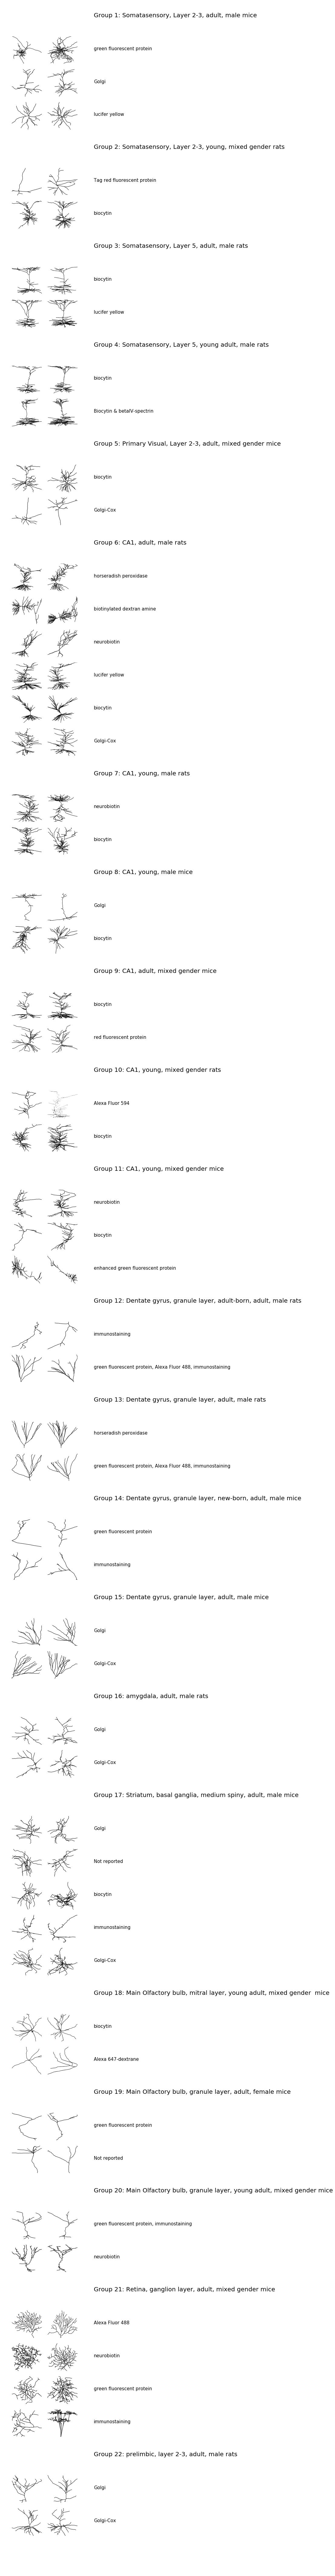

In [12]:
plot_neurons_for_all_groups(neurons=neurons_v76,
                            all_groups=all_groups,
                            group_names=group_names,
                            n_morph=2,
                            length=5,
                            neuron_part='dendrite')
#plt.savefig('samples_rat.eps')

### Extracting the features of the neurons
We then extract the morphological features of each neuron in the group. 

In [13]:
neuron_indices = np.array([])
for i in range(len(all_groups)):
    neuron_indices  = np.append(all_groups[i], neuron_indices)
neuron_indices = neuron_indices.astype(int)

def extract_feature(neuron_data, 
                    neuron_indices,
                    neuron_part='dendrite'):
    """
    This function returns the morphological features of the neurons.
    
    
    Parameters:
    -----------
    neuron_data
    
    neuron_indices
    
    neuron_part='dendrite'
        
    """    
    all_neuron = []
    for n in range(len(neuron_indices)):
        if np.mod(n, 100)==0:
                print(n)
        ind = neuron_indices[n]
        swc_matrix = neuron_data['swc'][ind]
        ## select the right neurons part
        neuron = McNeuron.subsample.select_part_swc(swc_matrix,
                                                         neuron_part)
        neuron = McNeuron.Neuron(neuron)
        neuron.geometrical_features()
        dic_all = {}
        dic_all['NeuroMorpho.Org ID'] = neuron_data['NeuroMorpho.Org ID'][ind]
        dic_all['Total Length (dendrite)'] =  sum(neuron.features['distance from parent'])
        dic_all['Number of branching (dendrite)'] = \
            len(neuron.features['segmental branch angle'])
        dic_all['global angle'] =  neuron.features['global angle']
        dic_all['local angle'] =  neuron.features['local angle']
        dic_all['segmental branch angle'] =  neuron.features['segmental branch angle']
        dic_all['segmental neural length'] =  neuron.features['segmental neural length']
        all_neuron.append(dic_all)
    features_neuron = pd.DataFrame(all_neuron)
    return features_neuron

features_neuron = extract_feature(neuron_data=neurons_v74, neuron_indices=neuron_indices)

0
100


/home/roozbeh/Morphology/McNeuron/McNeuron/Neuron.py:1314: RuntimeWarning: divide by zero encountered in true_divide
  self.features['path_length/euclidean'] = path_length[self.n_soma:]/distance_from_root[self.n_soma:]


200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600


In [14]:
neuron_with_features = pd.merge(neurons_v76,
                                features_neuron, 
                                on='NeuroMorpho.Org ID',
                                how='outer')

### Next we plot the histograms

/opt/anaconda/miniconda2/envs/py34/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/opt/anaconda/miniconda2/envs/py34/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/anaconda/miniconda2/envs/py34/lib/python3.6/site-packages/numpy/lib/histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


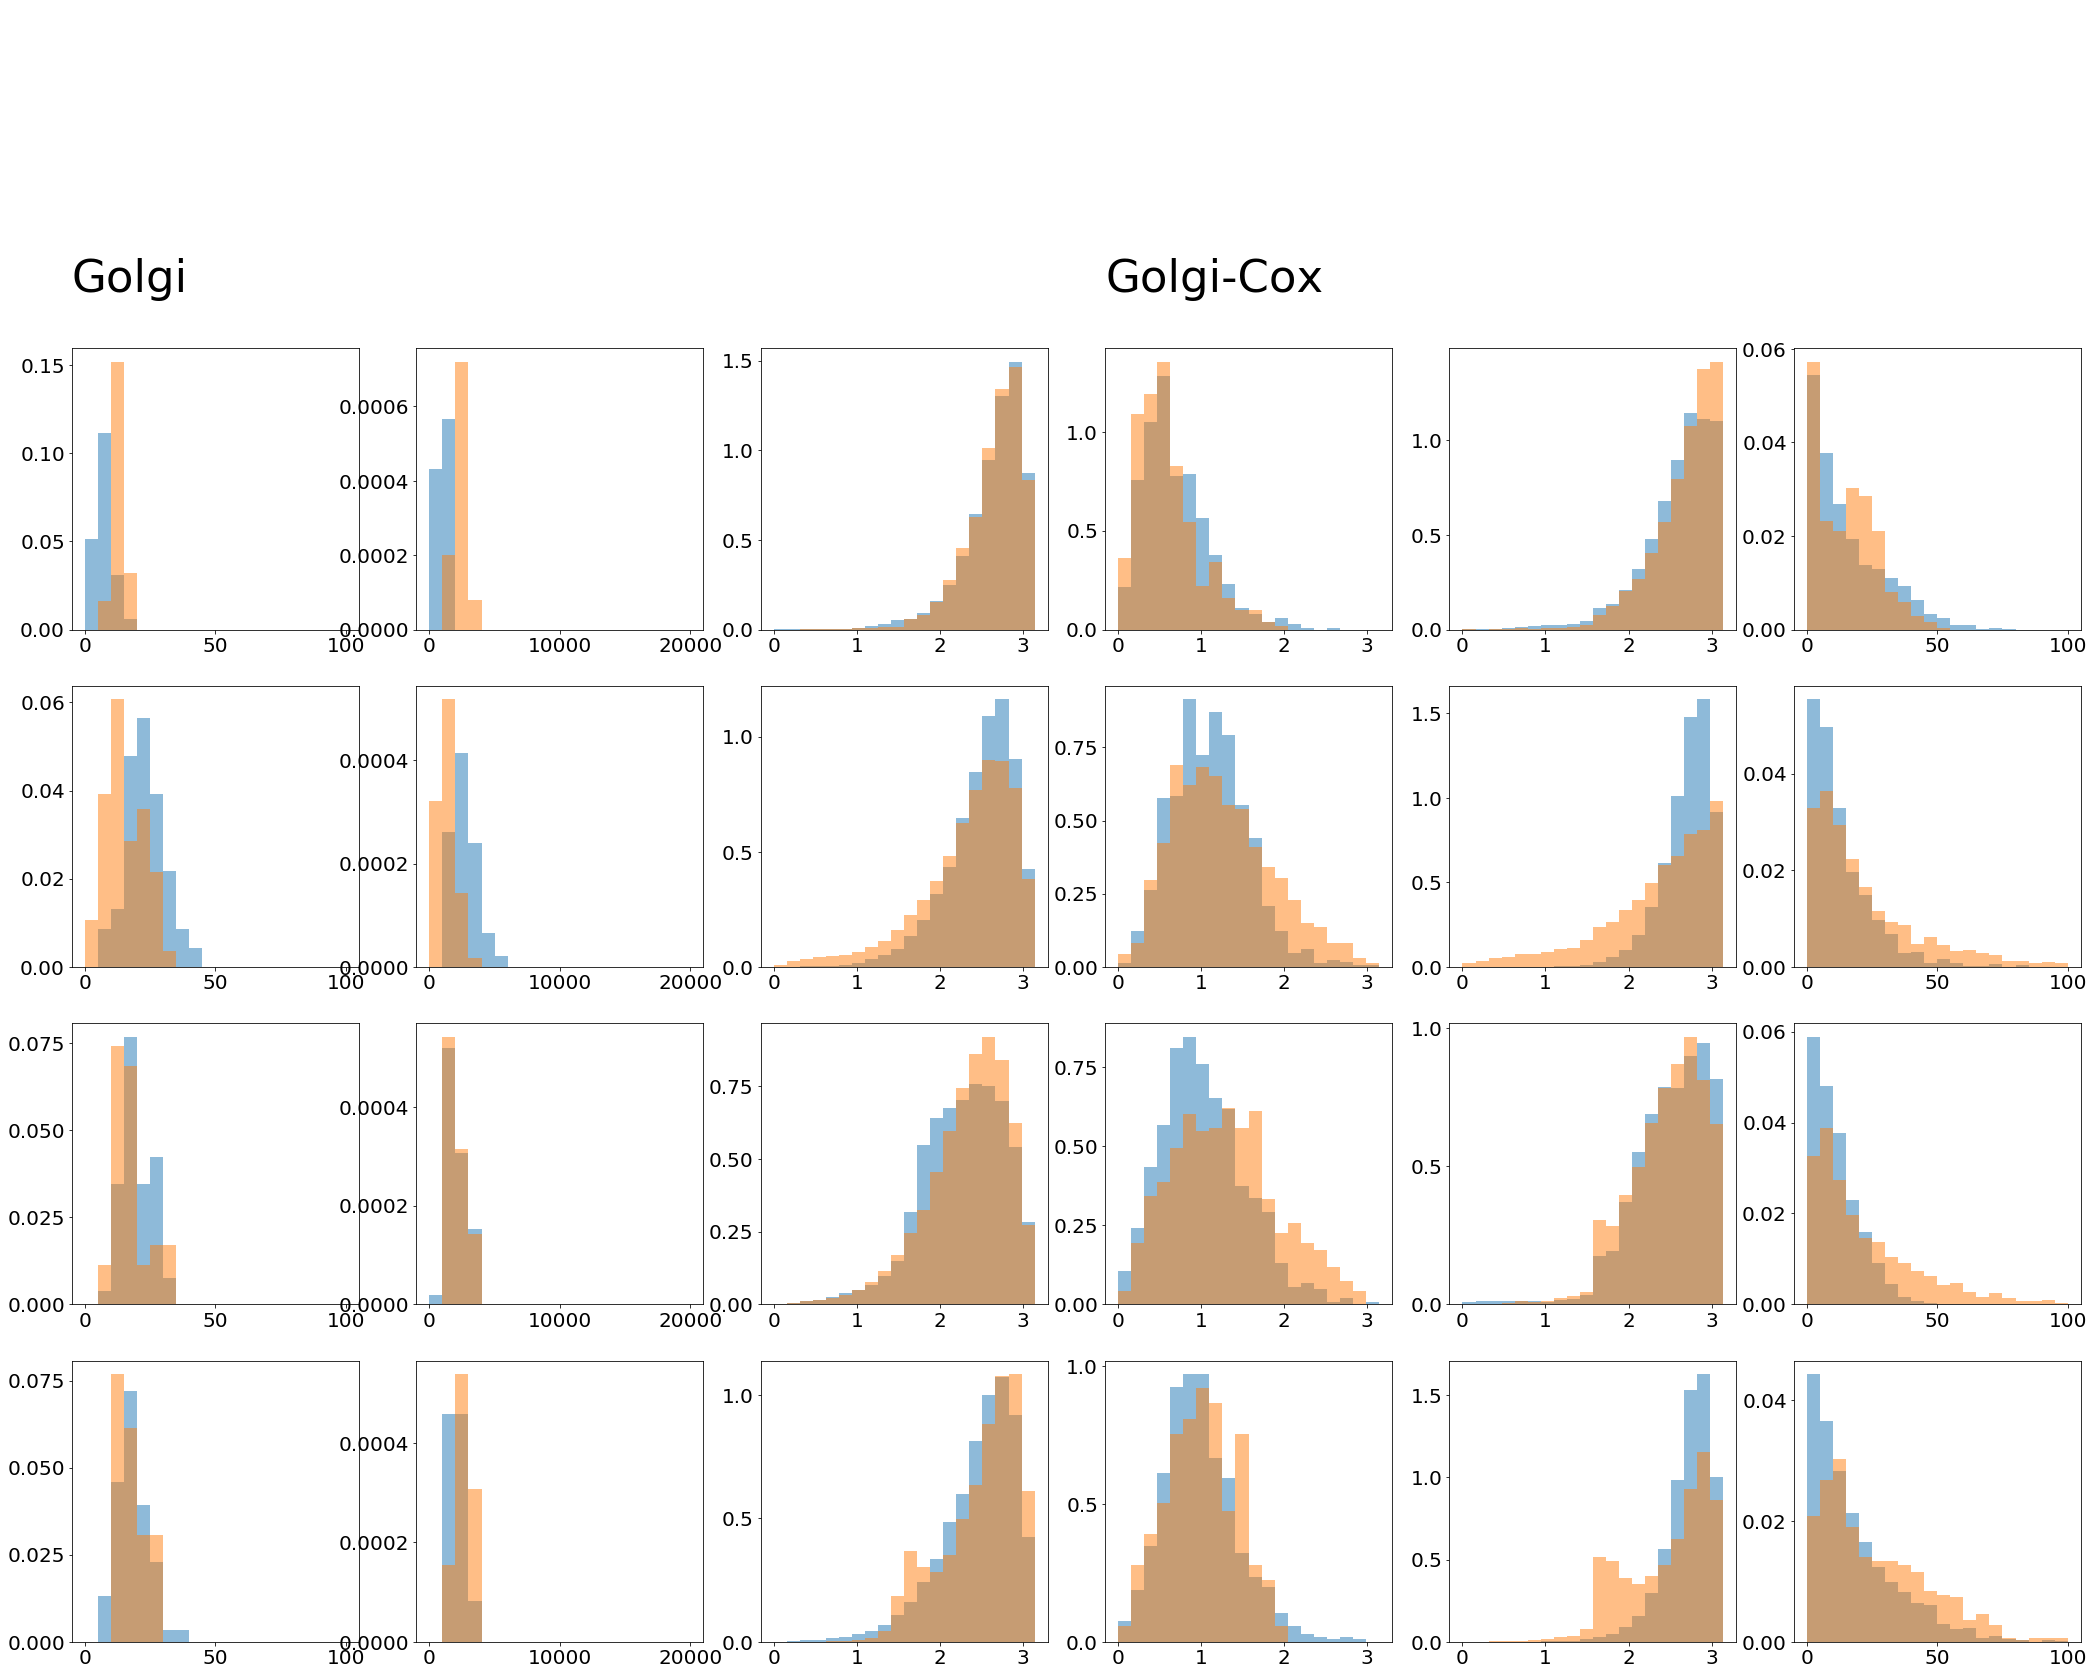

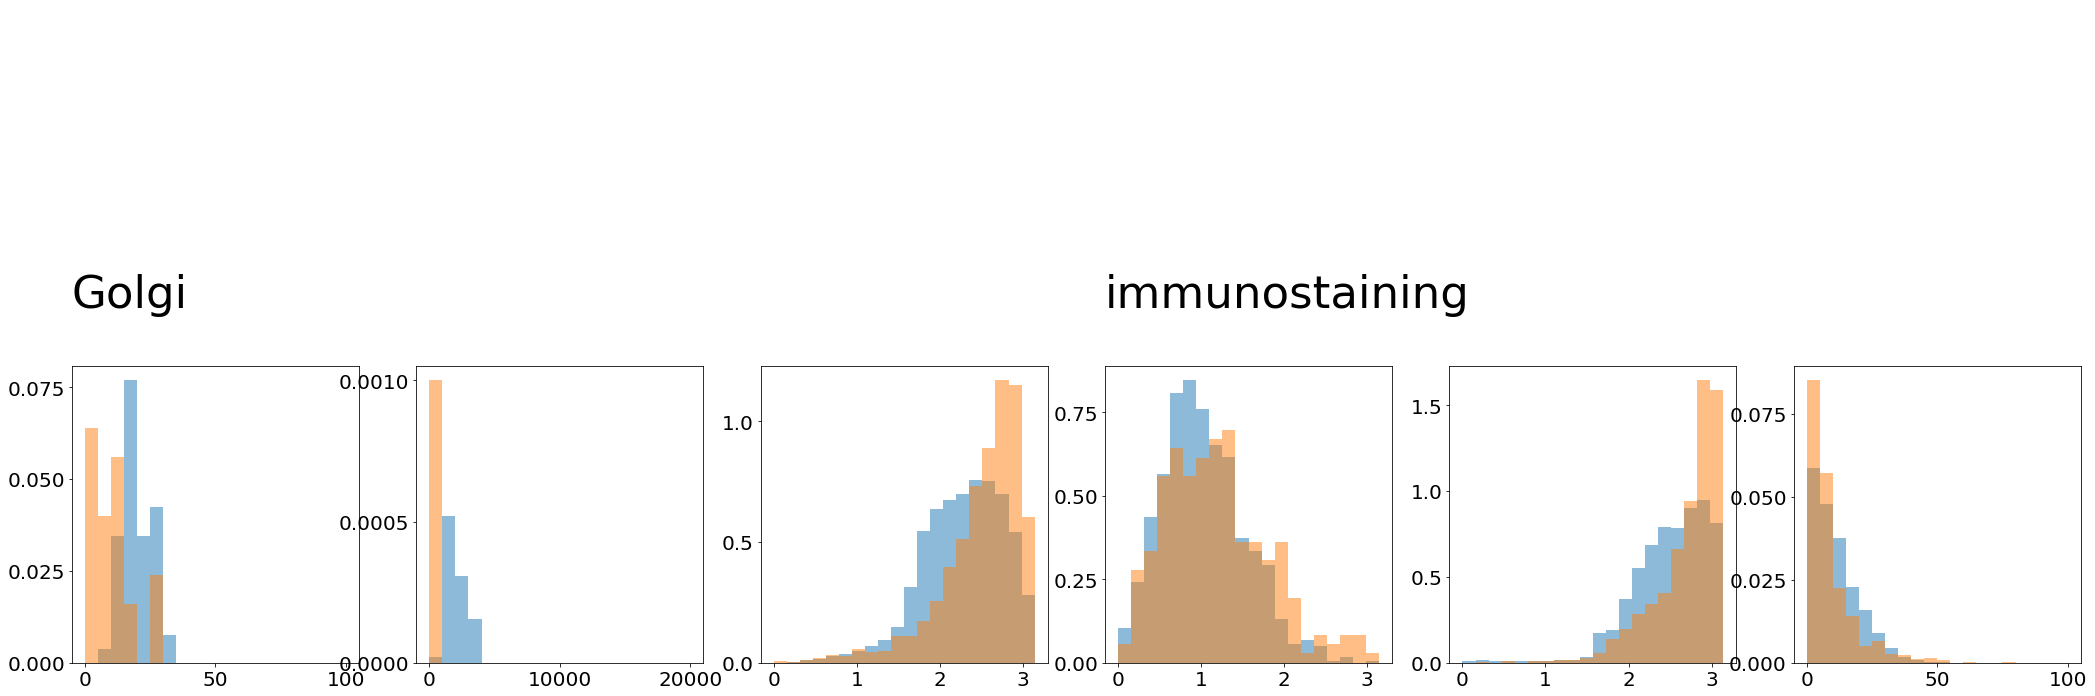

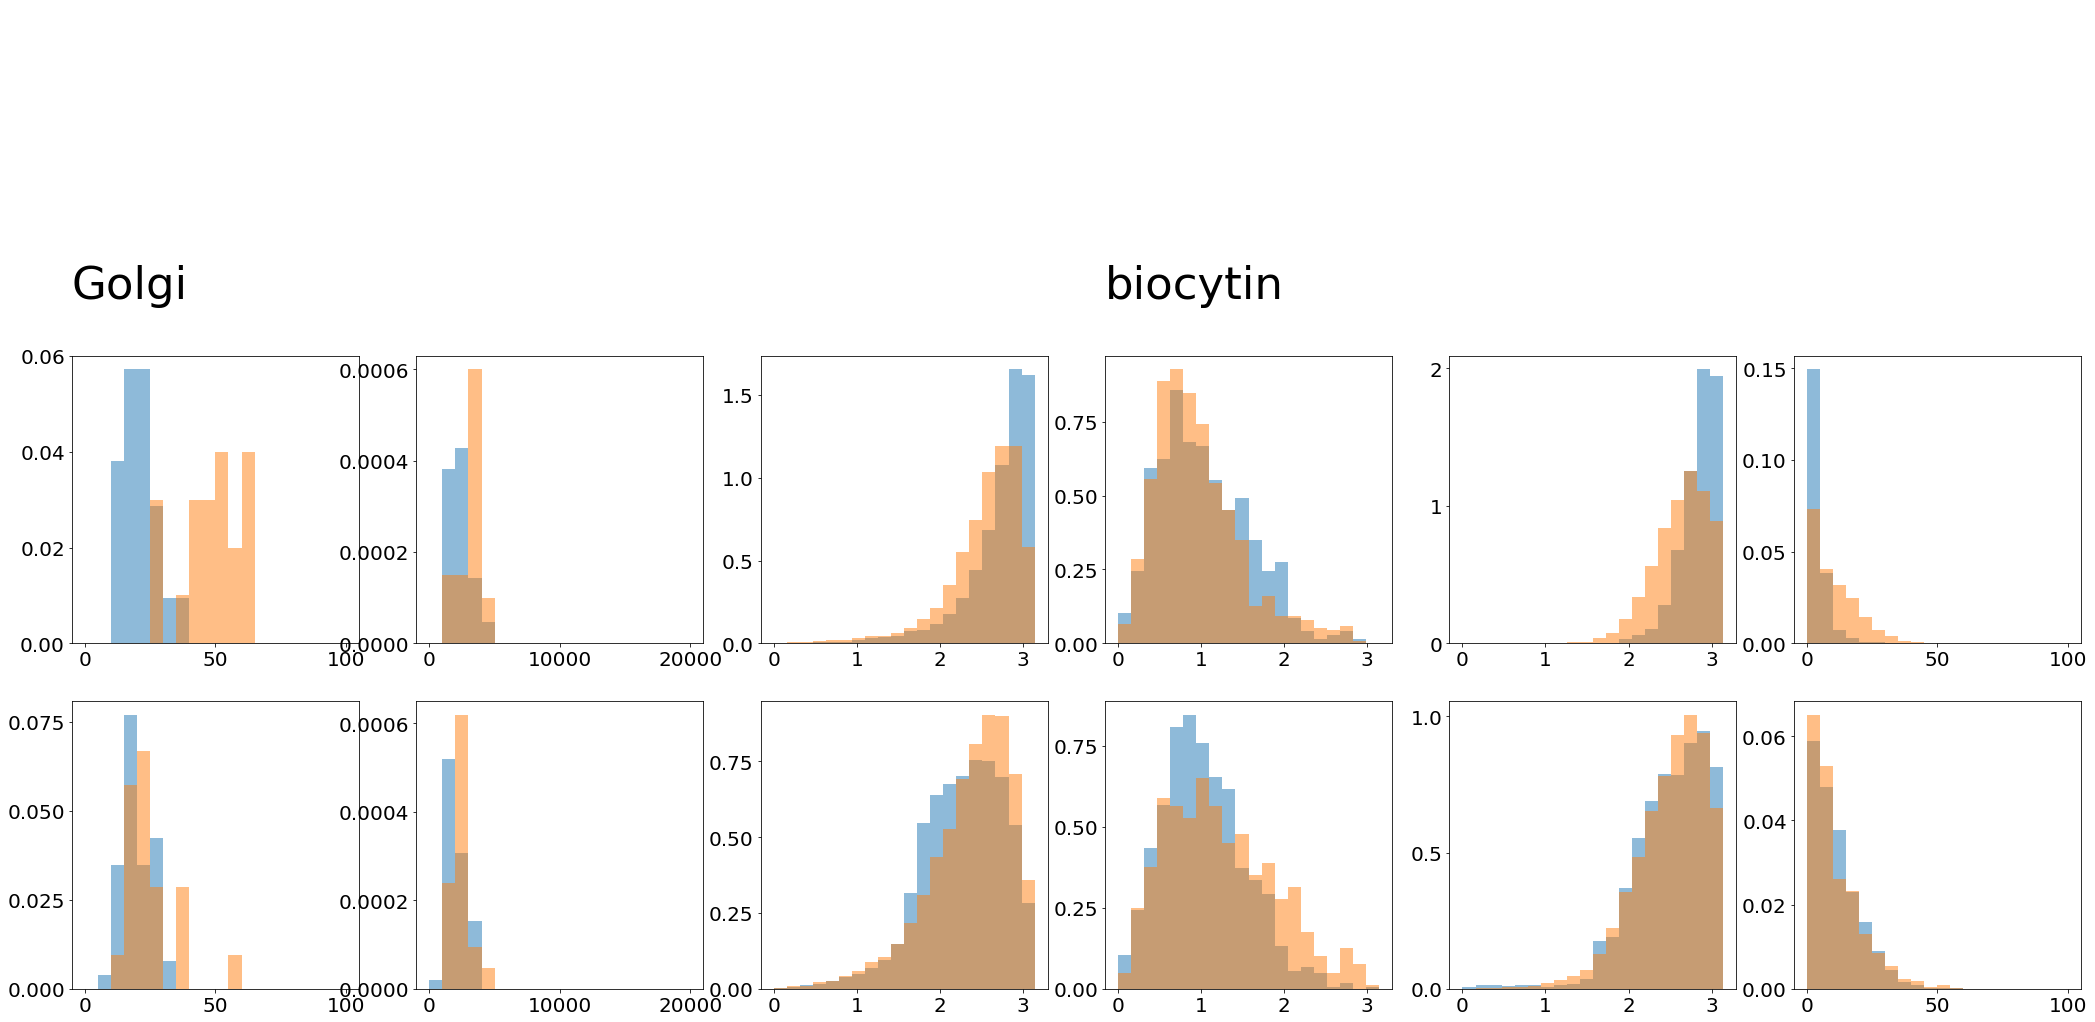

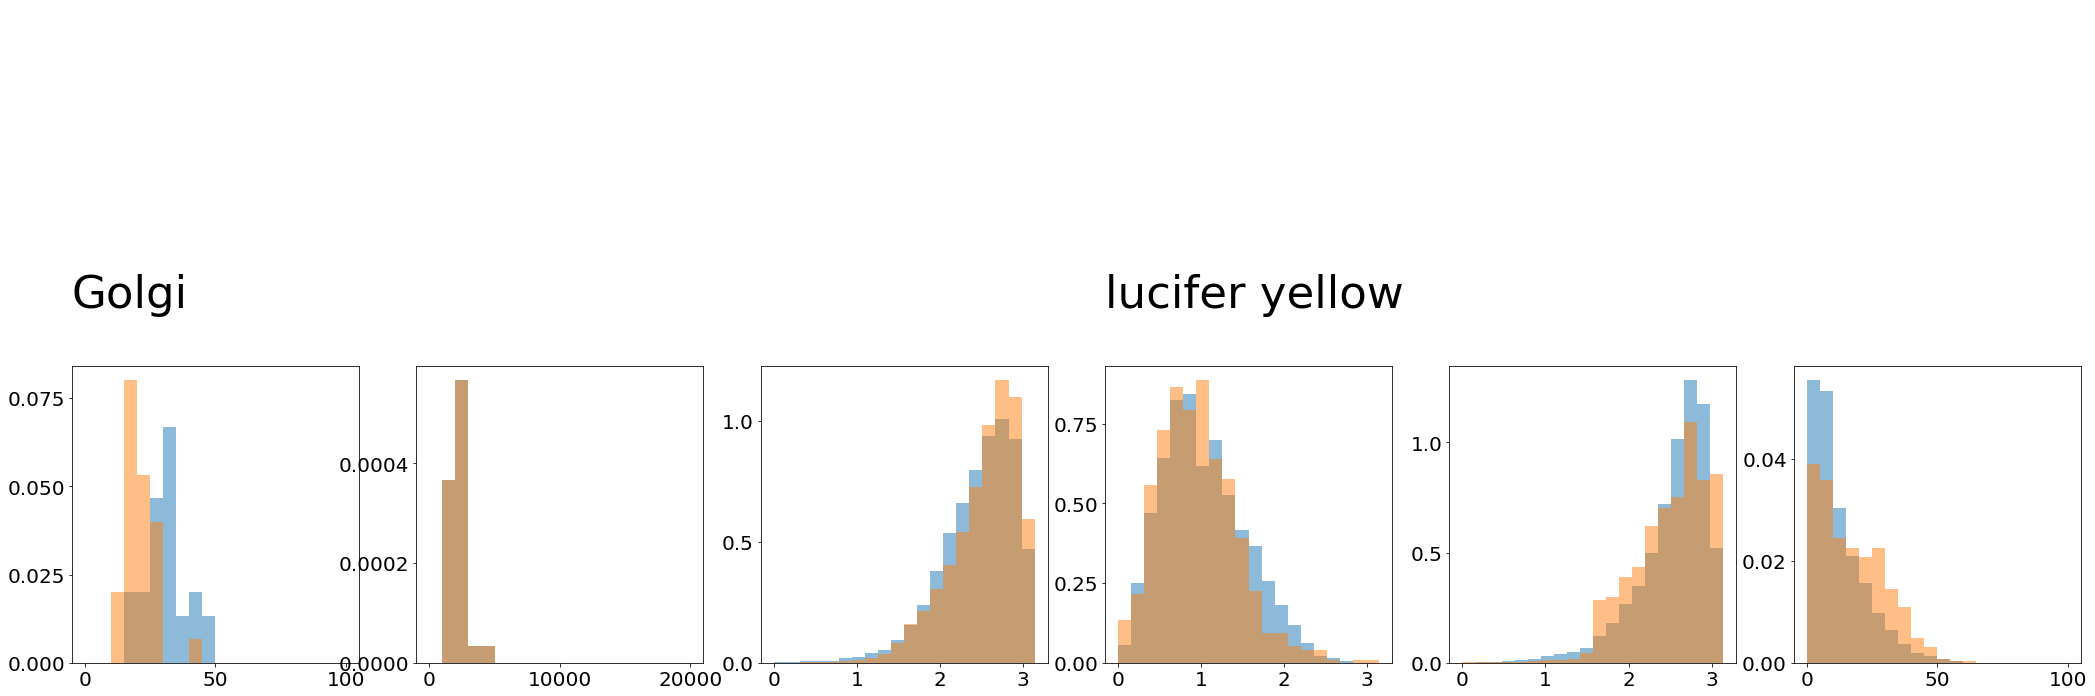

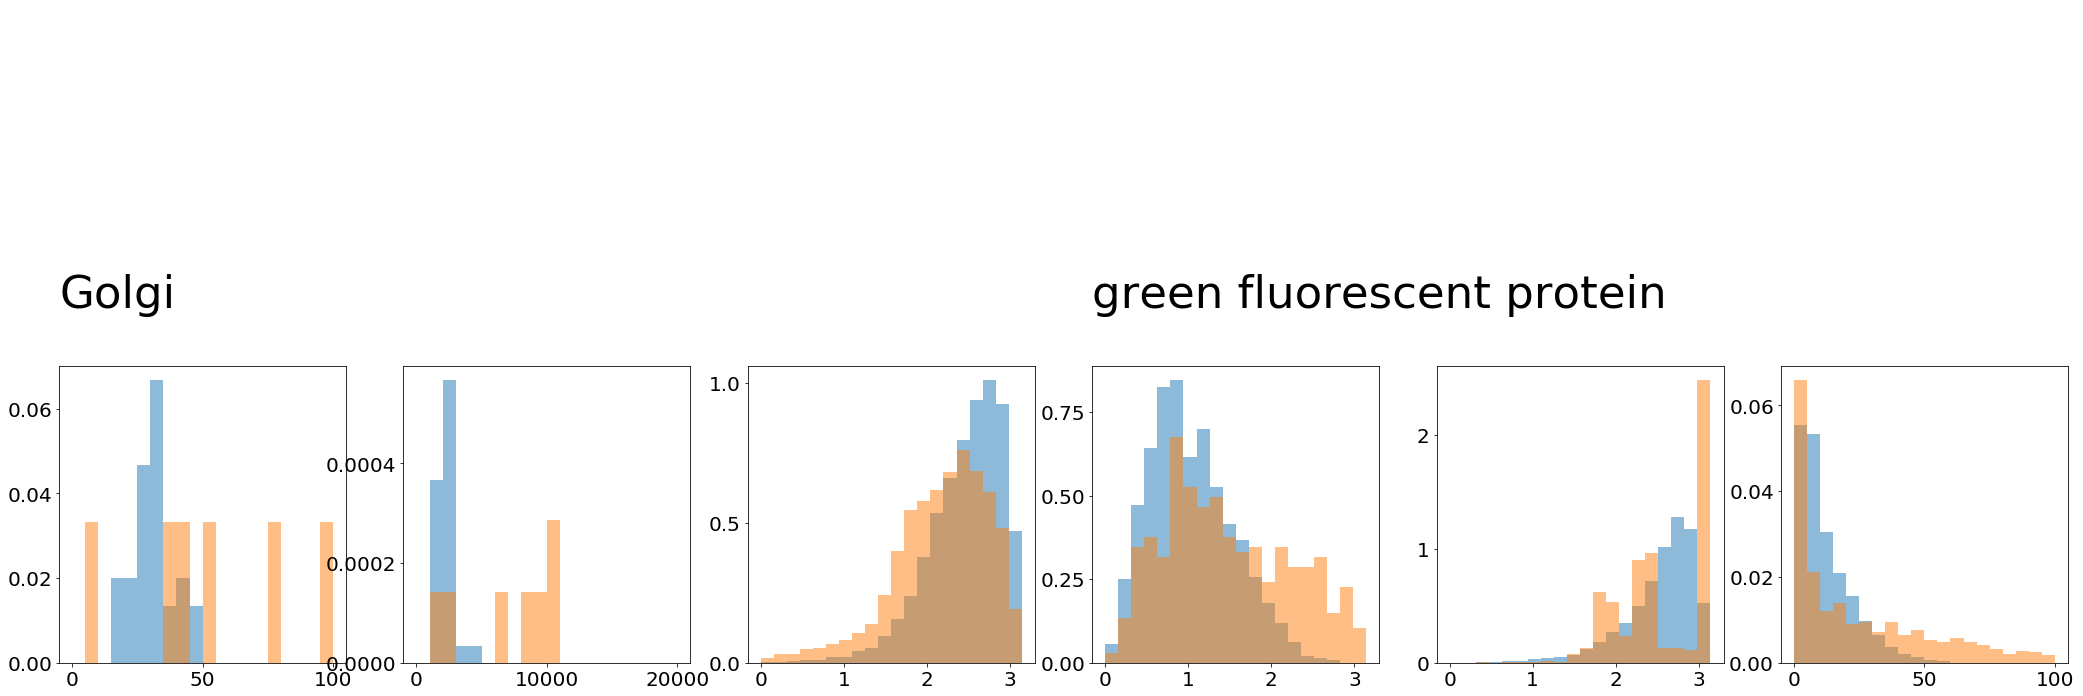

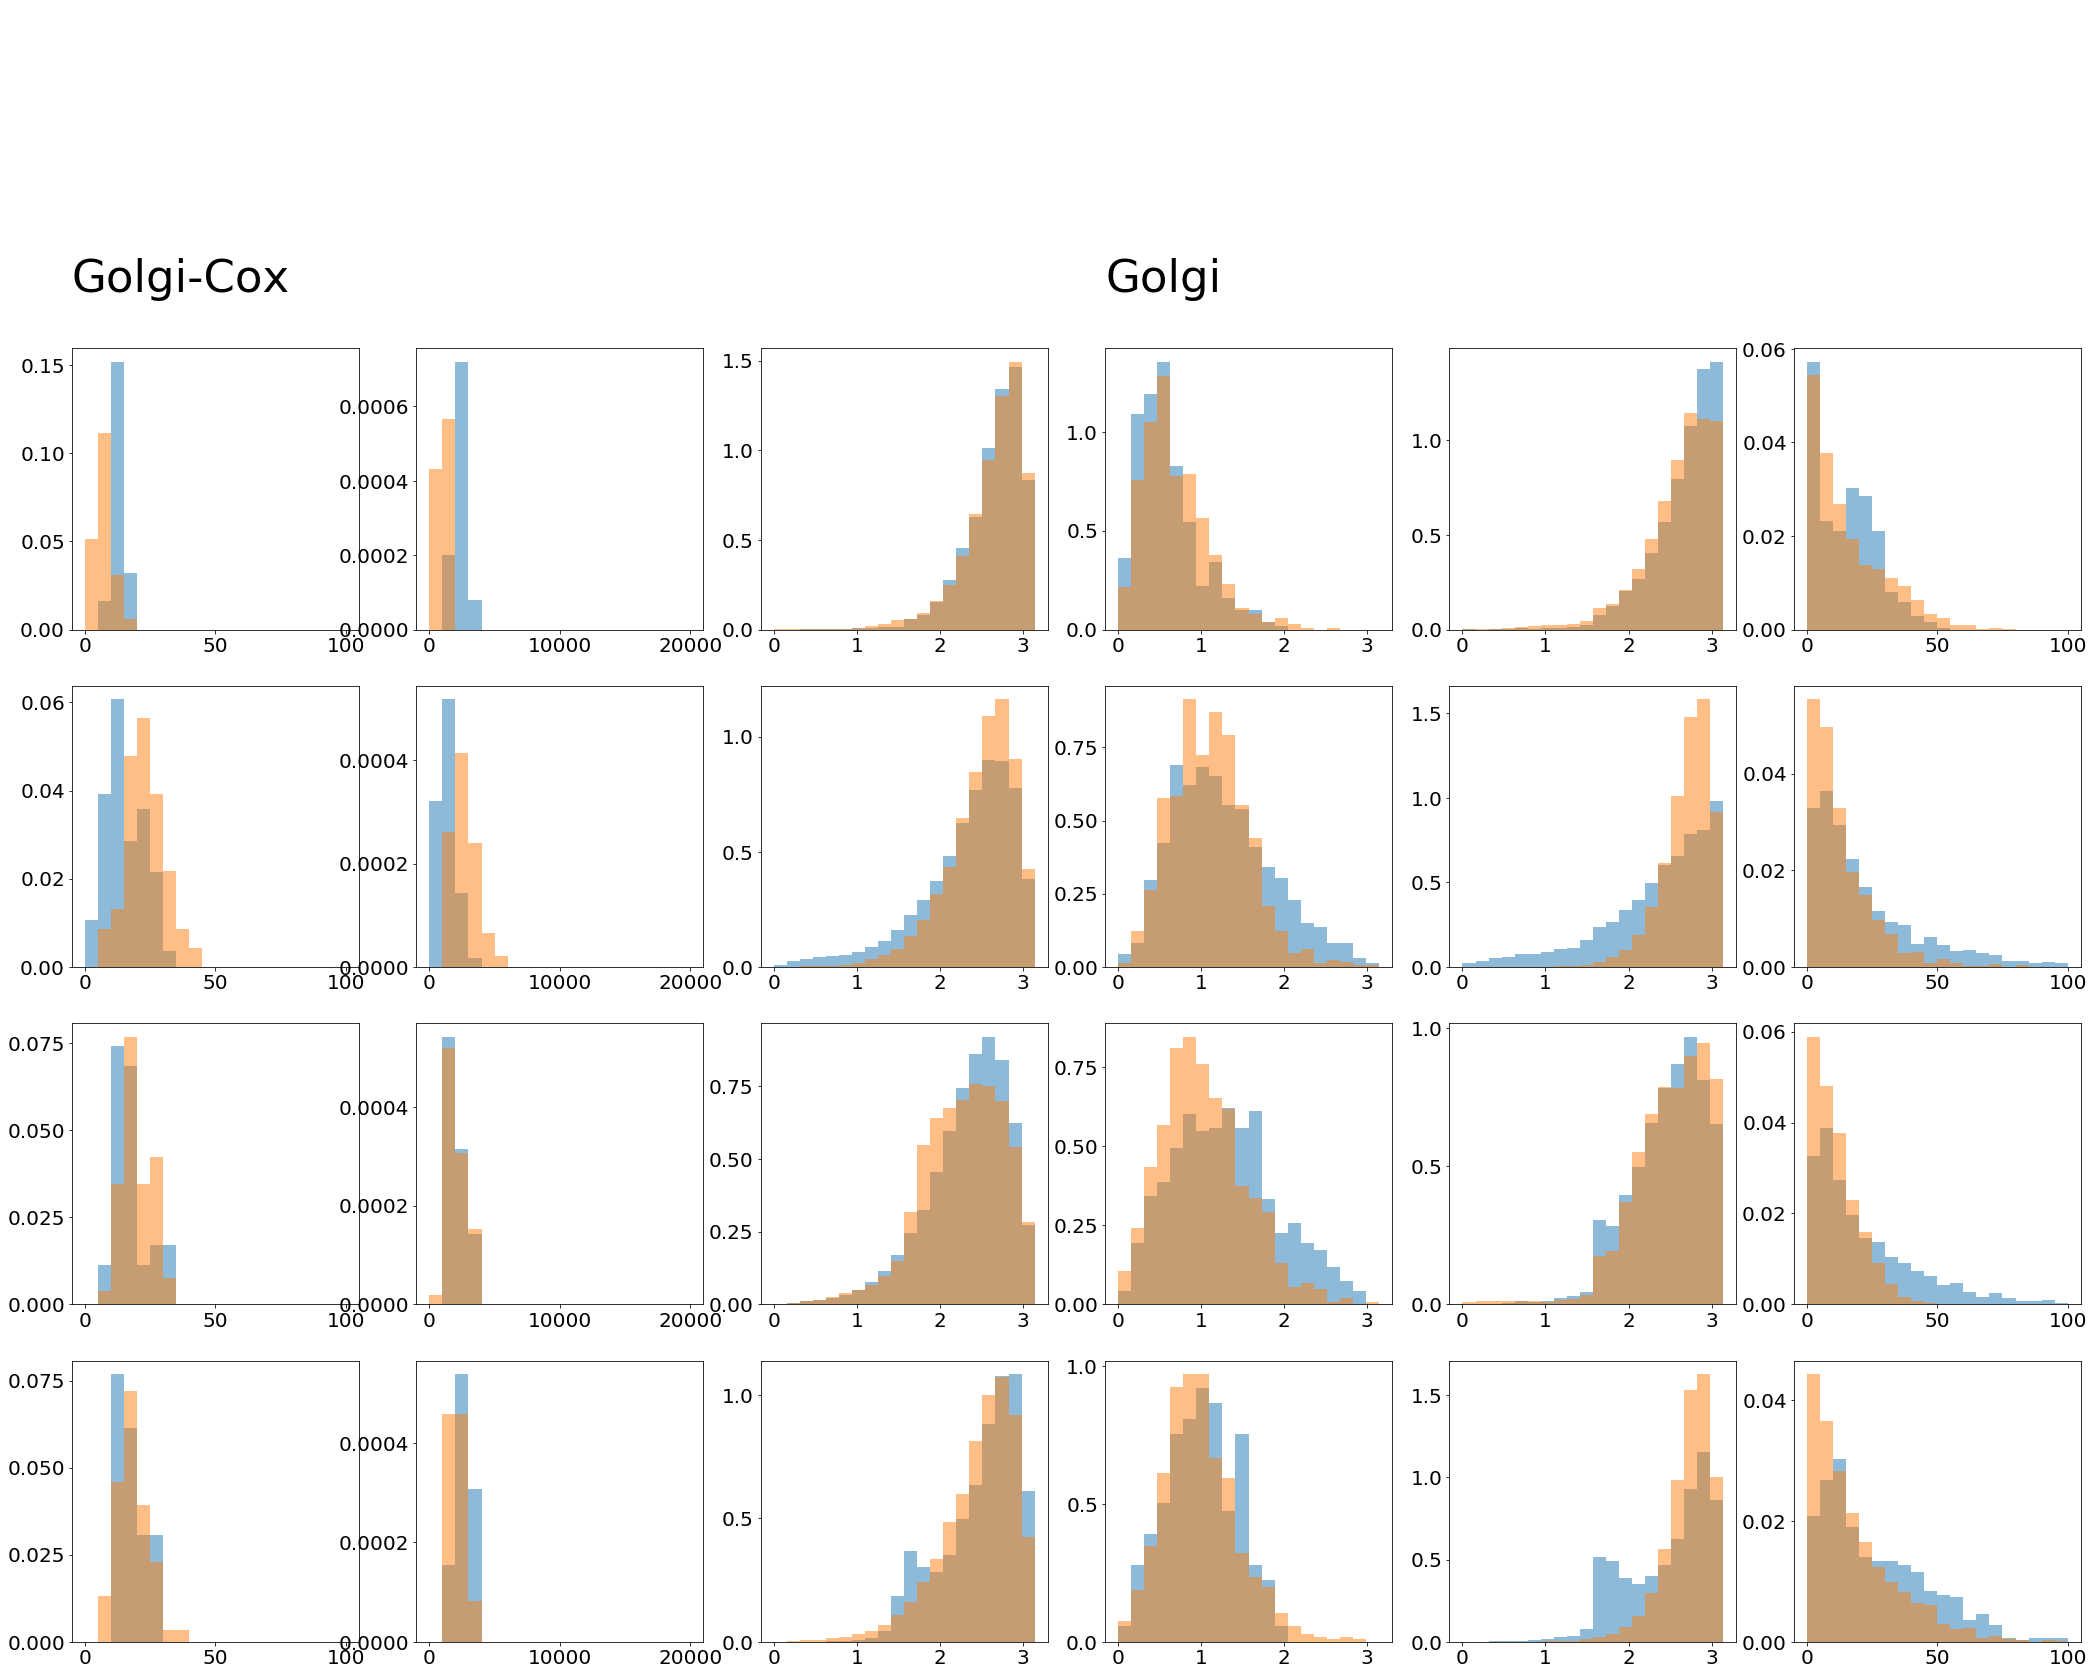

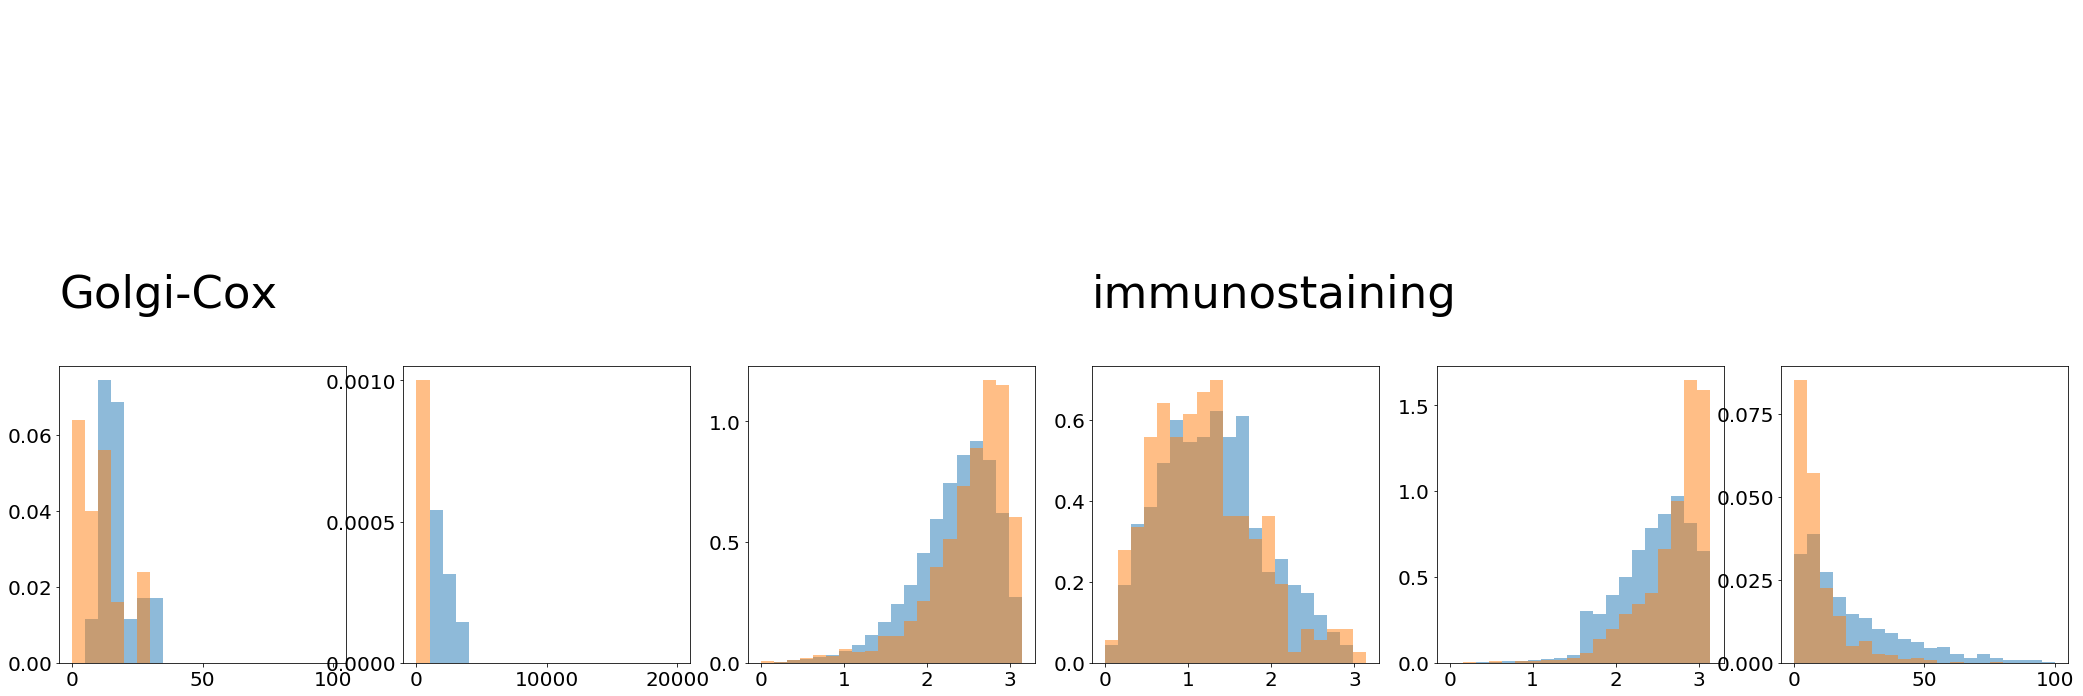

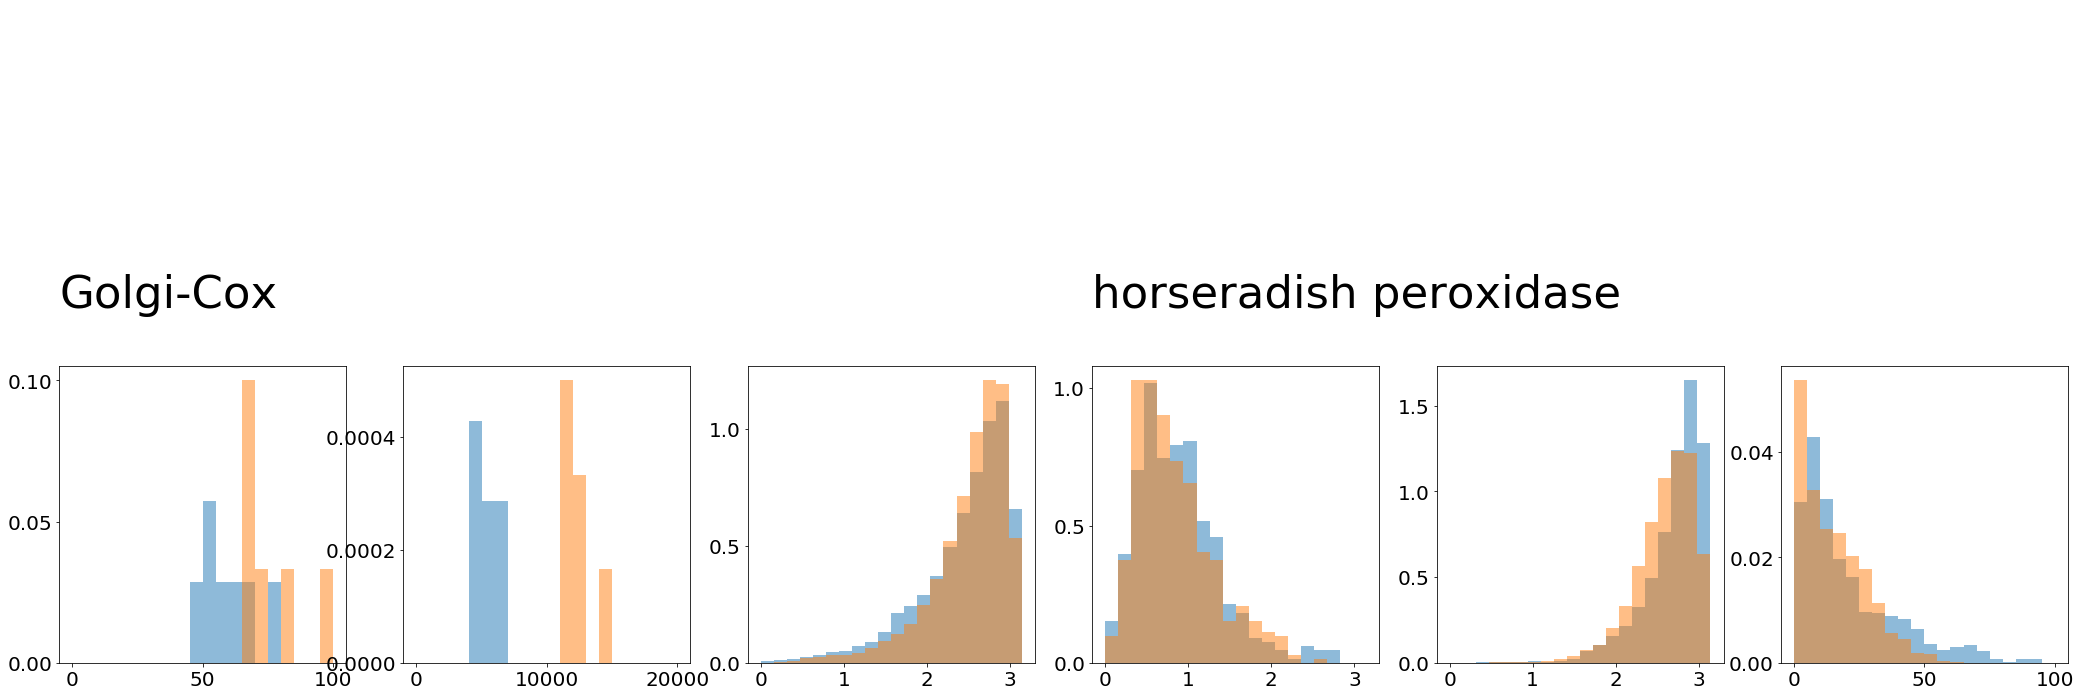

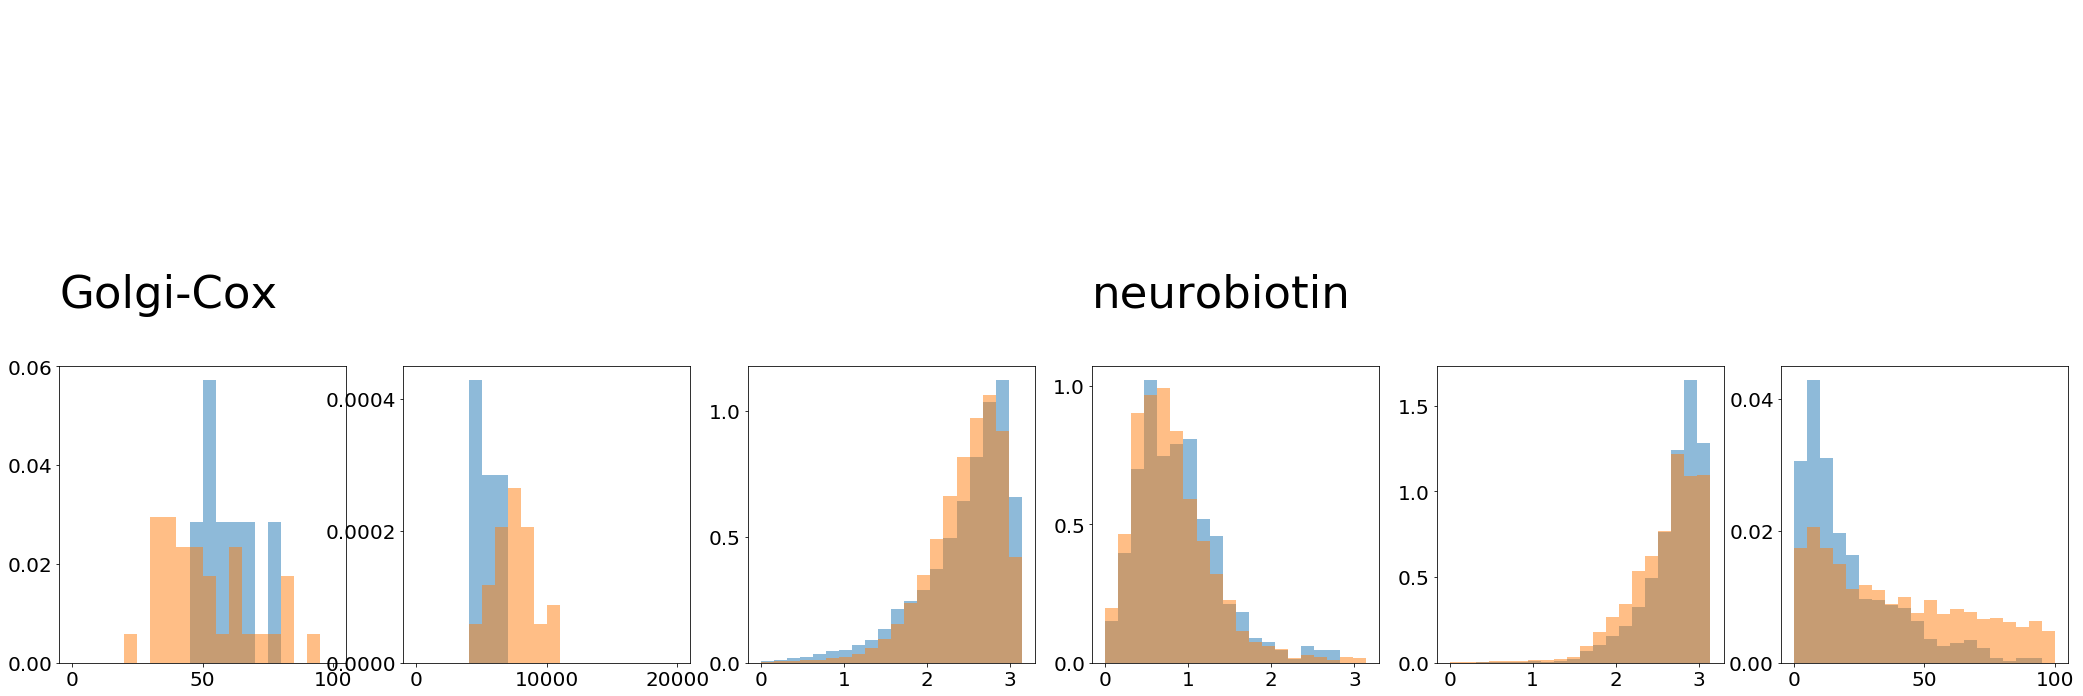

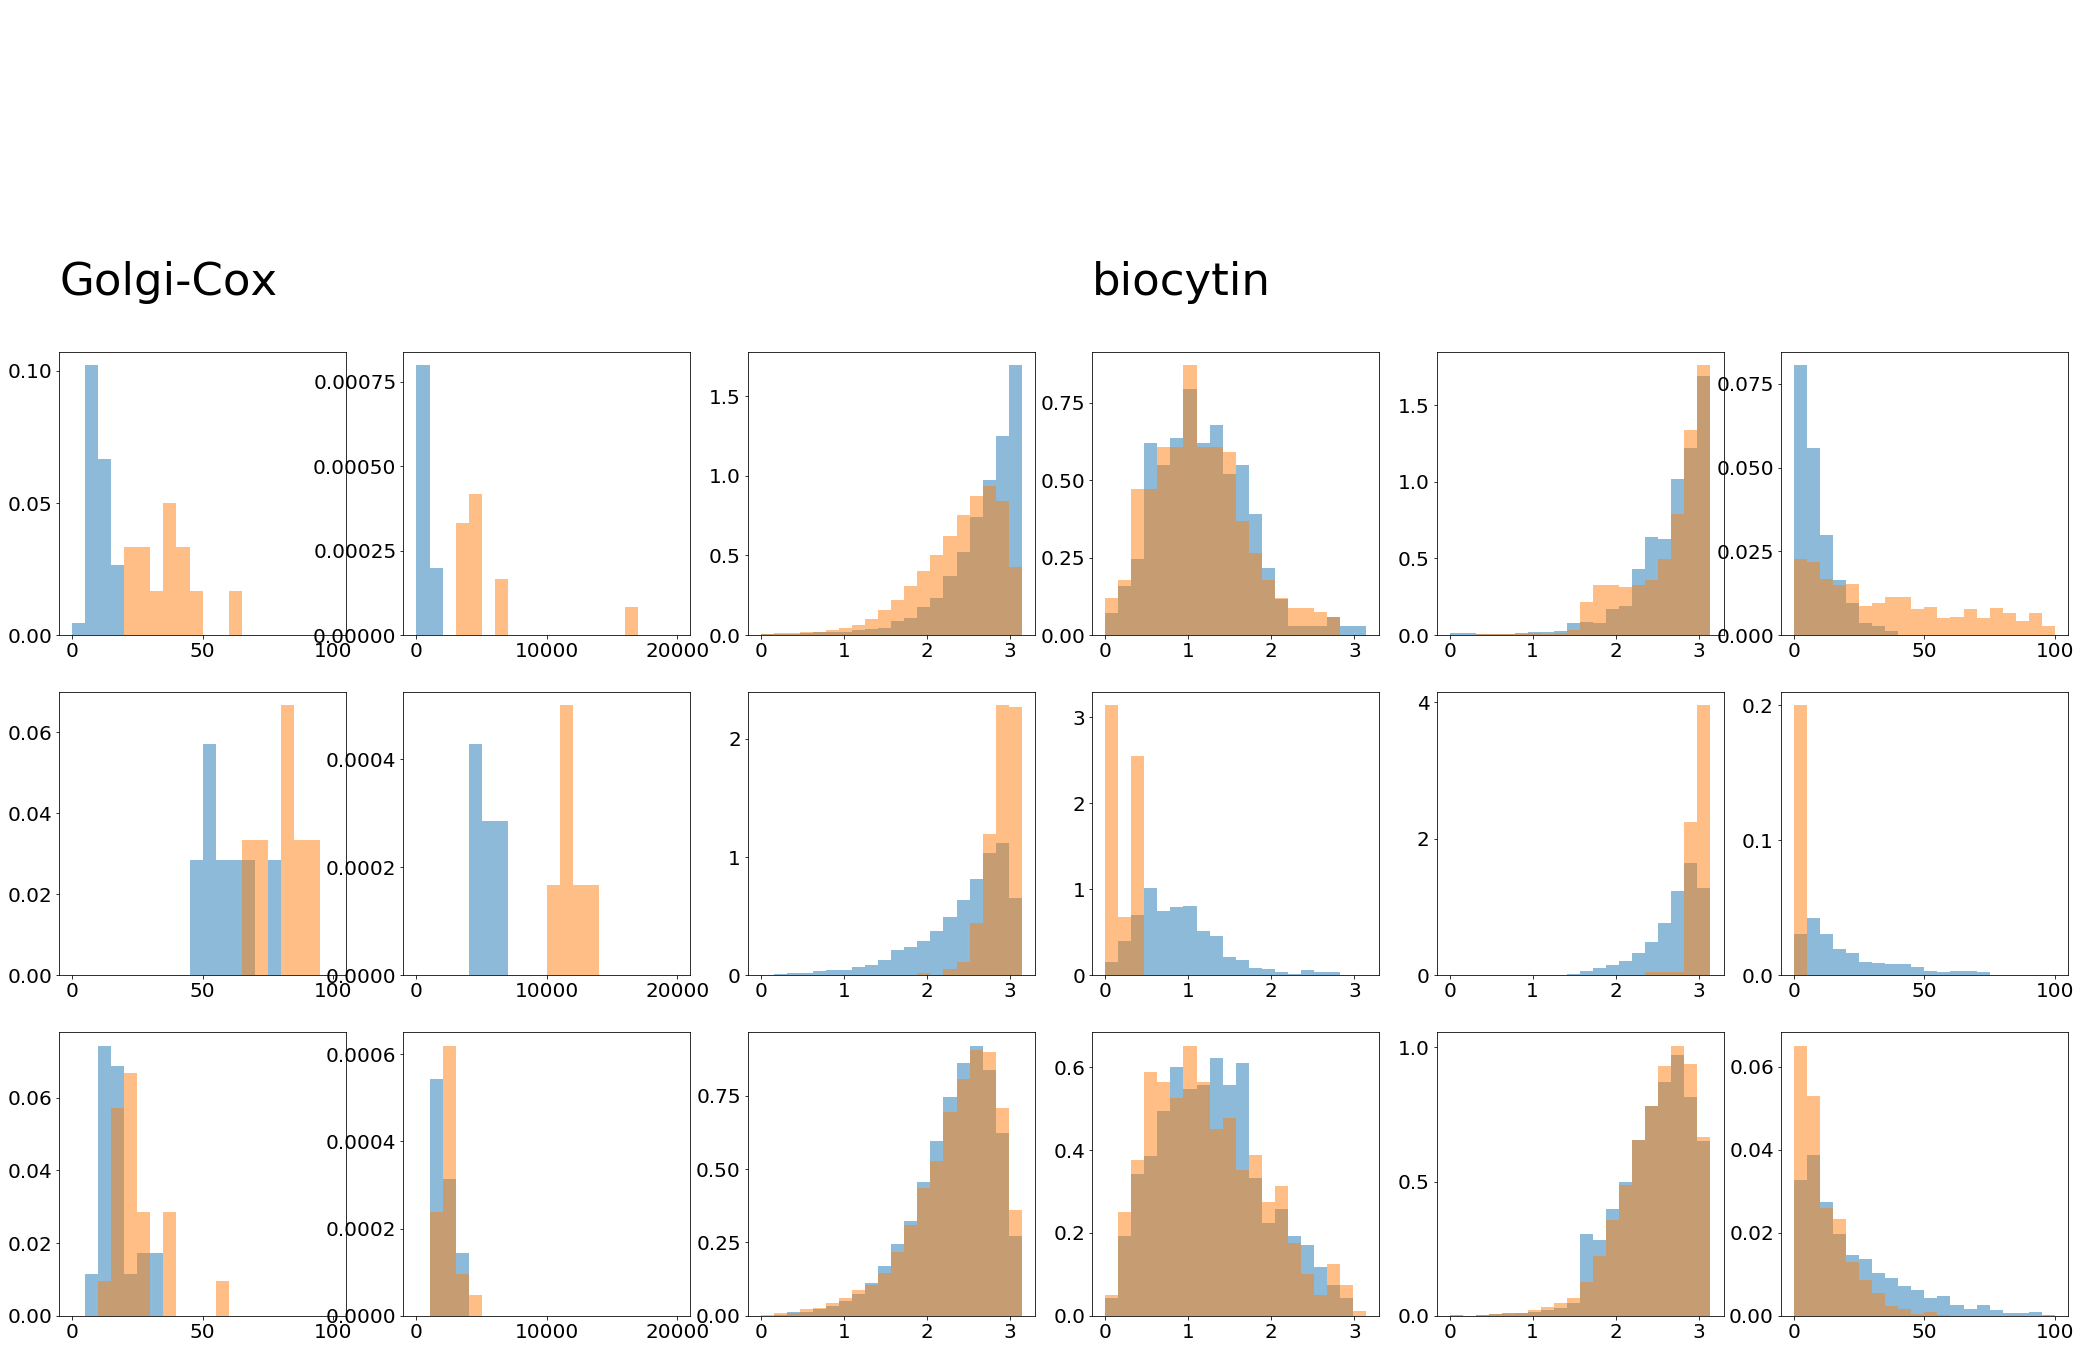

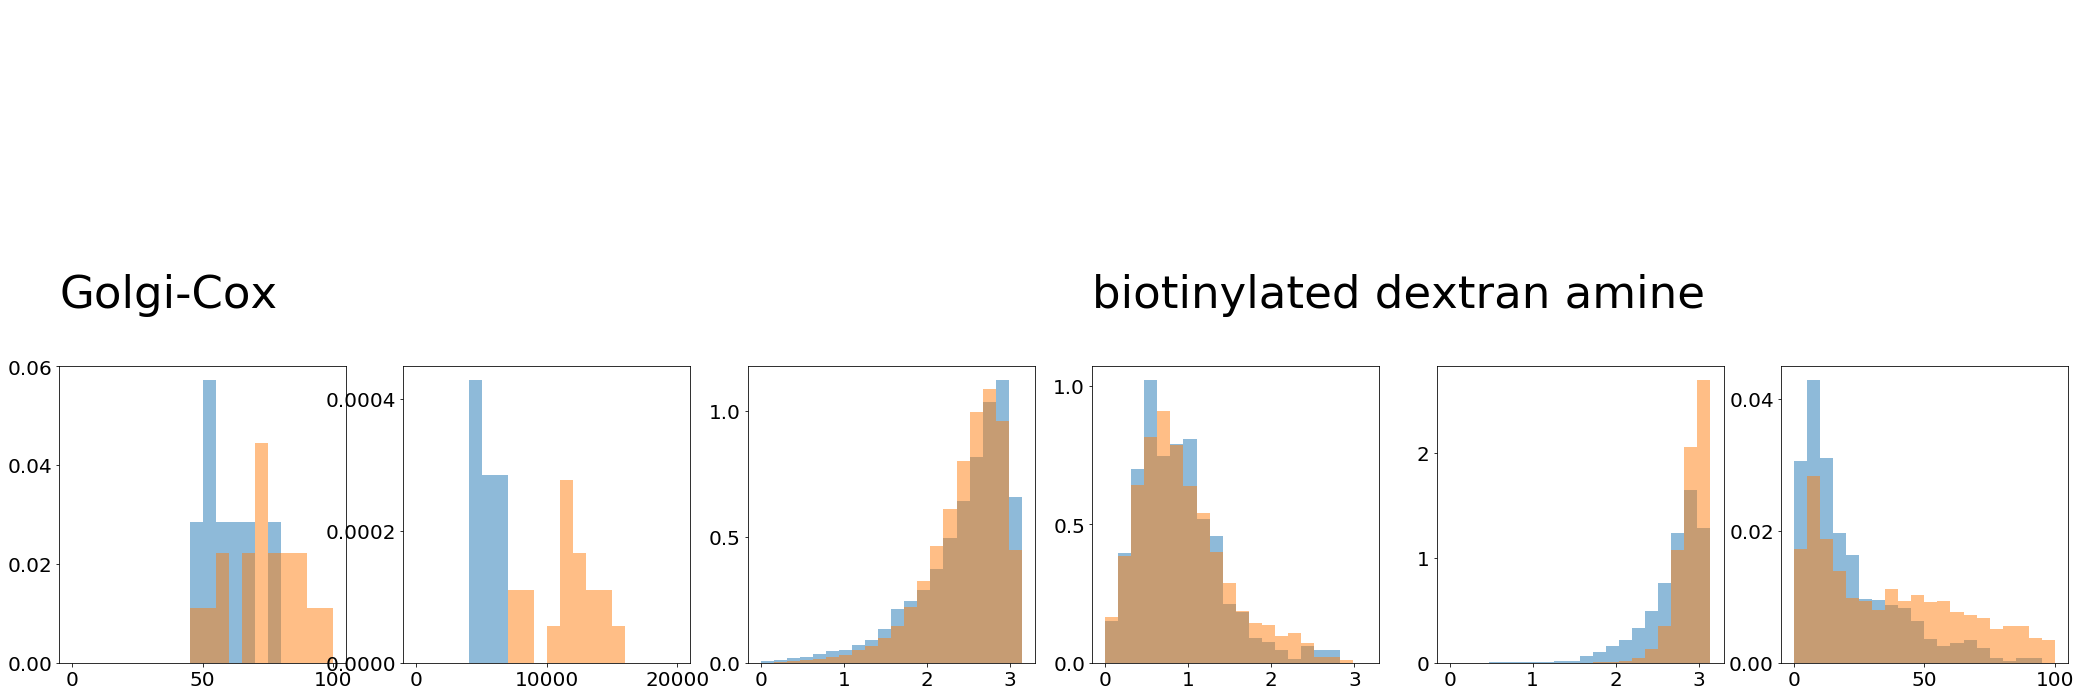

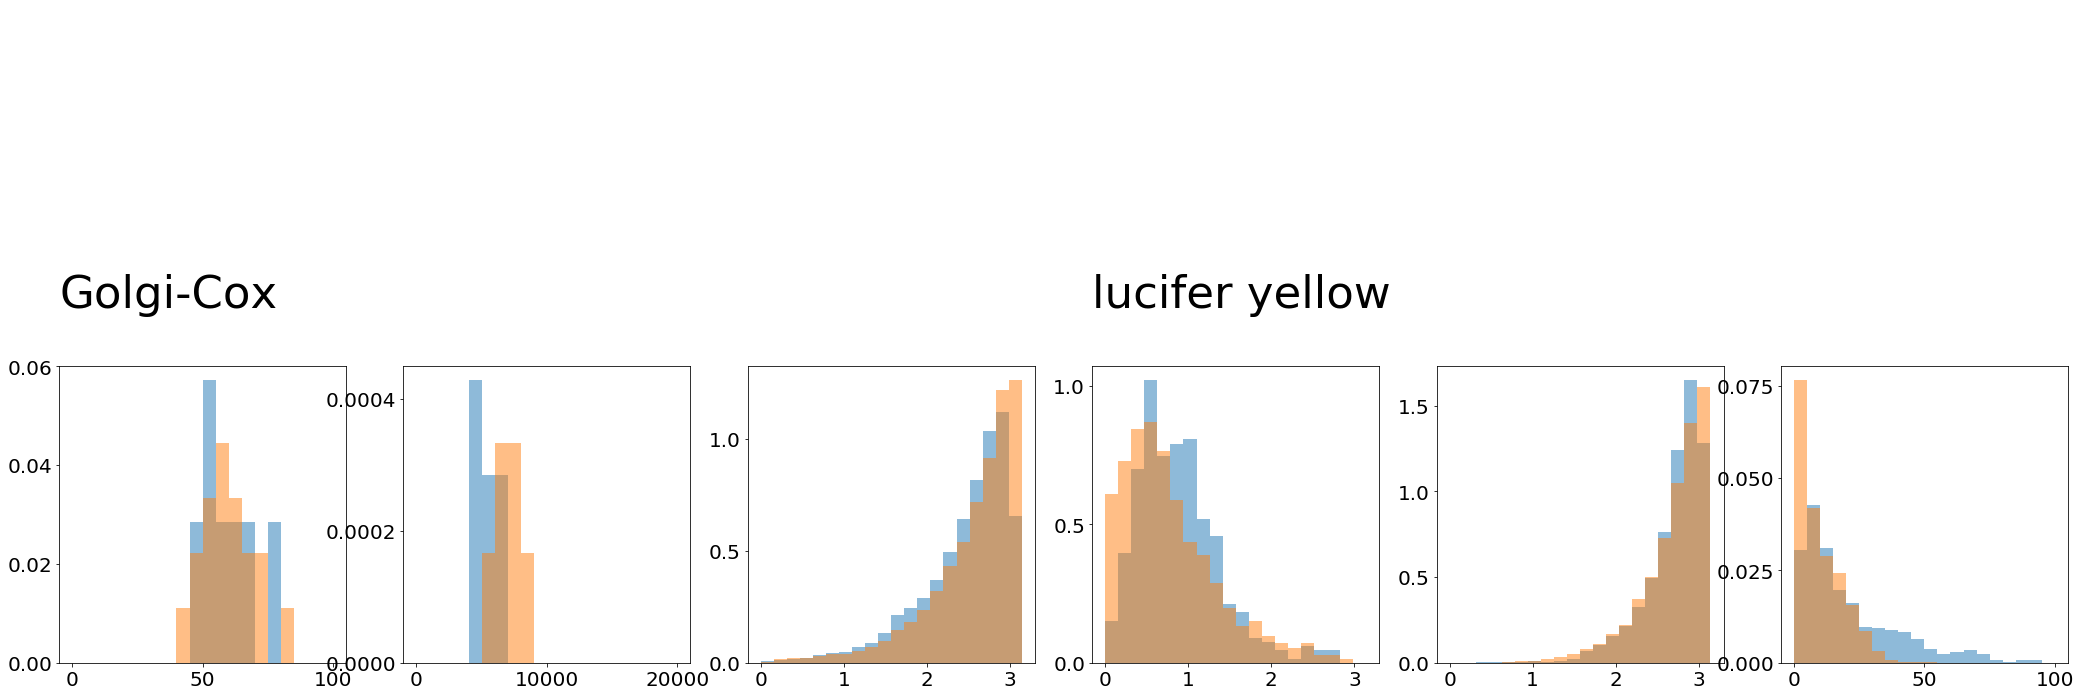

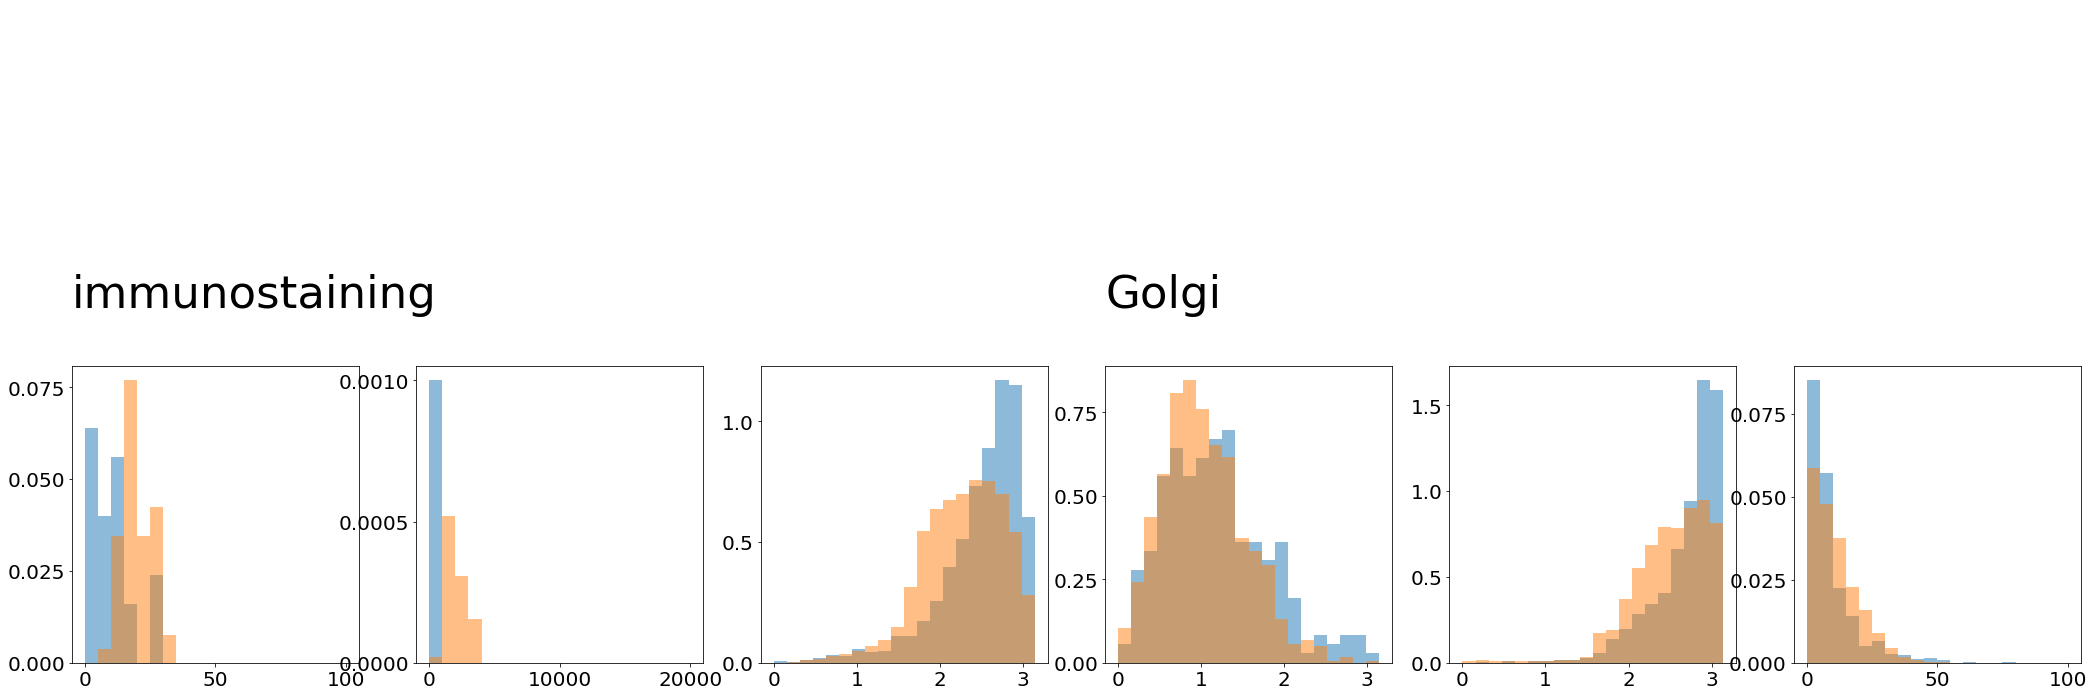

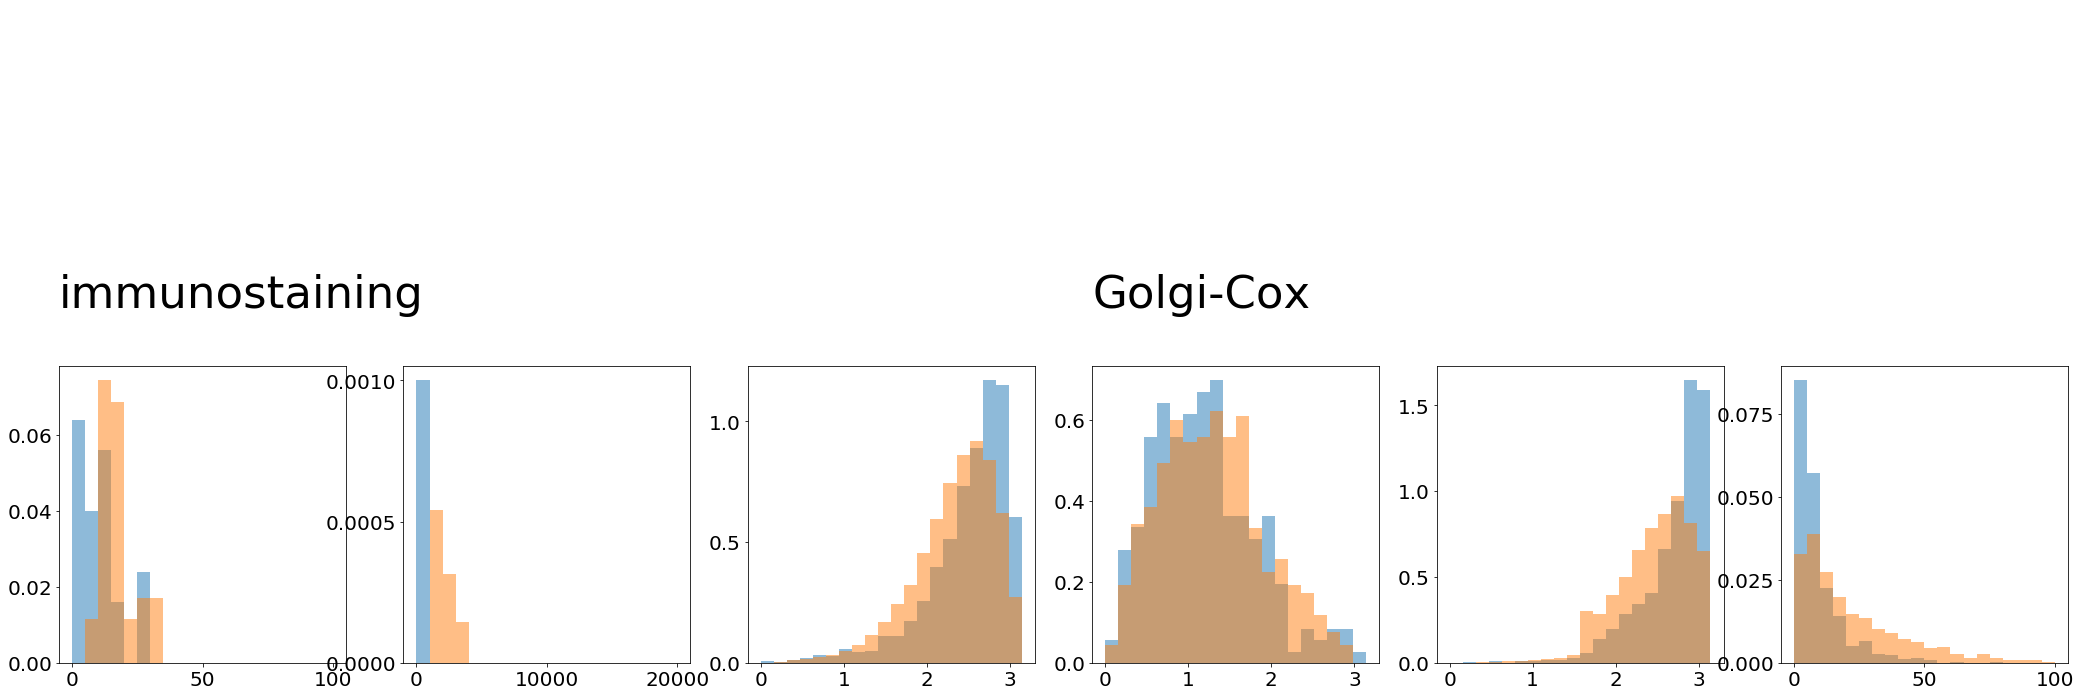

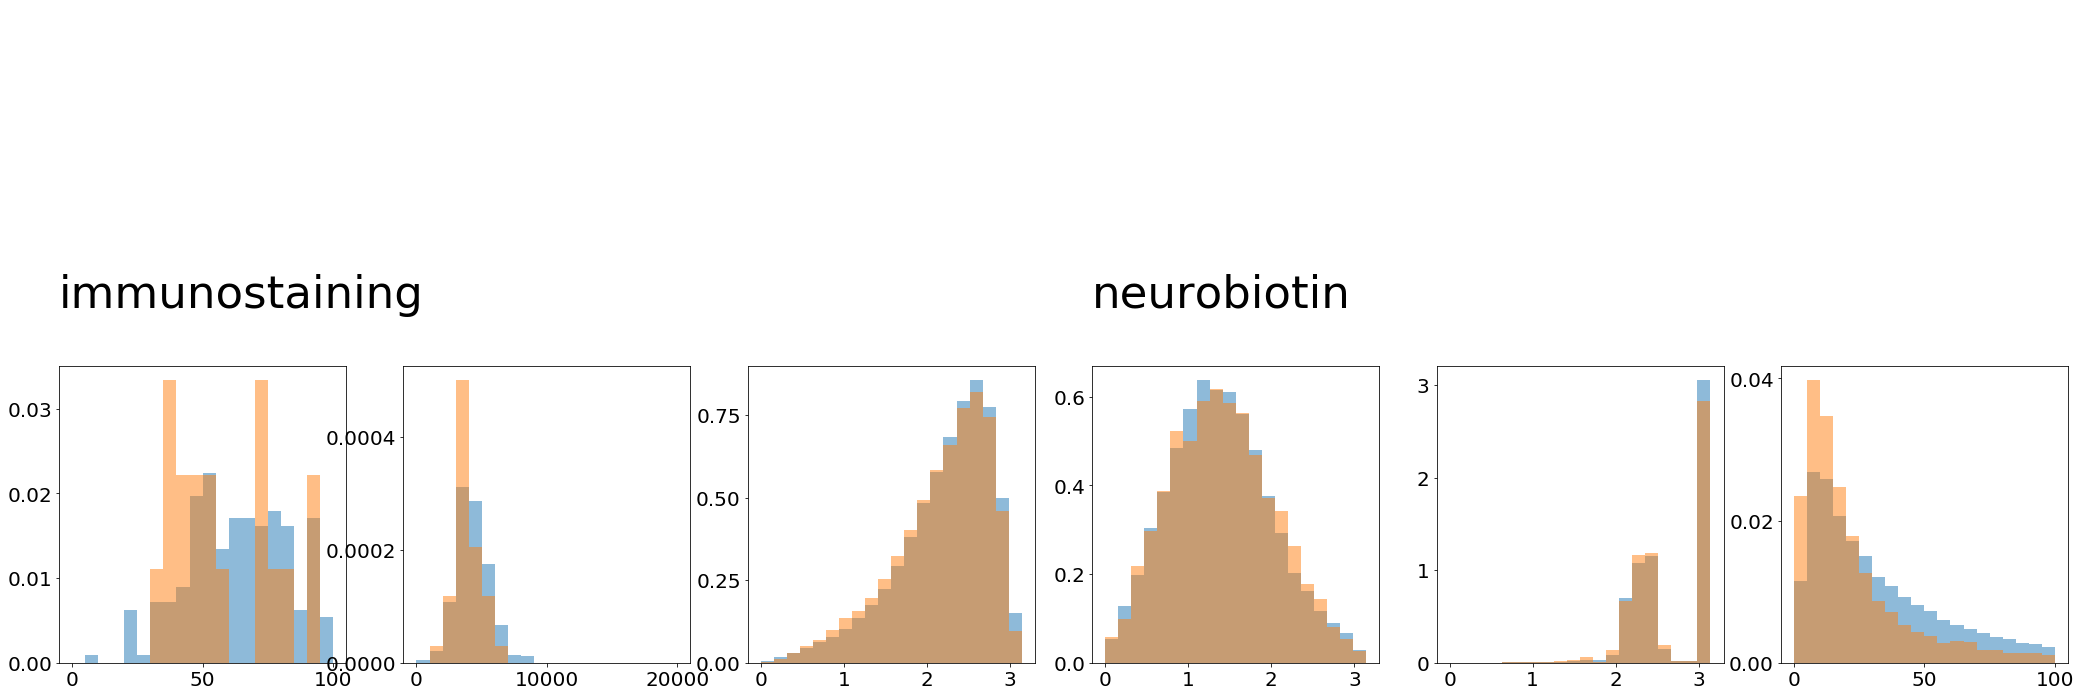

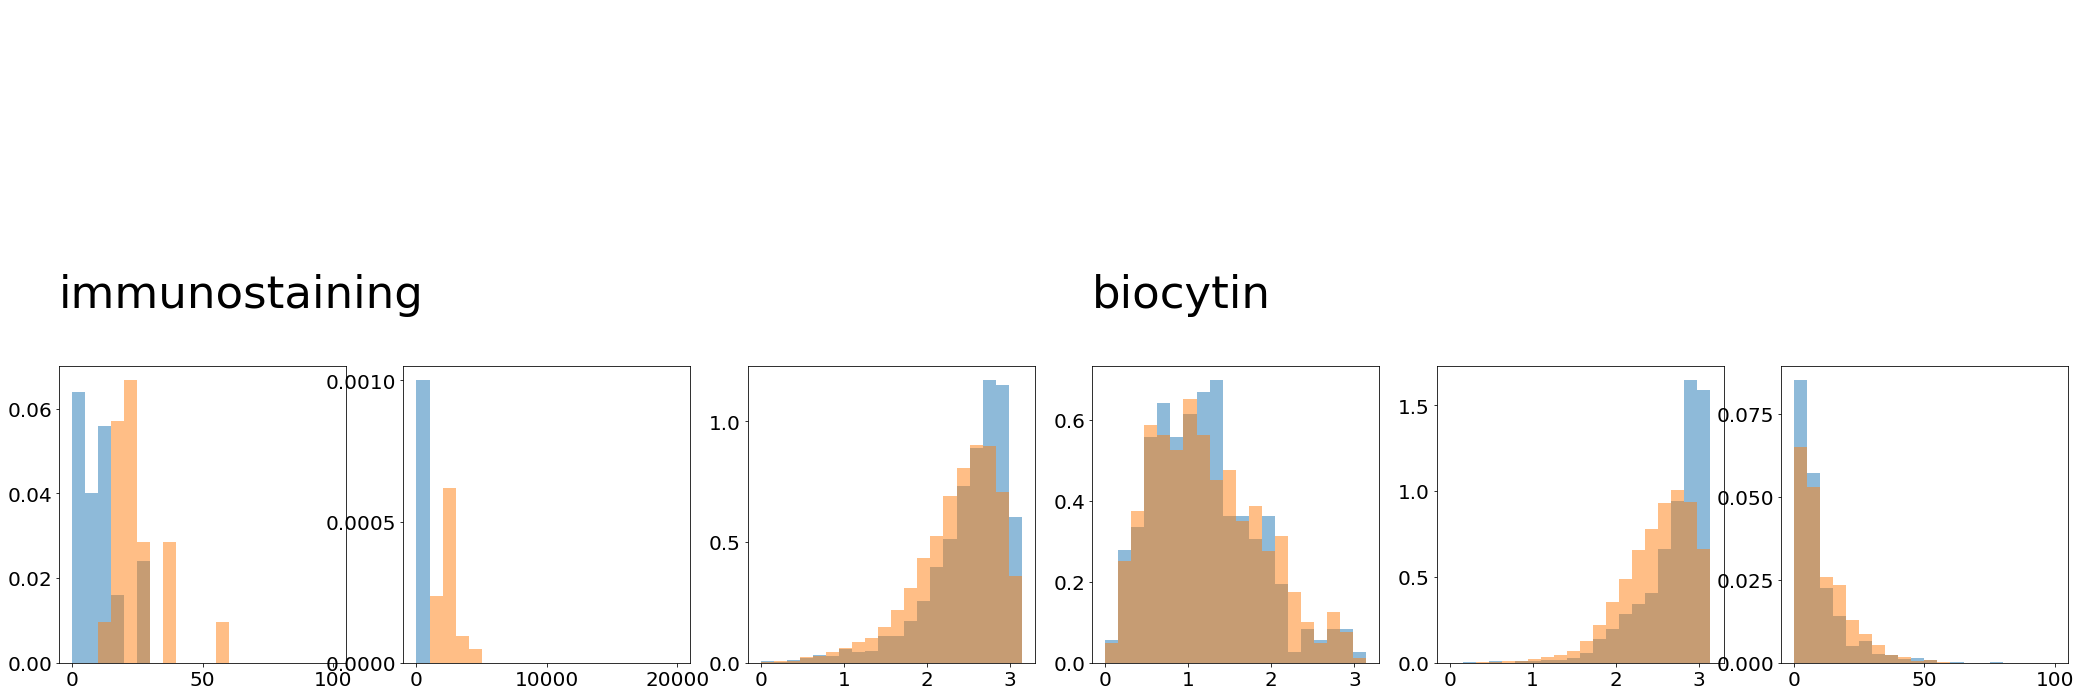

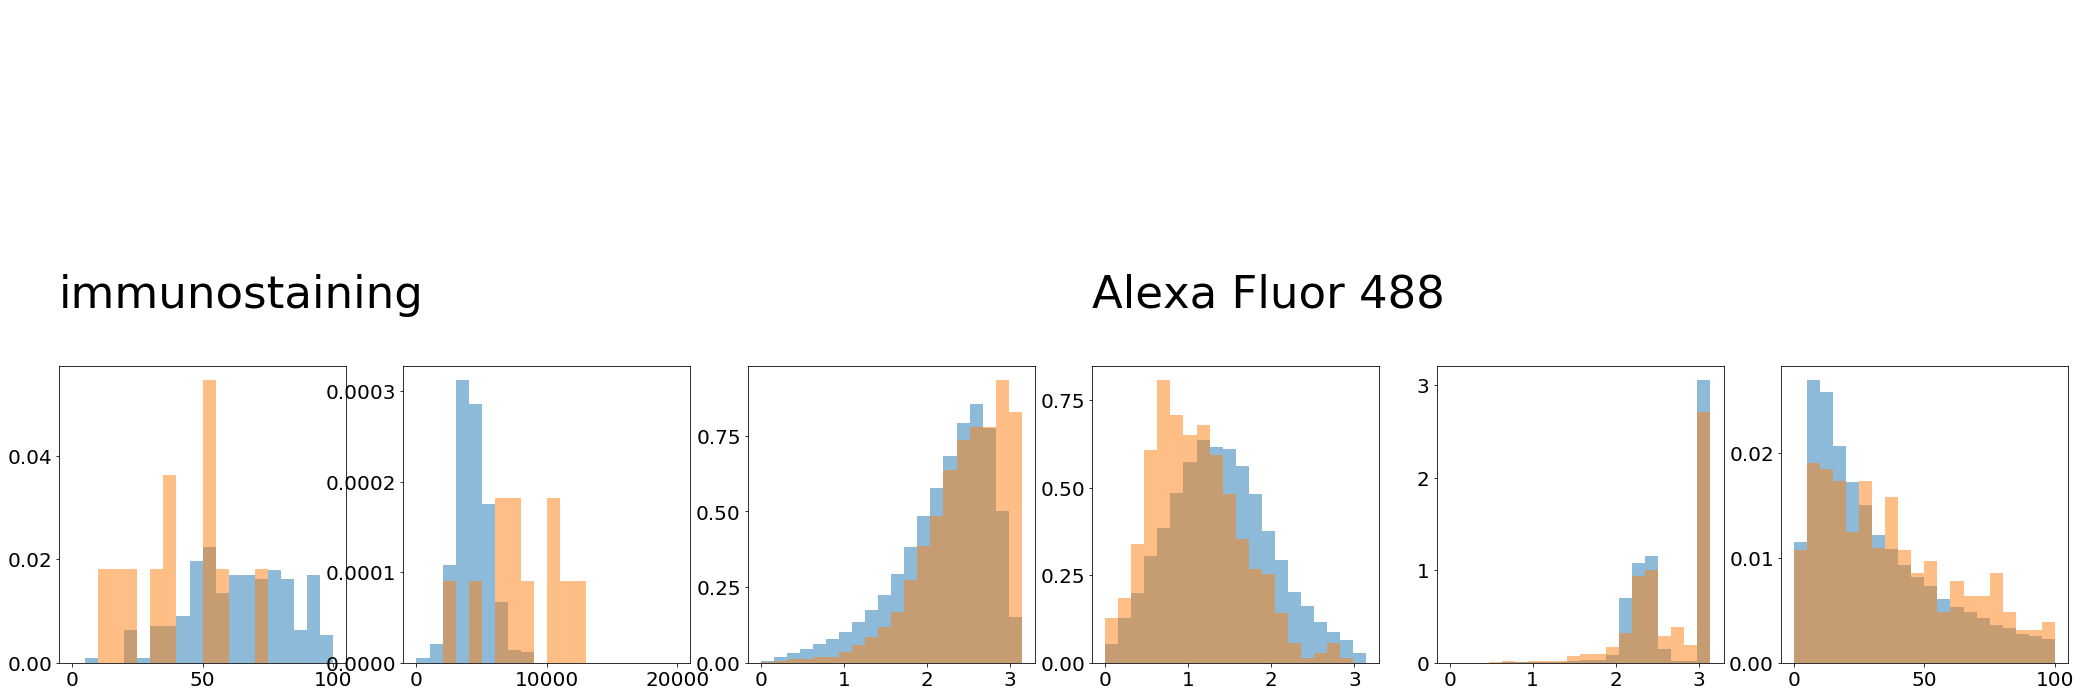

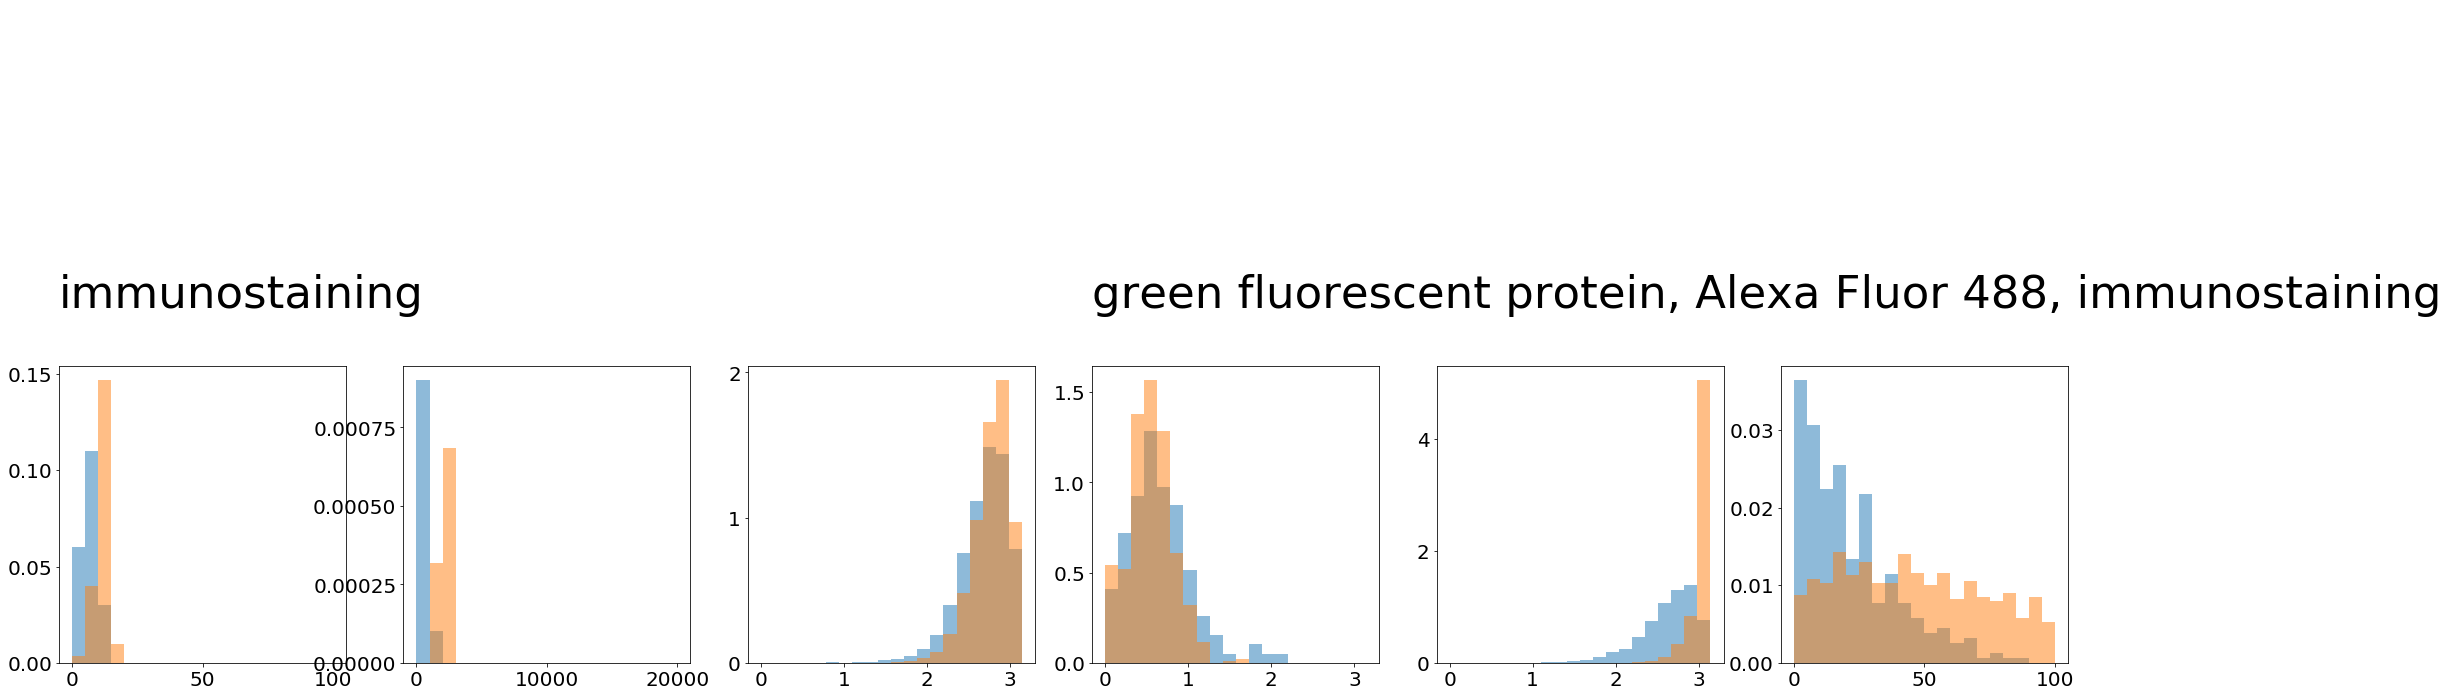

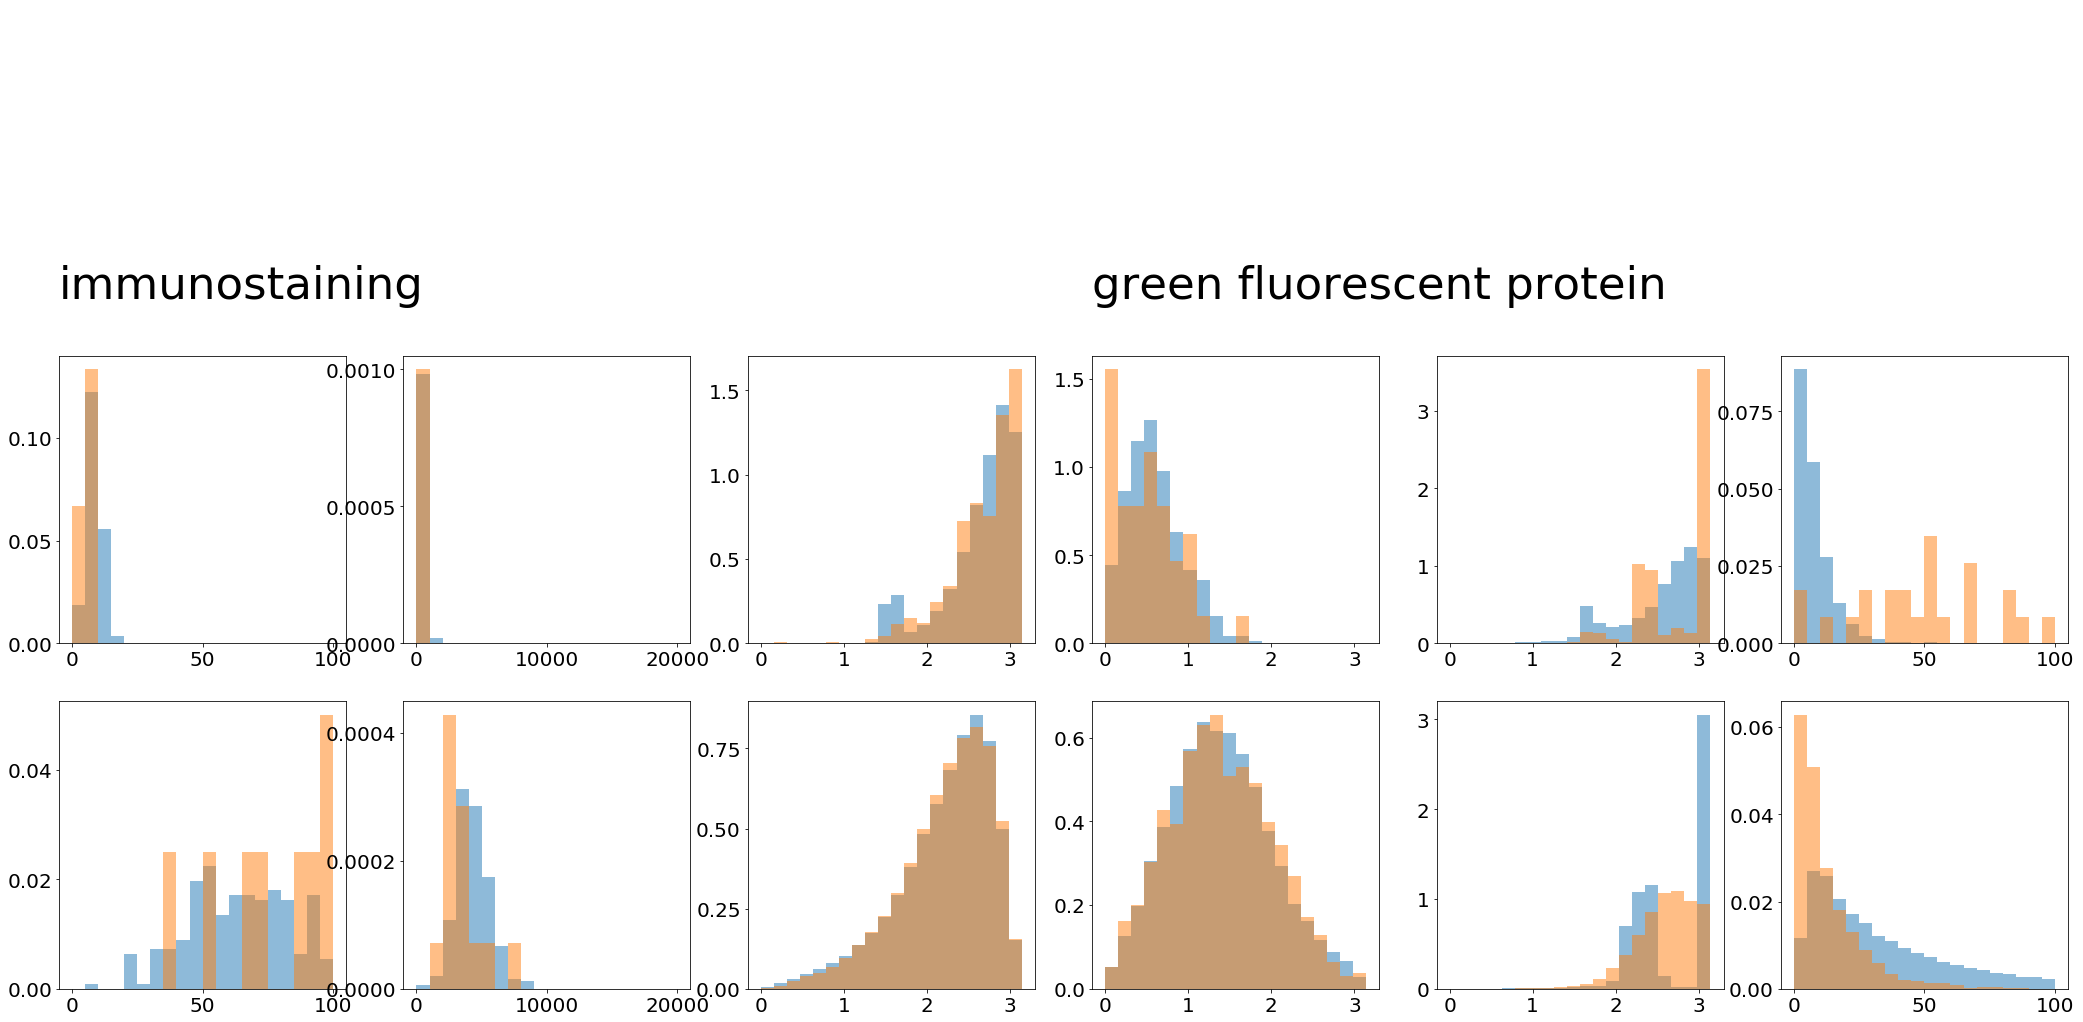

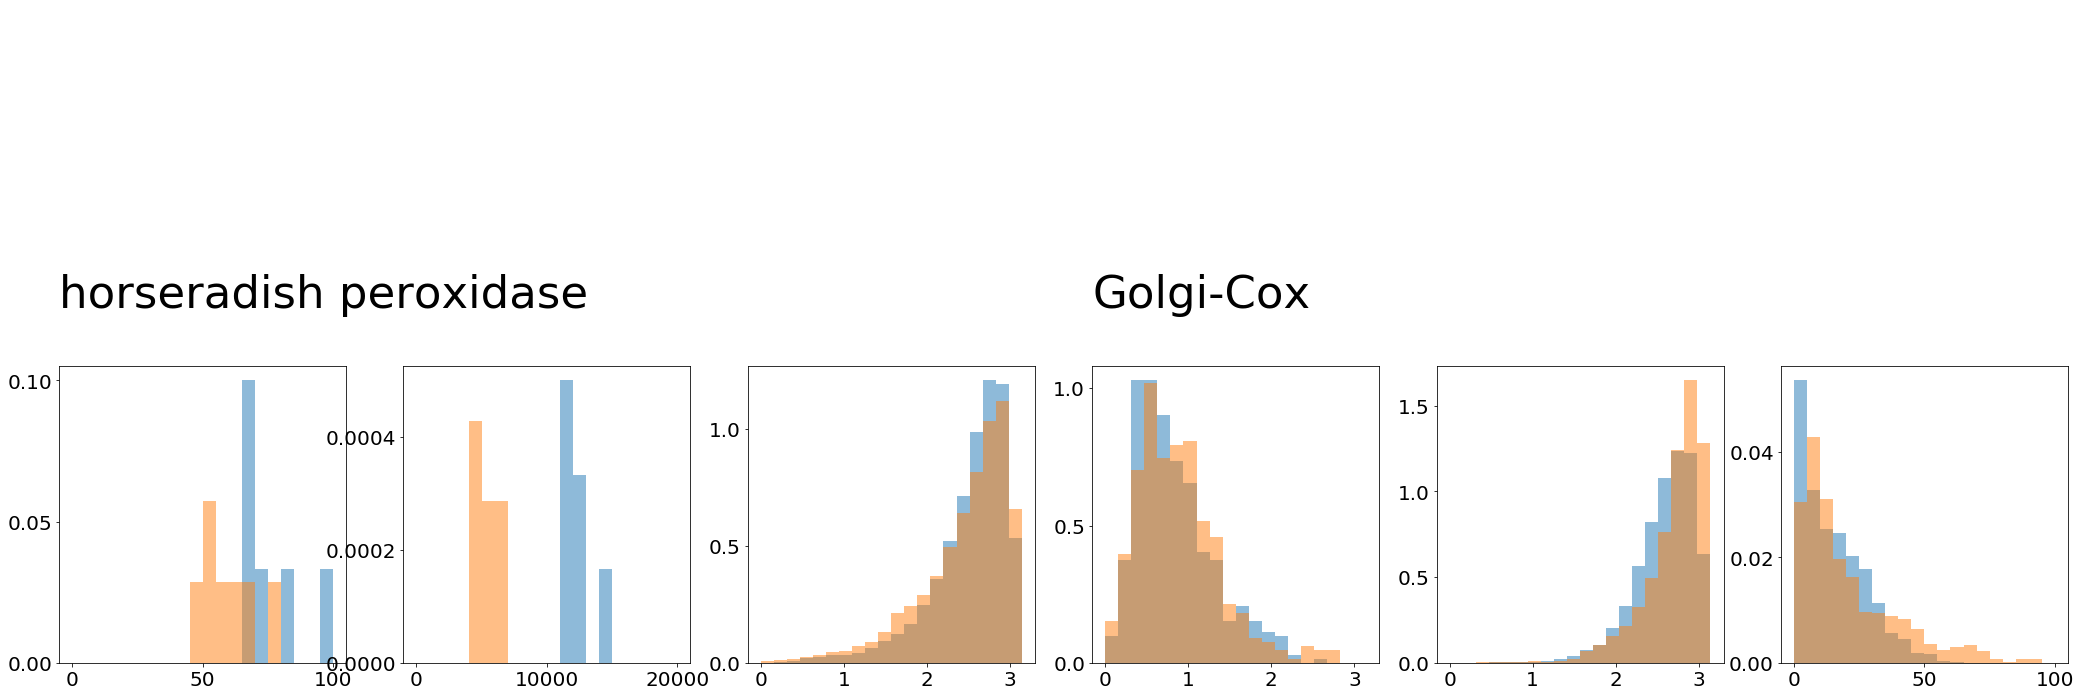

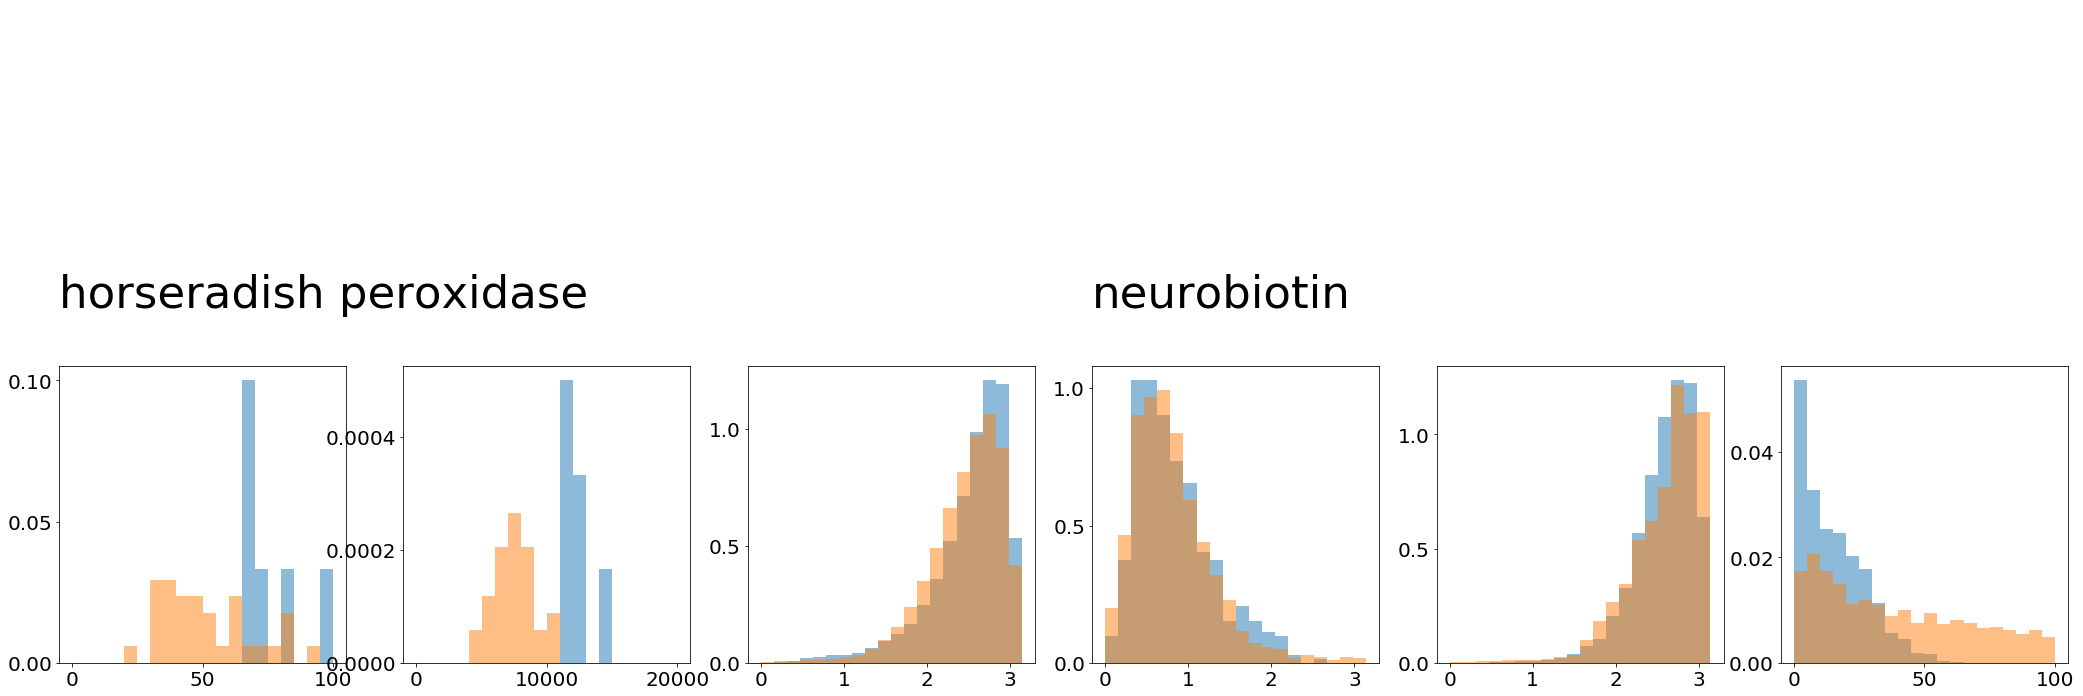

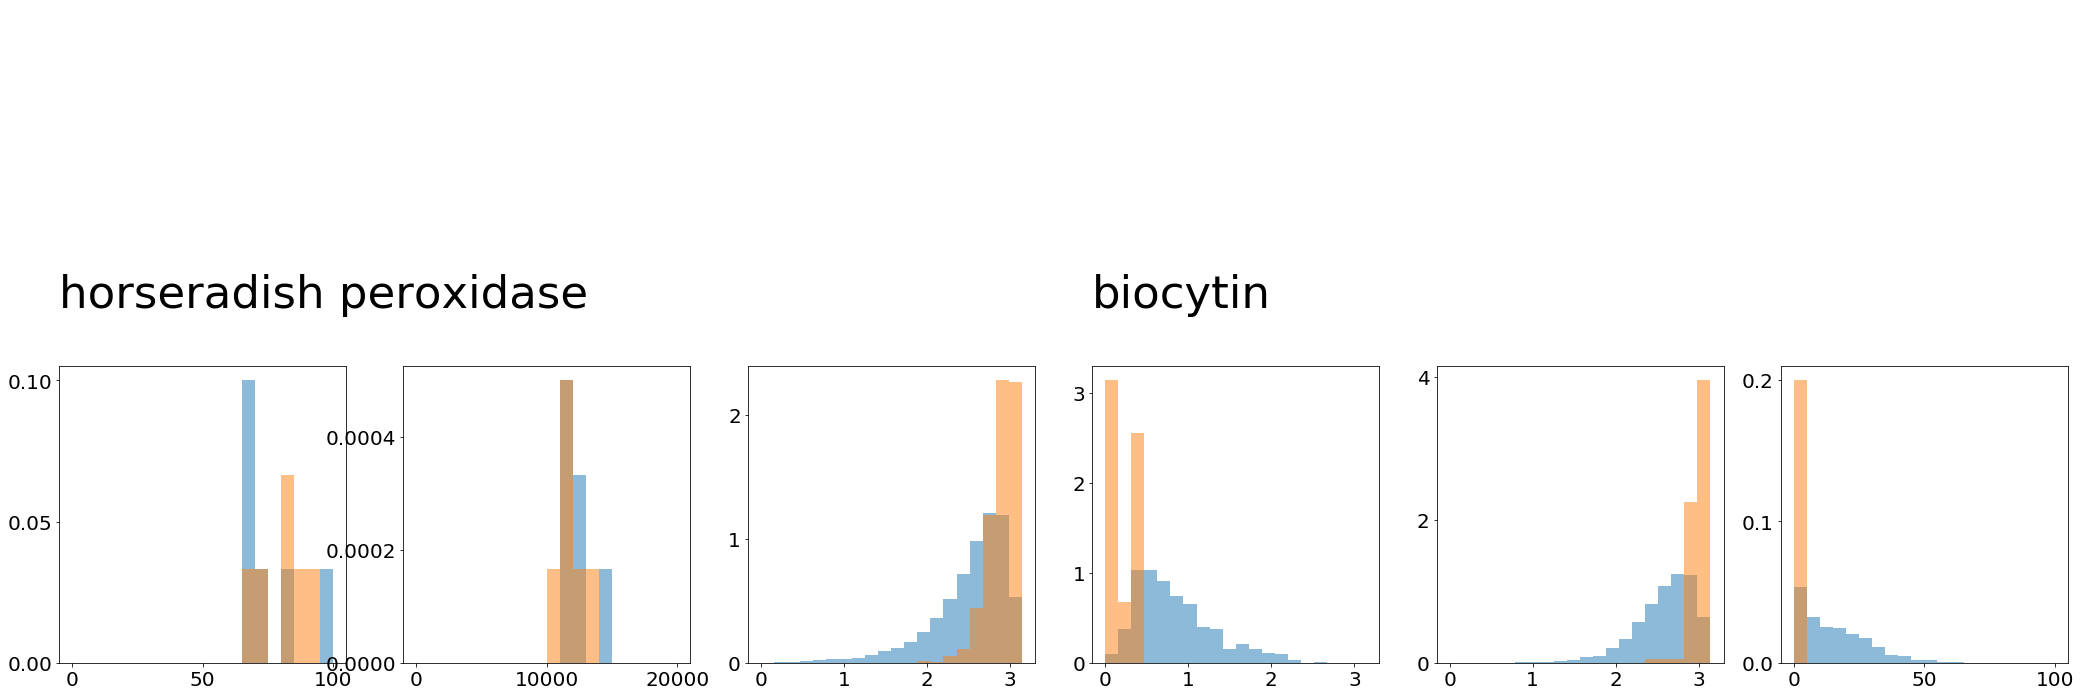

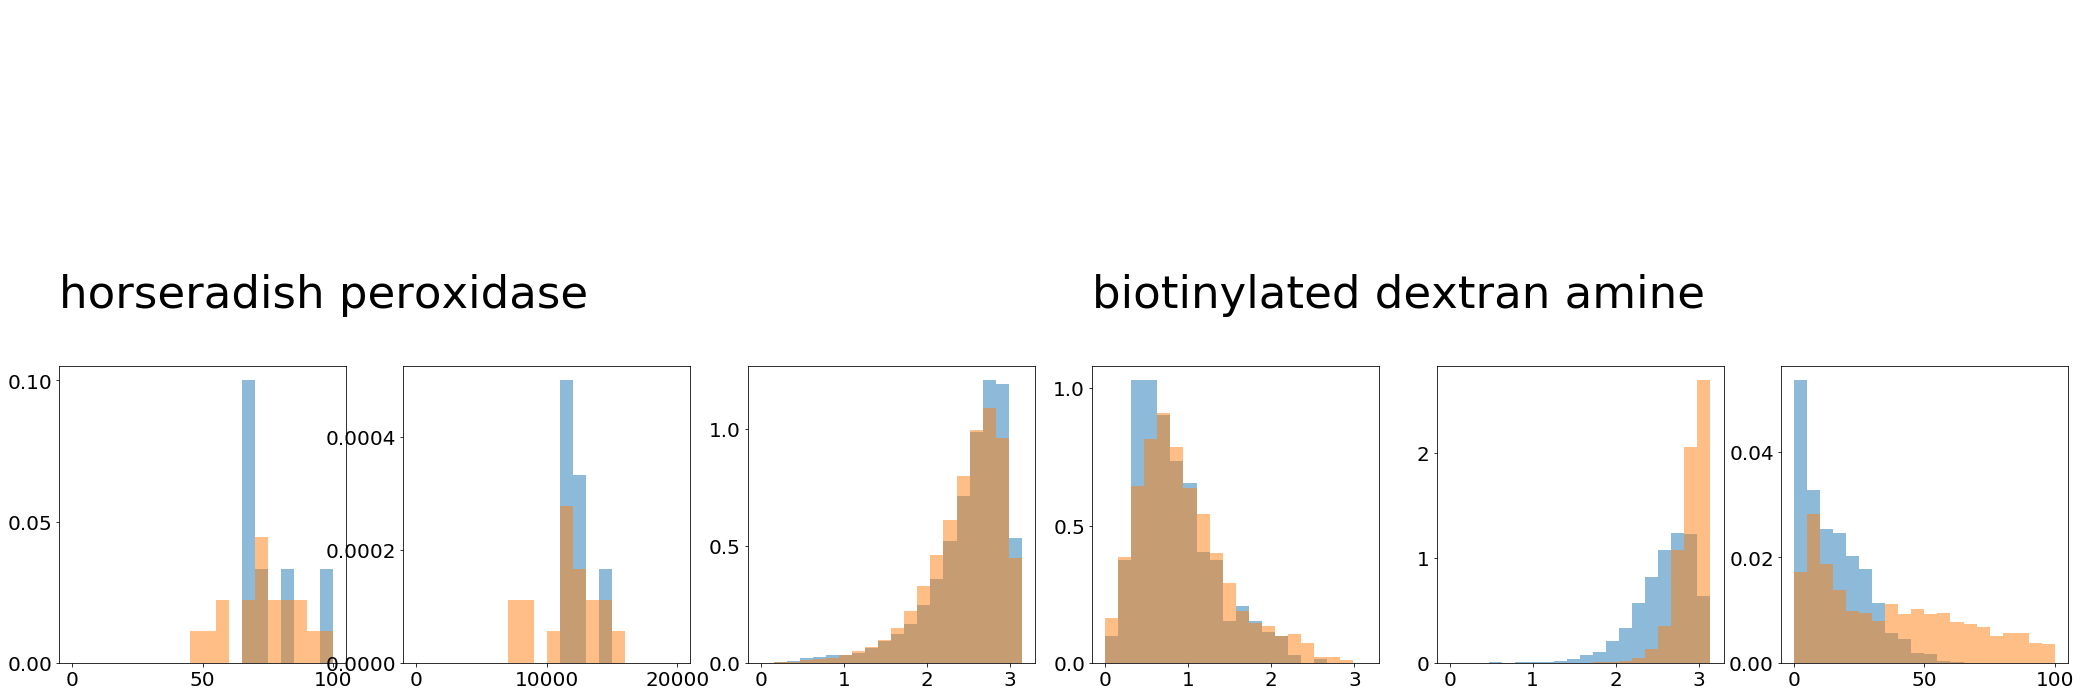

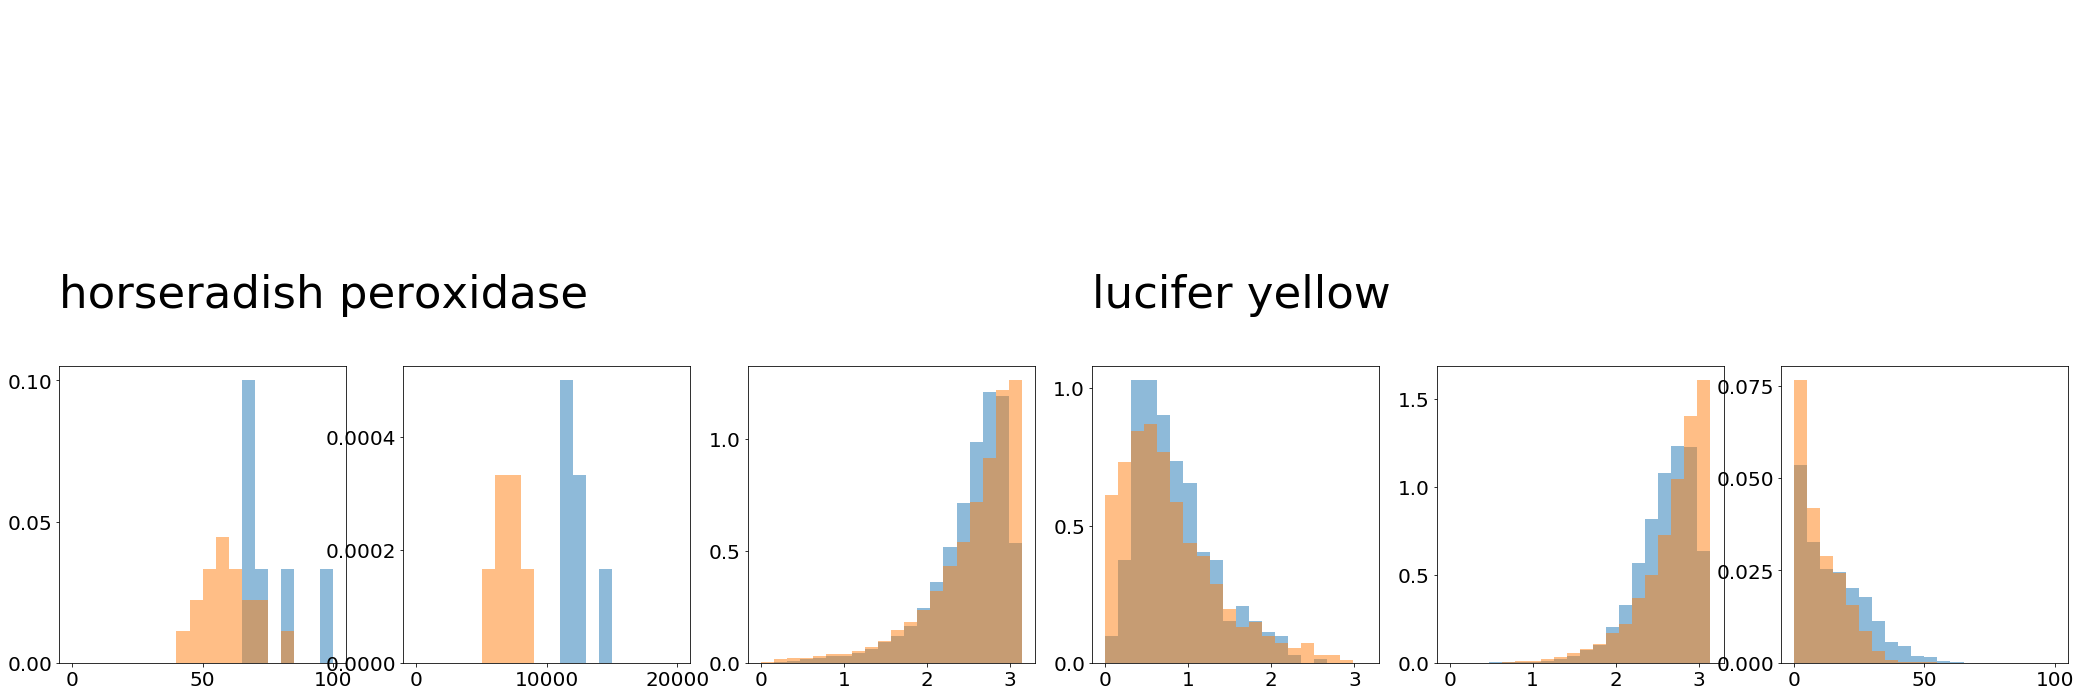

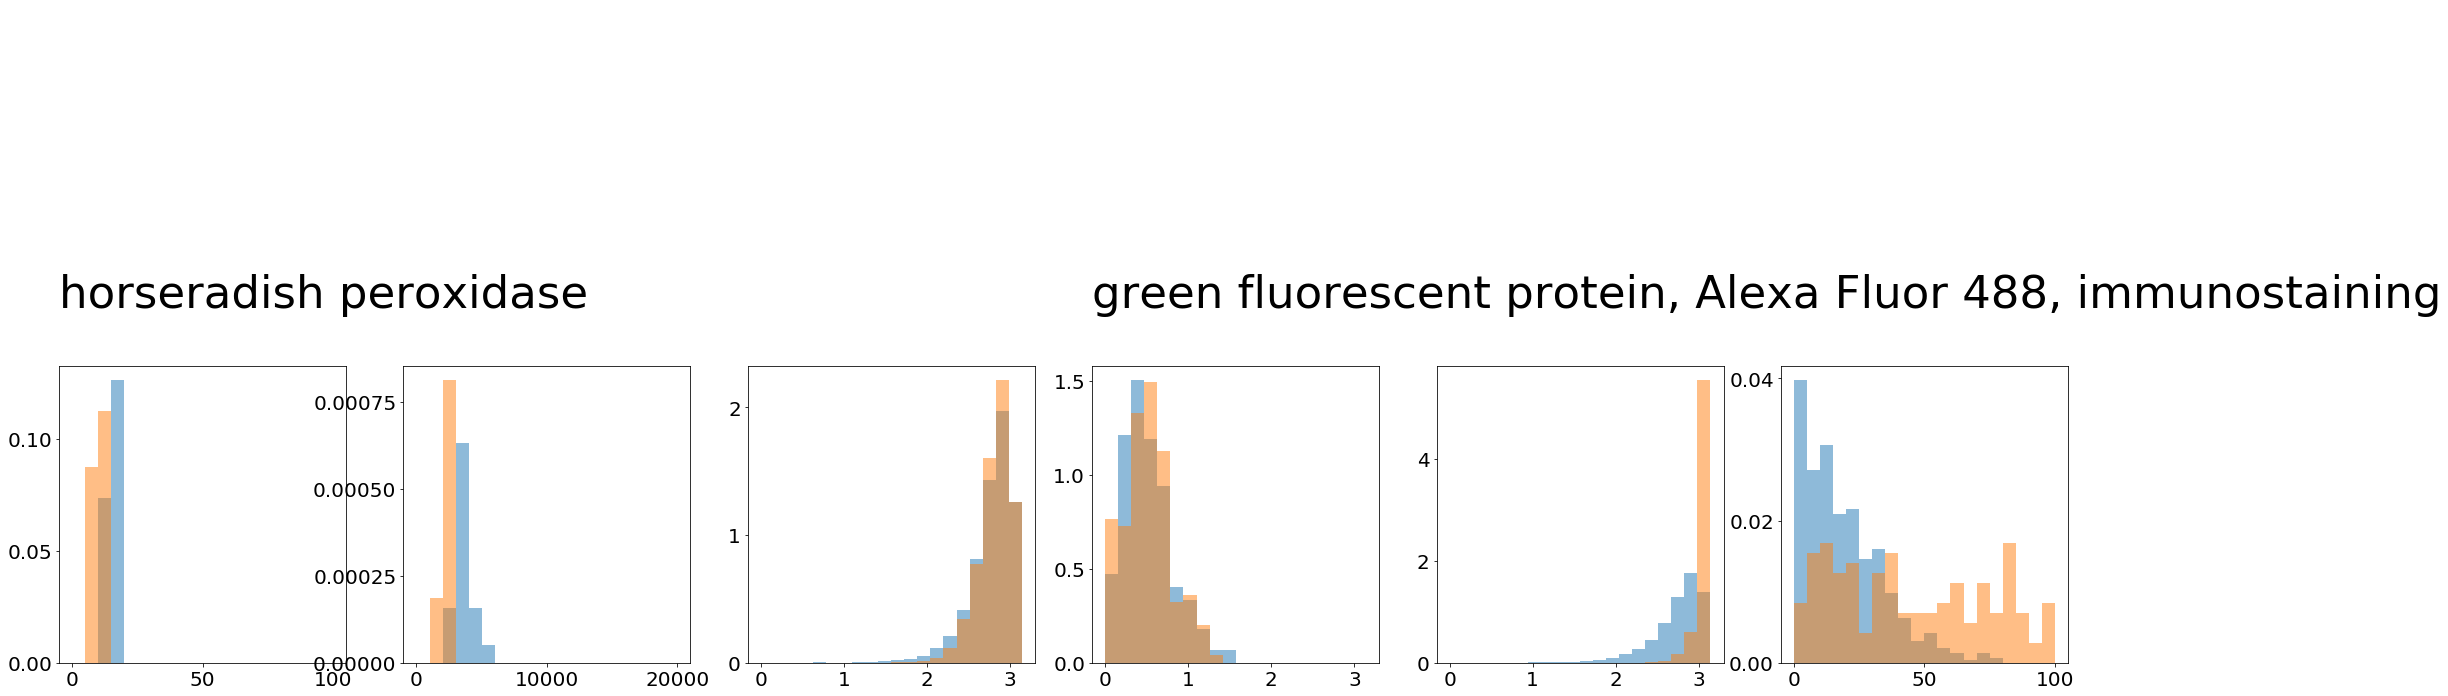

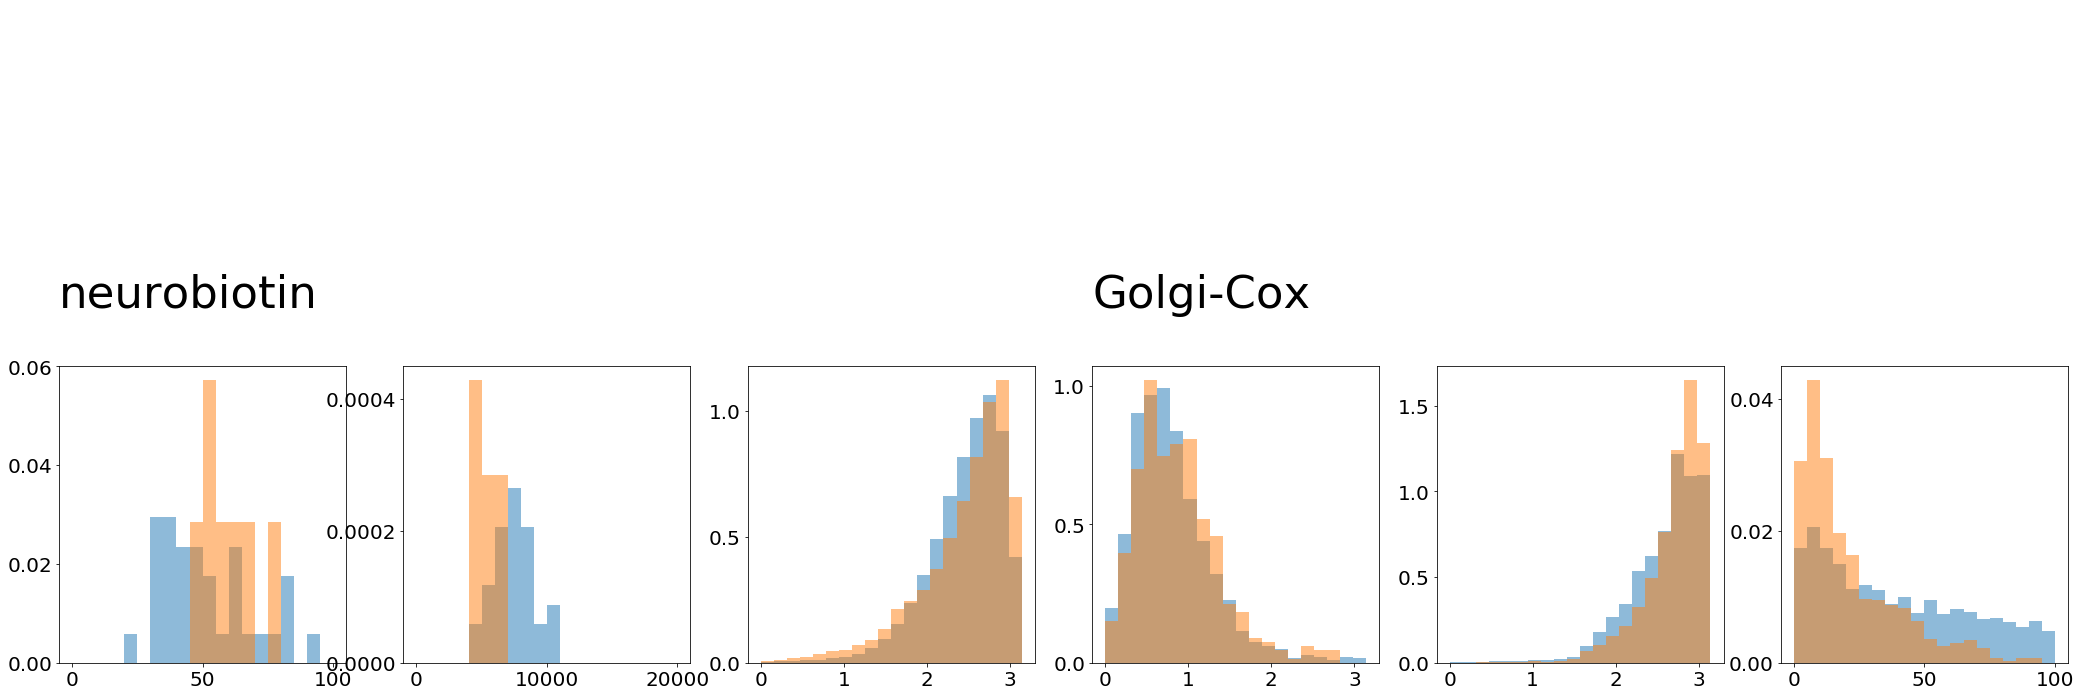

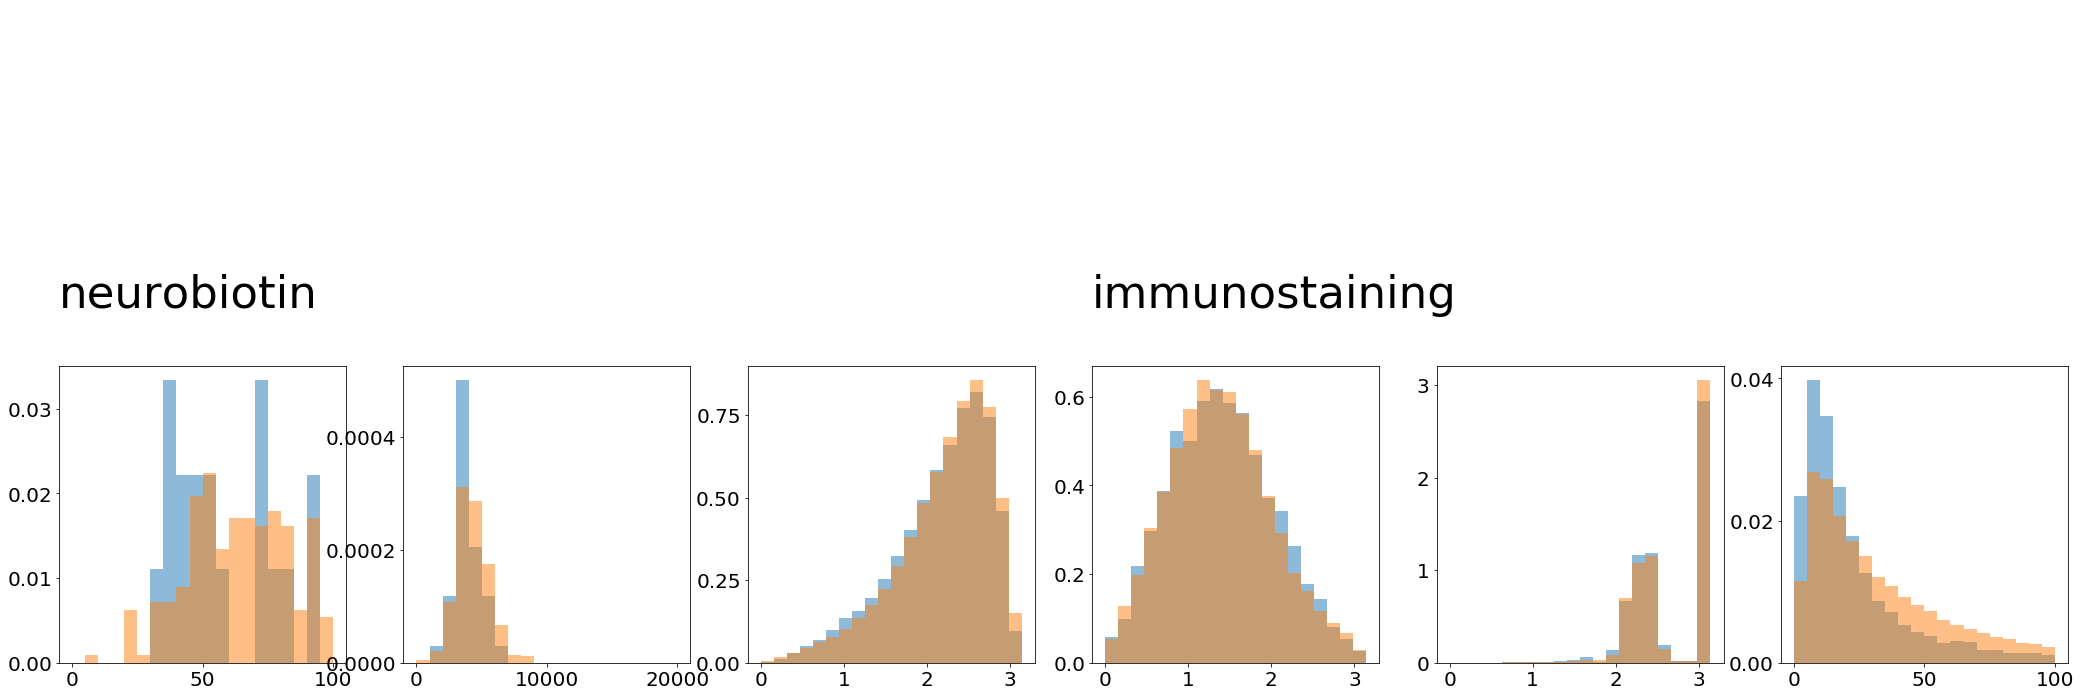

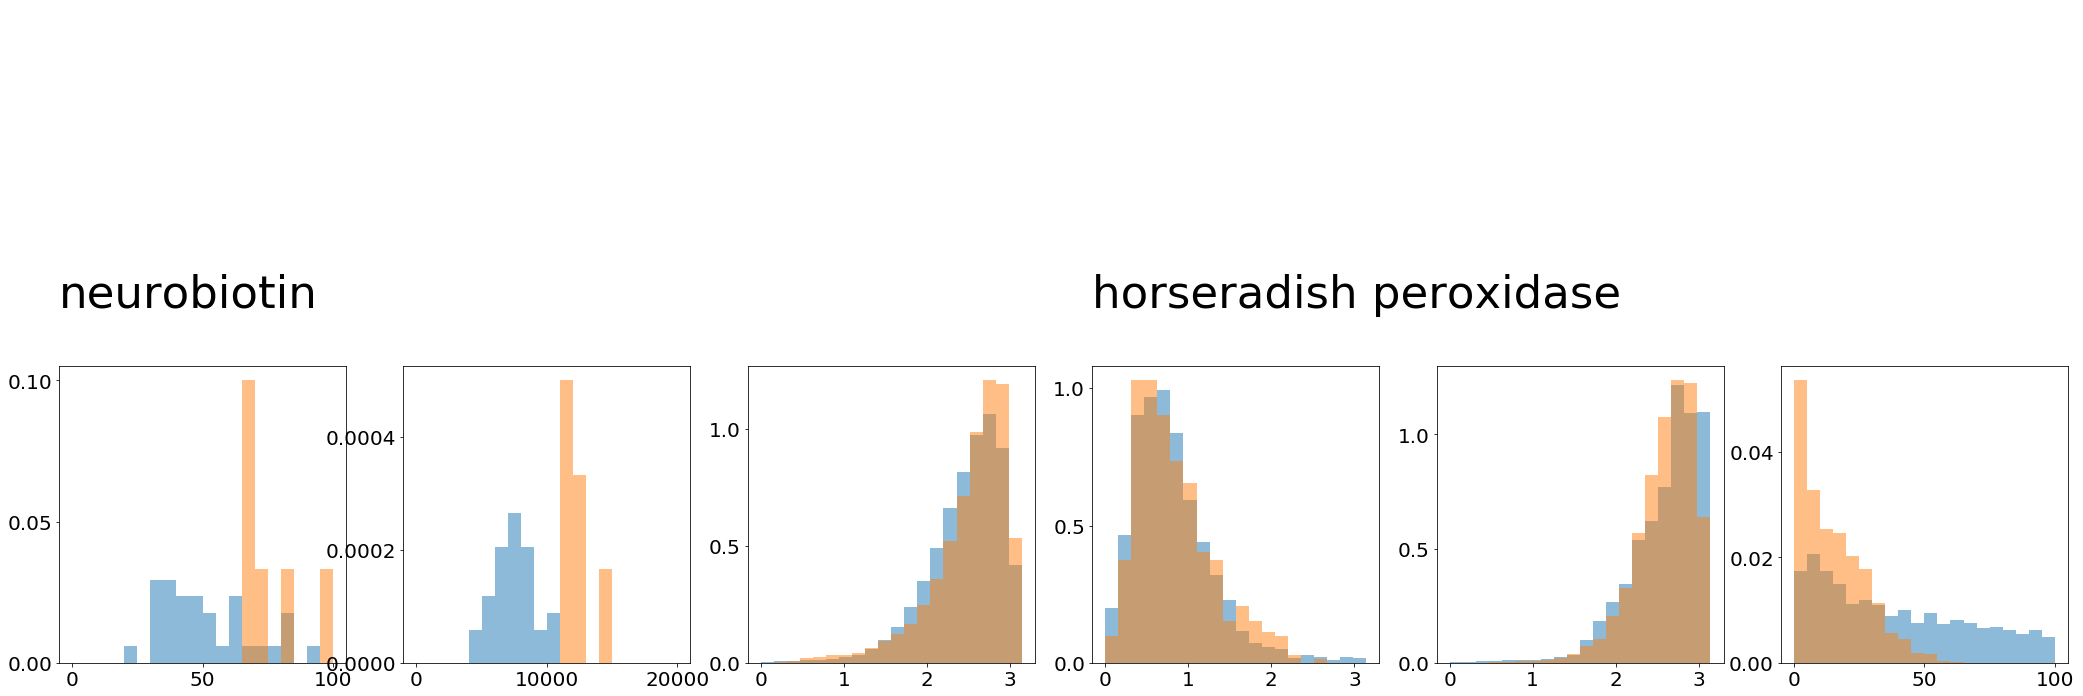

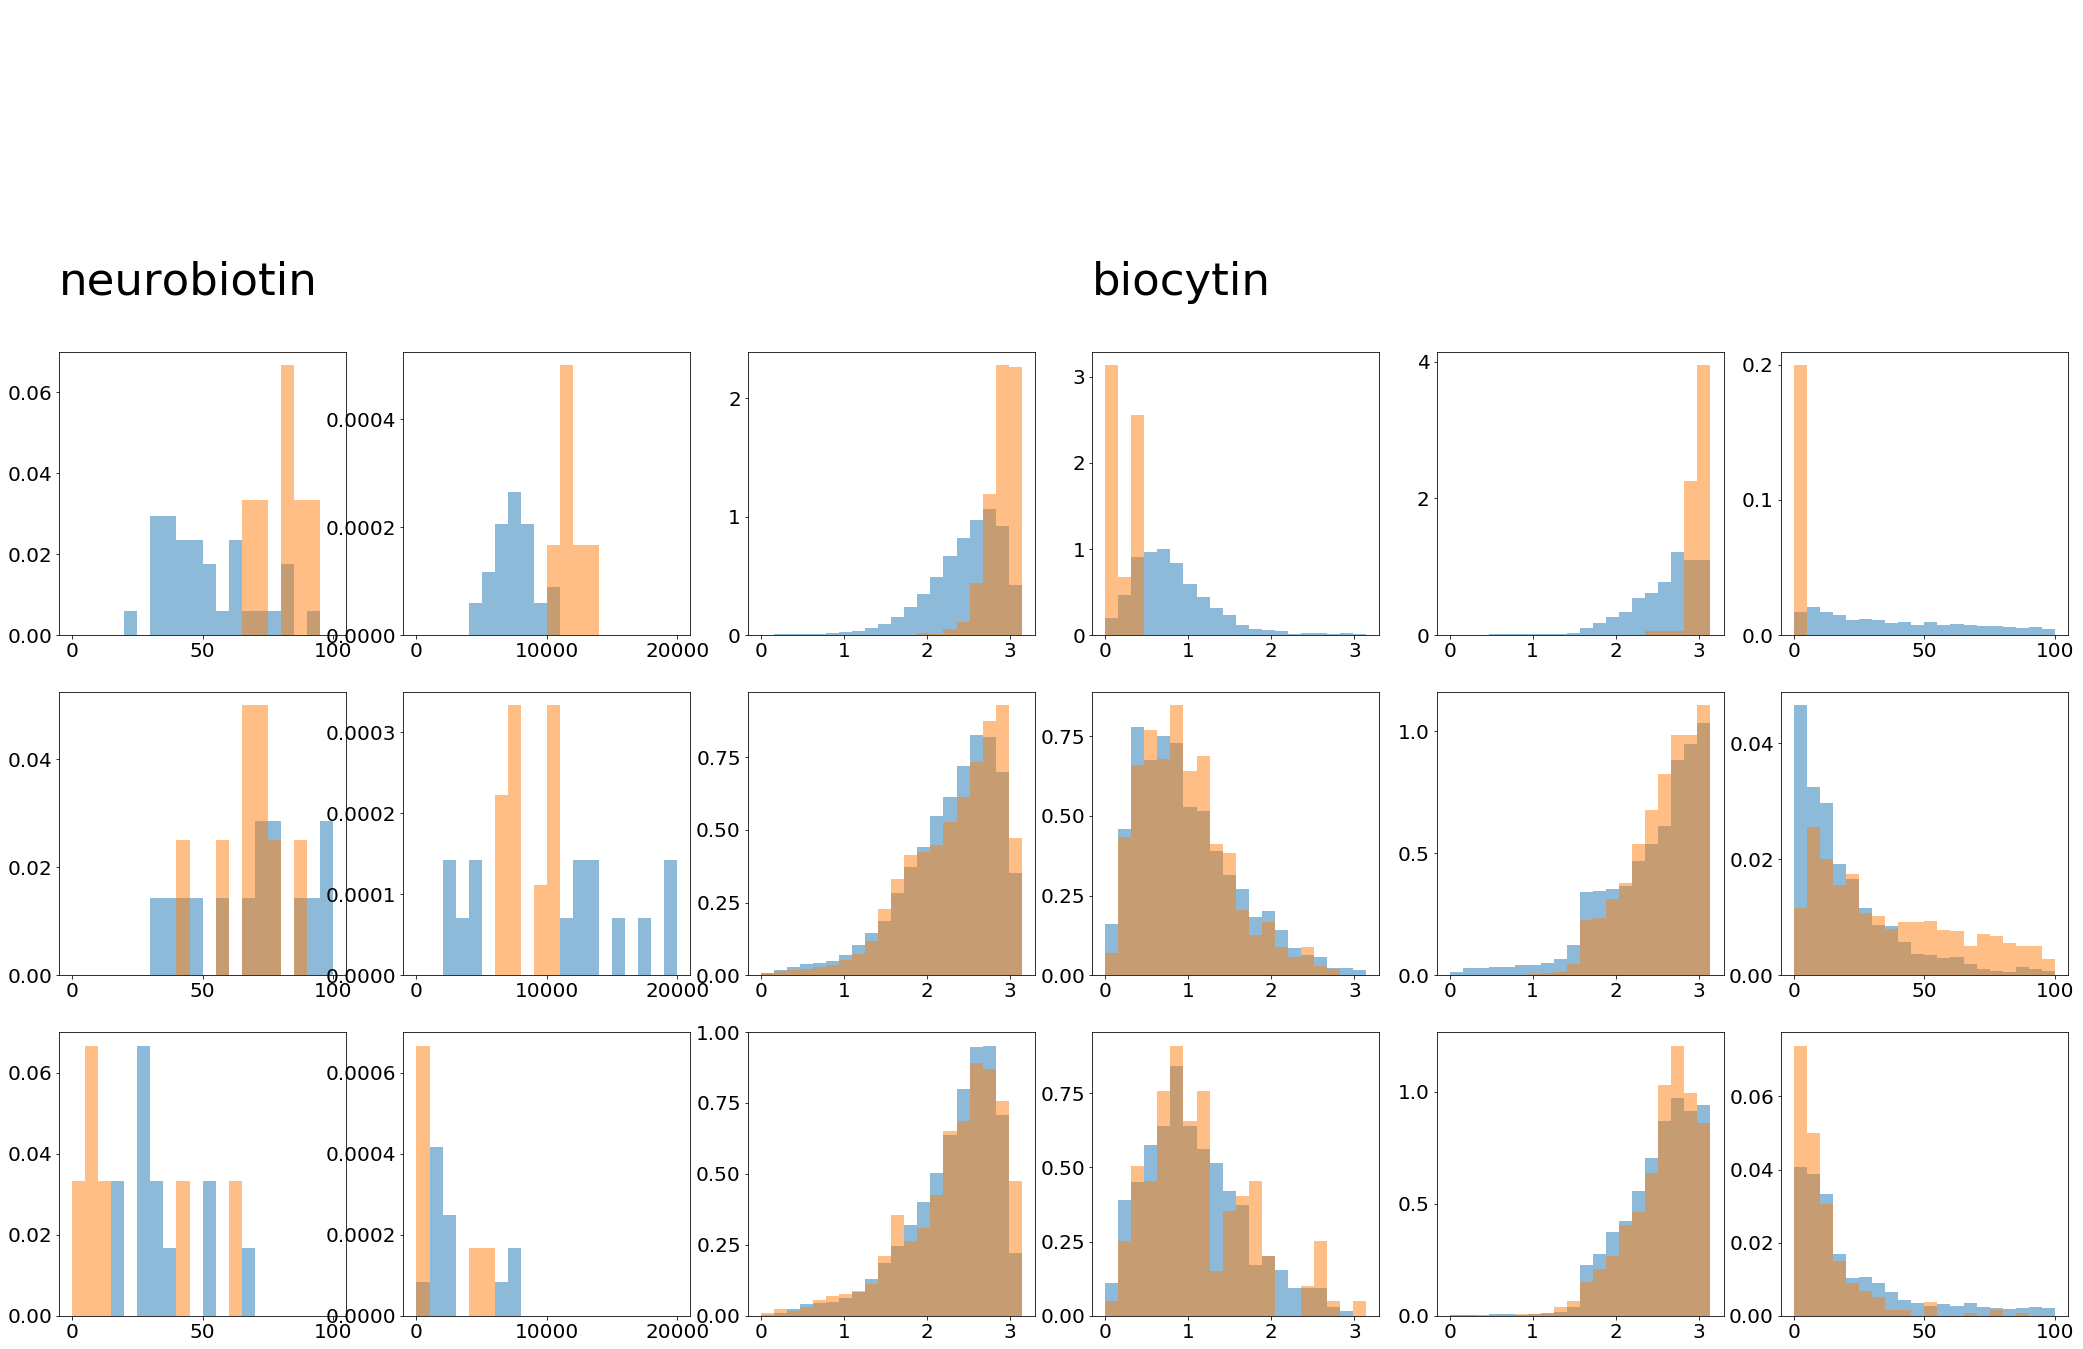

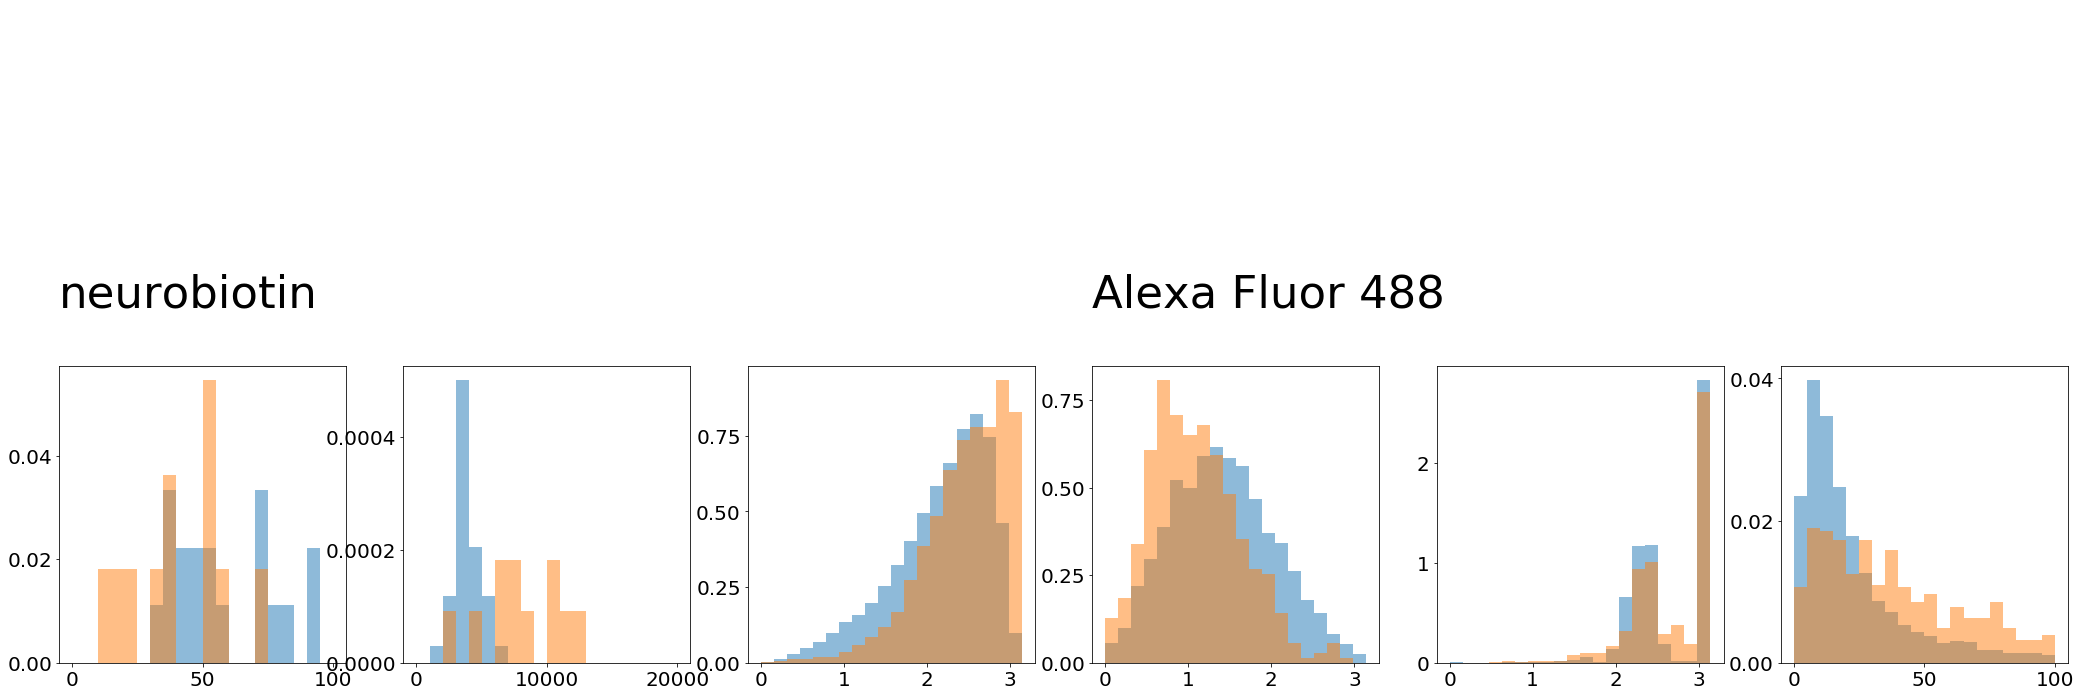

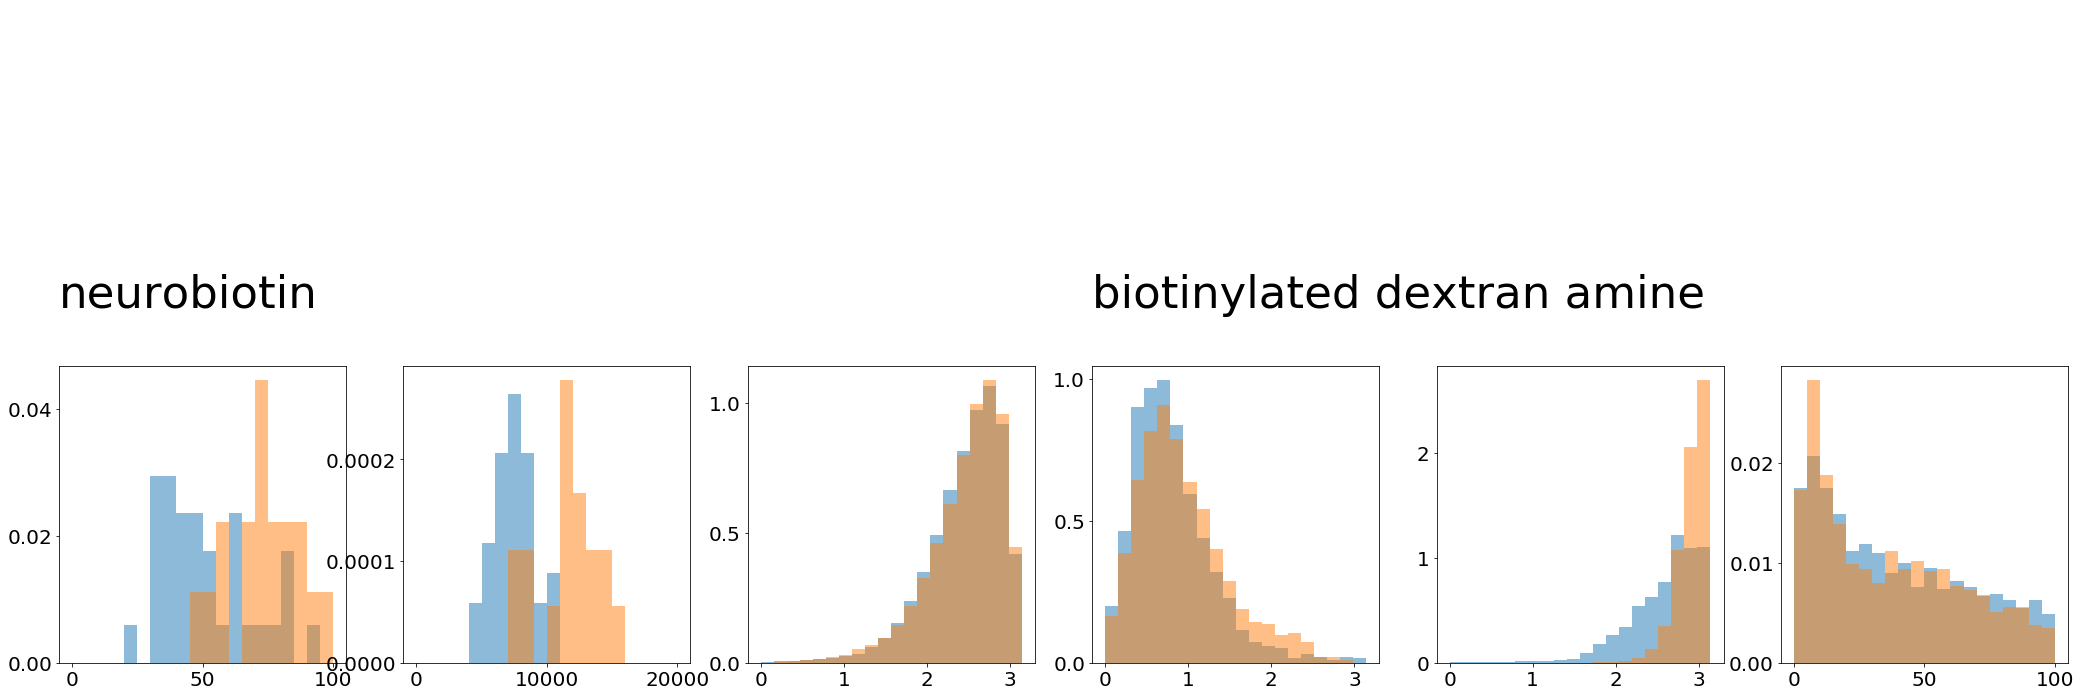

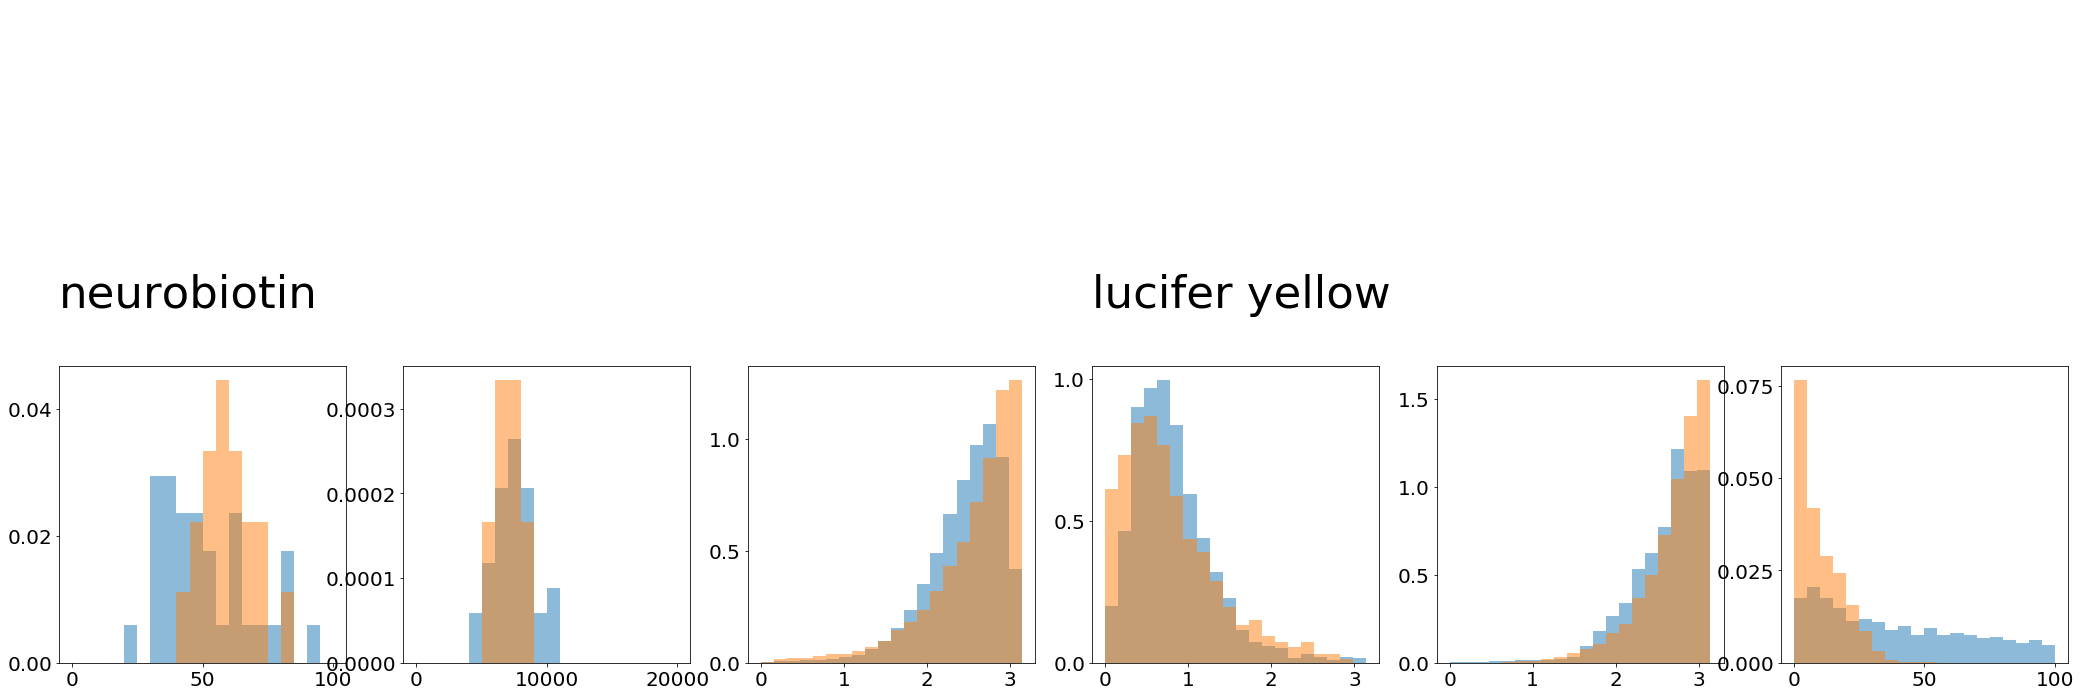

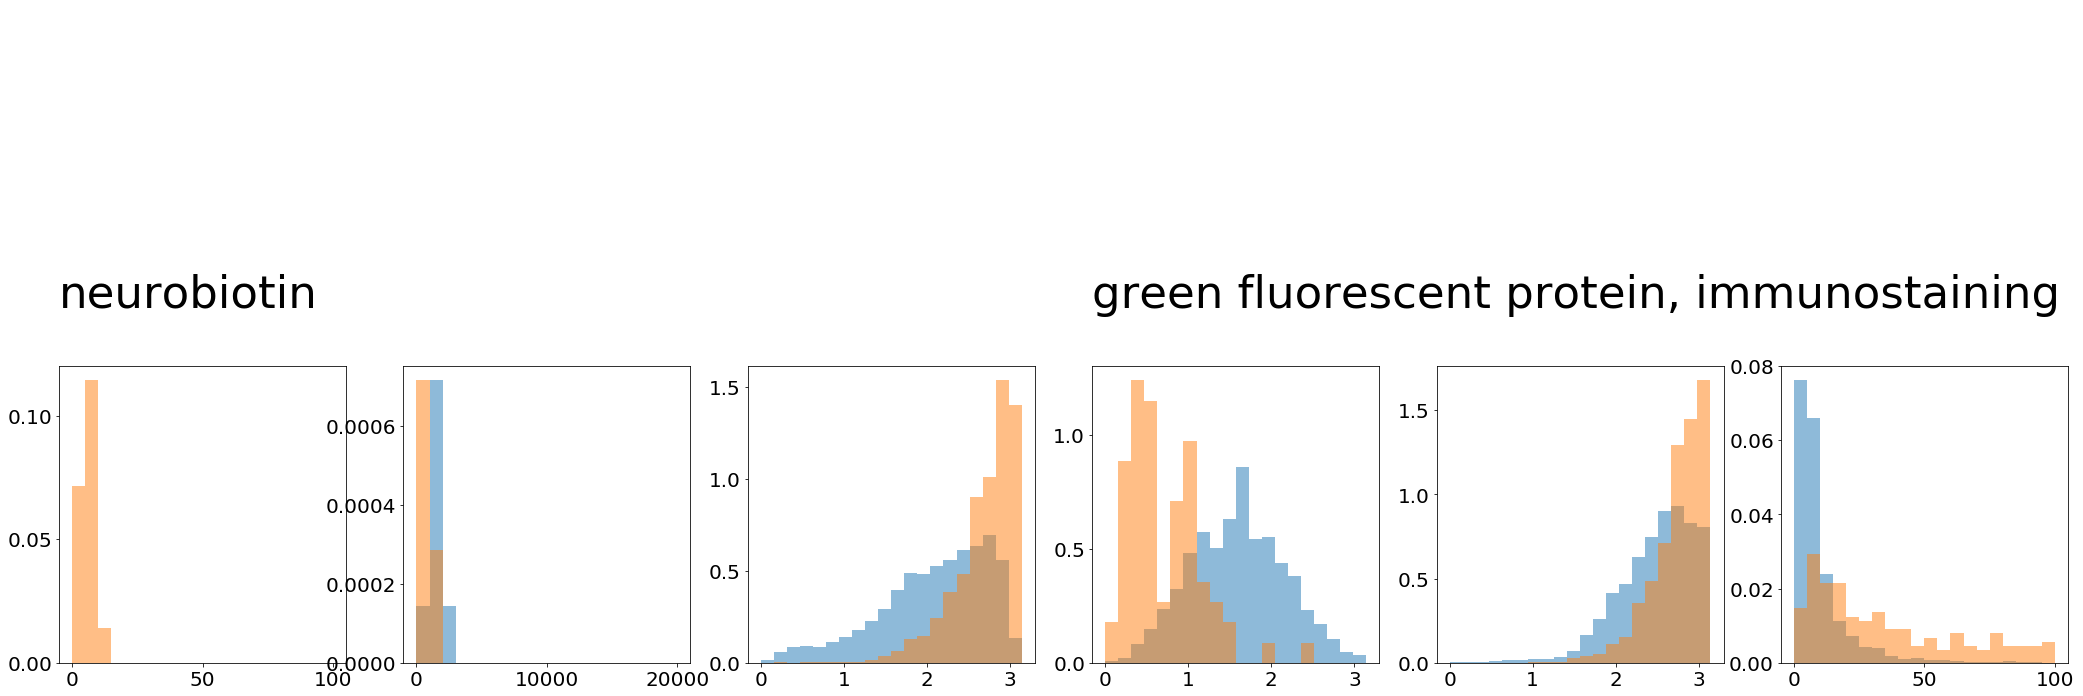

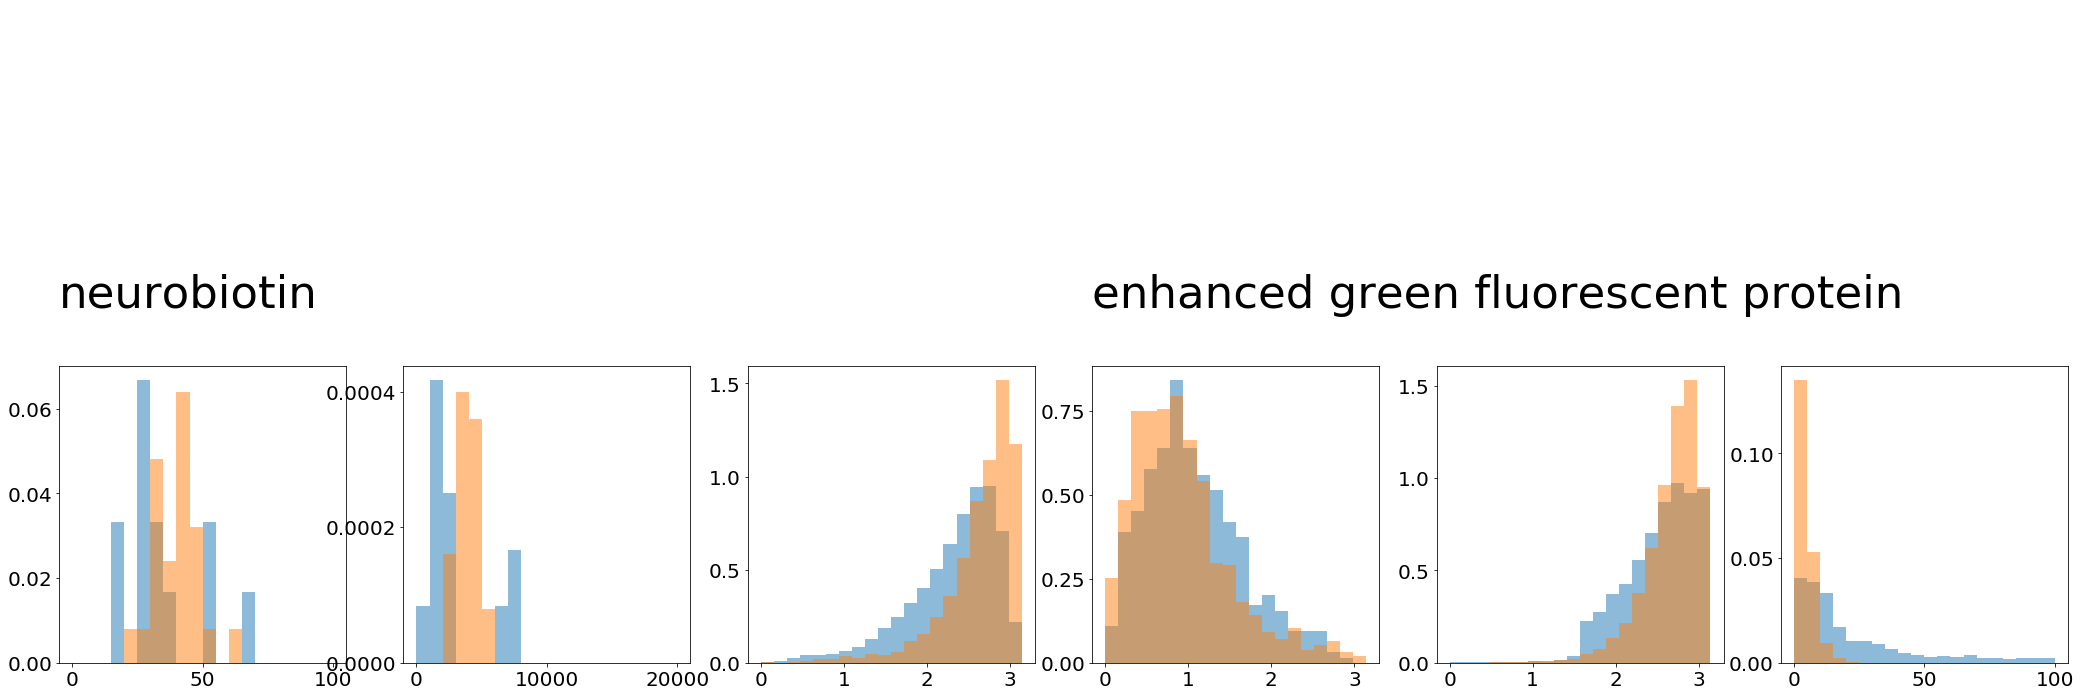

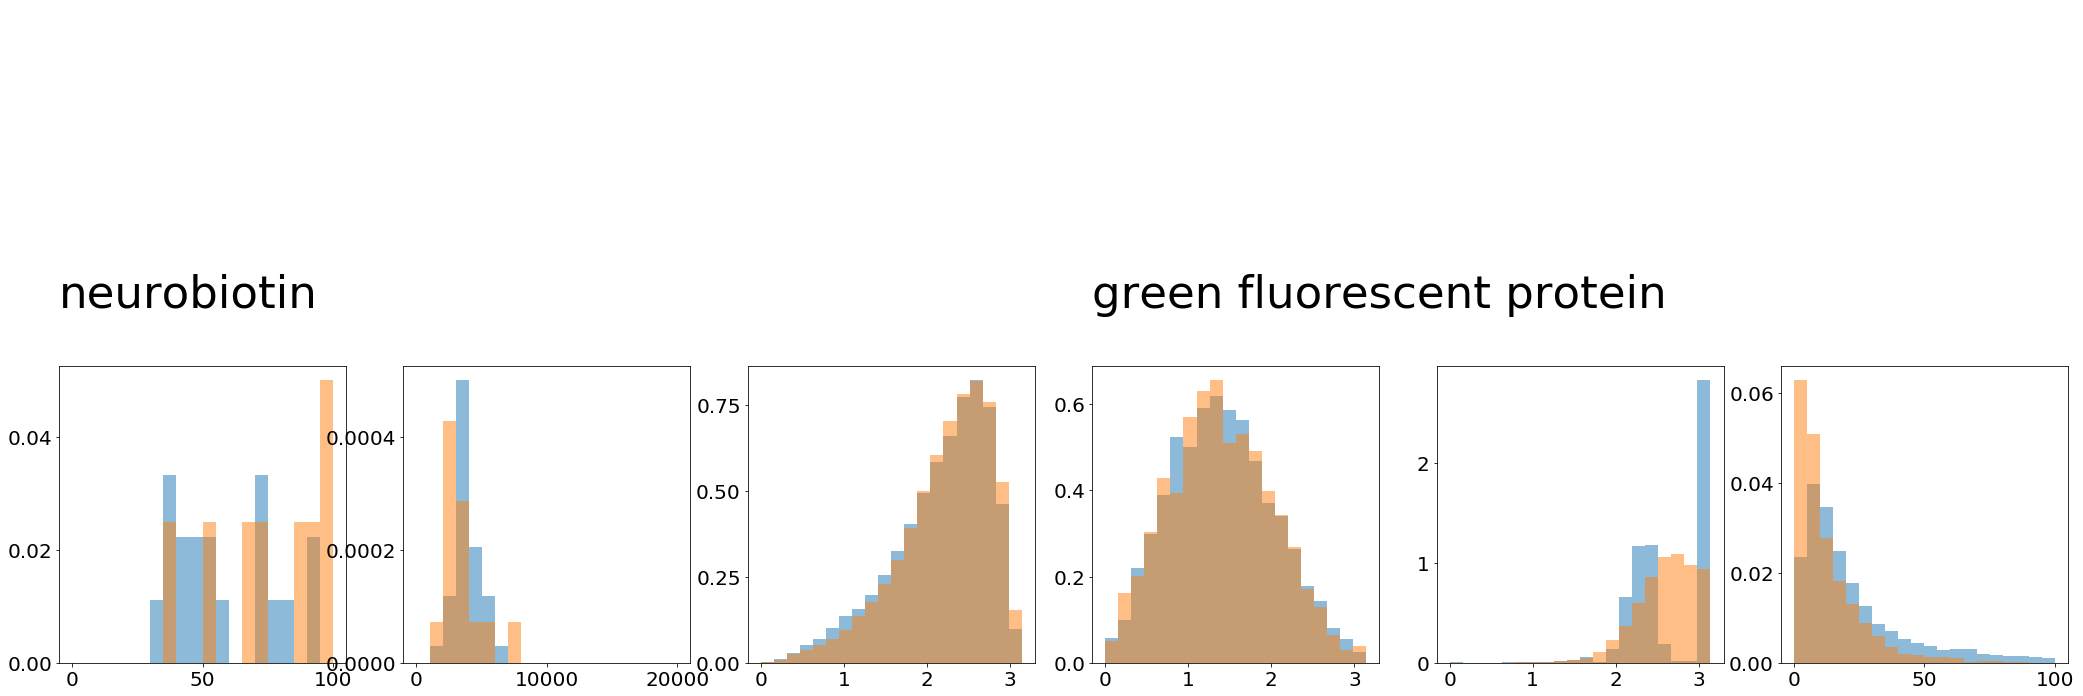

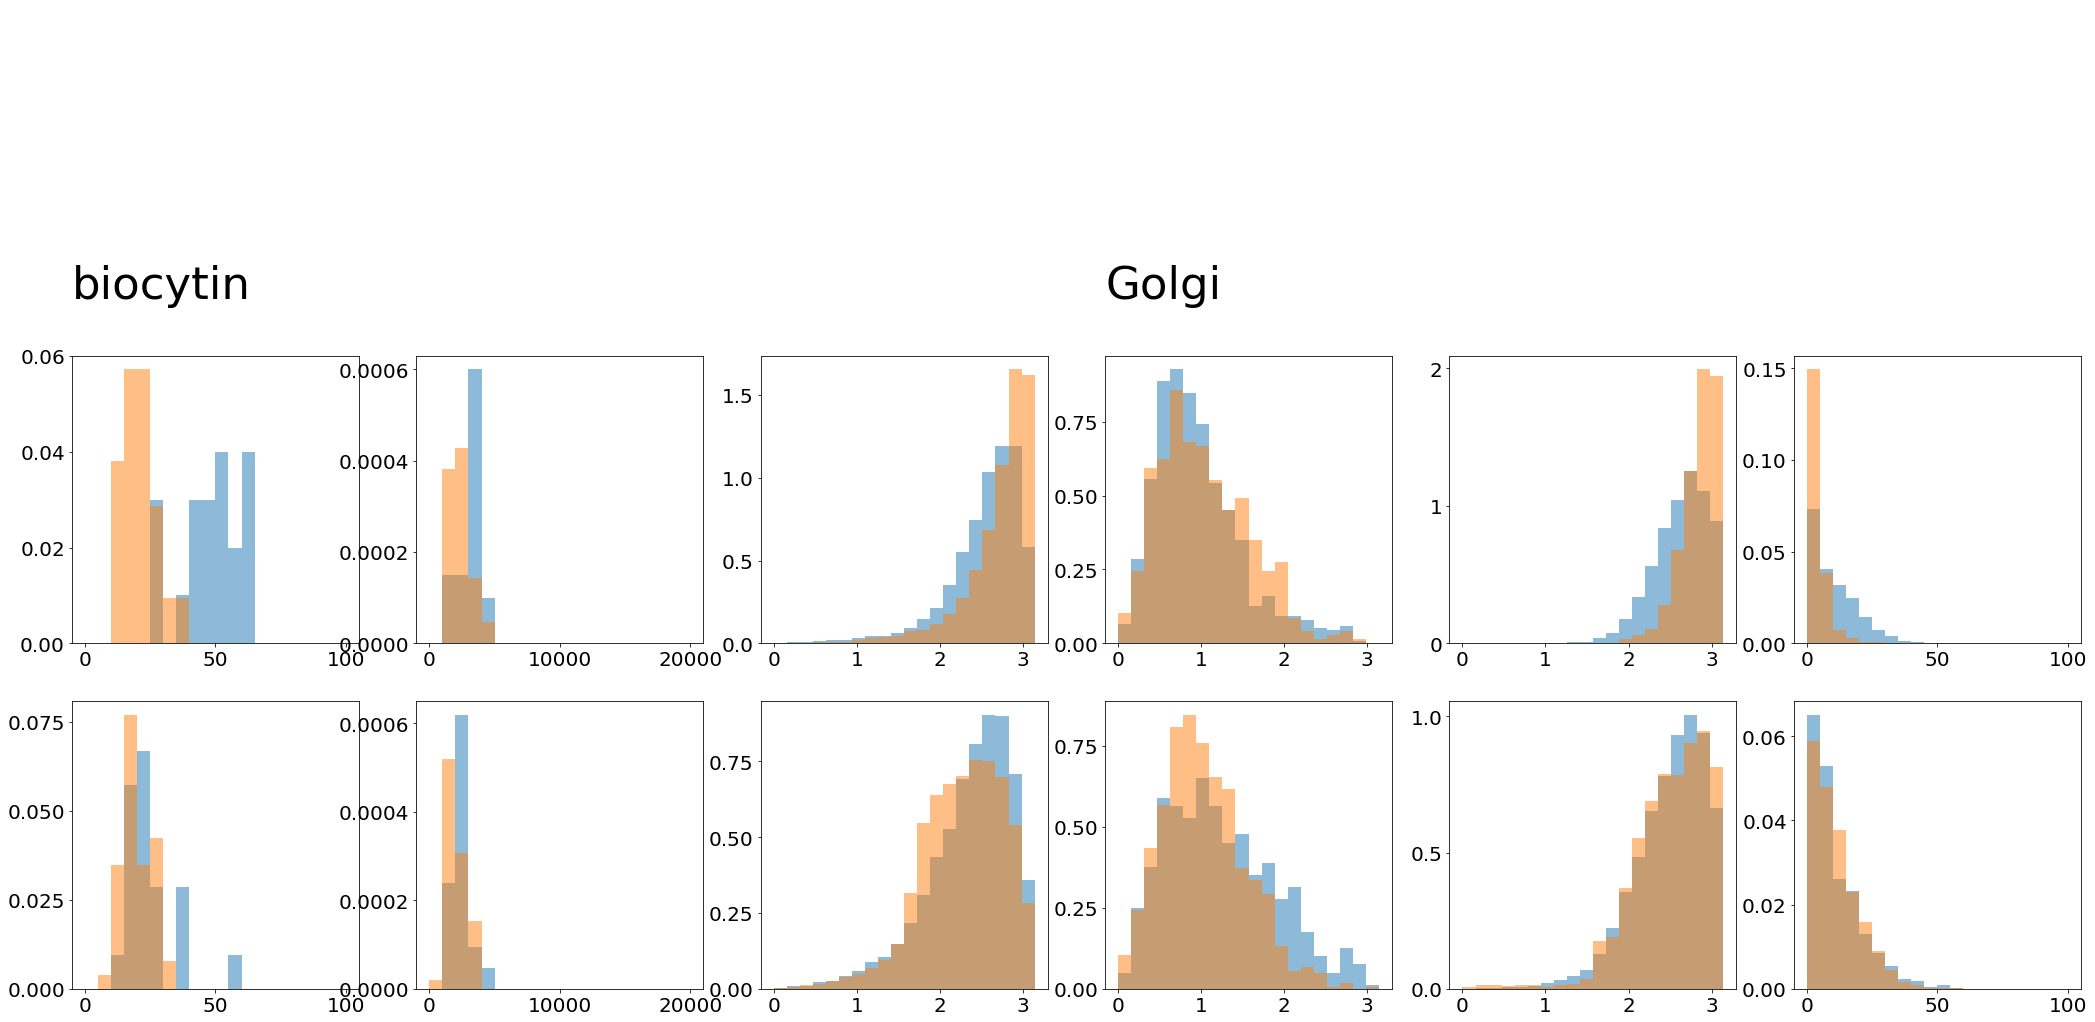

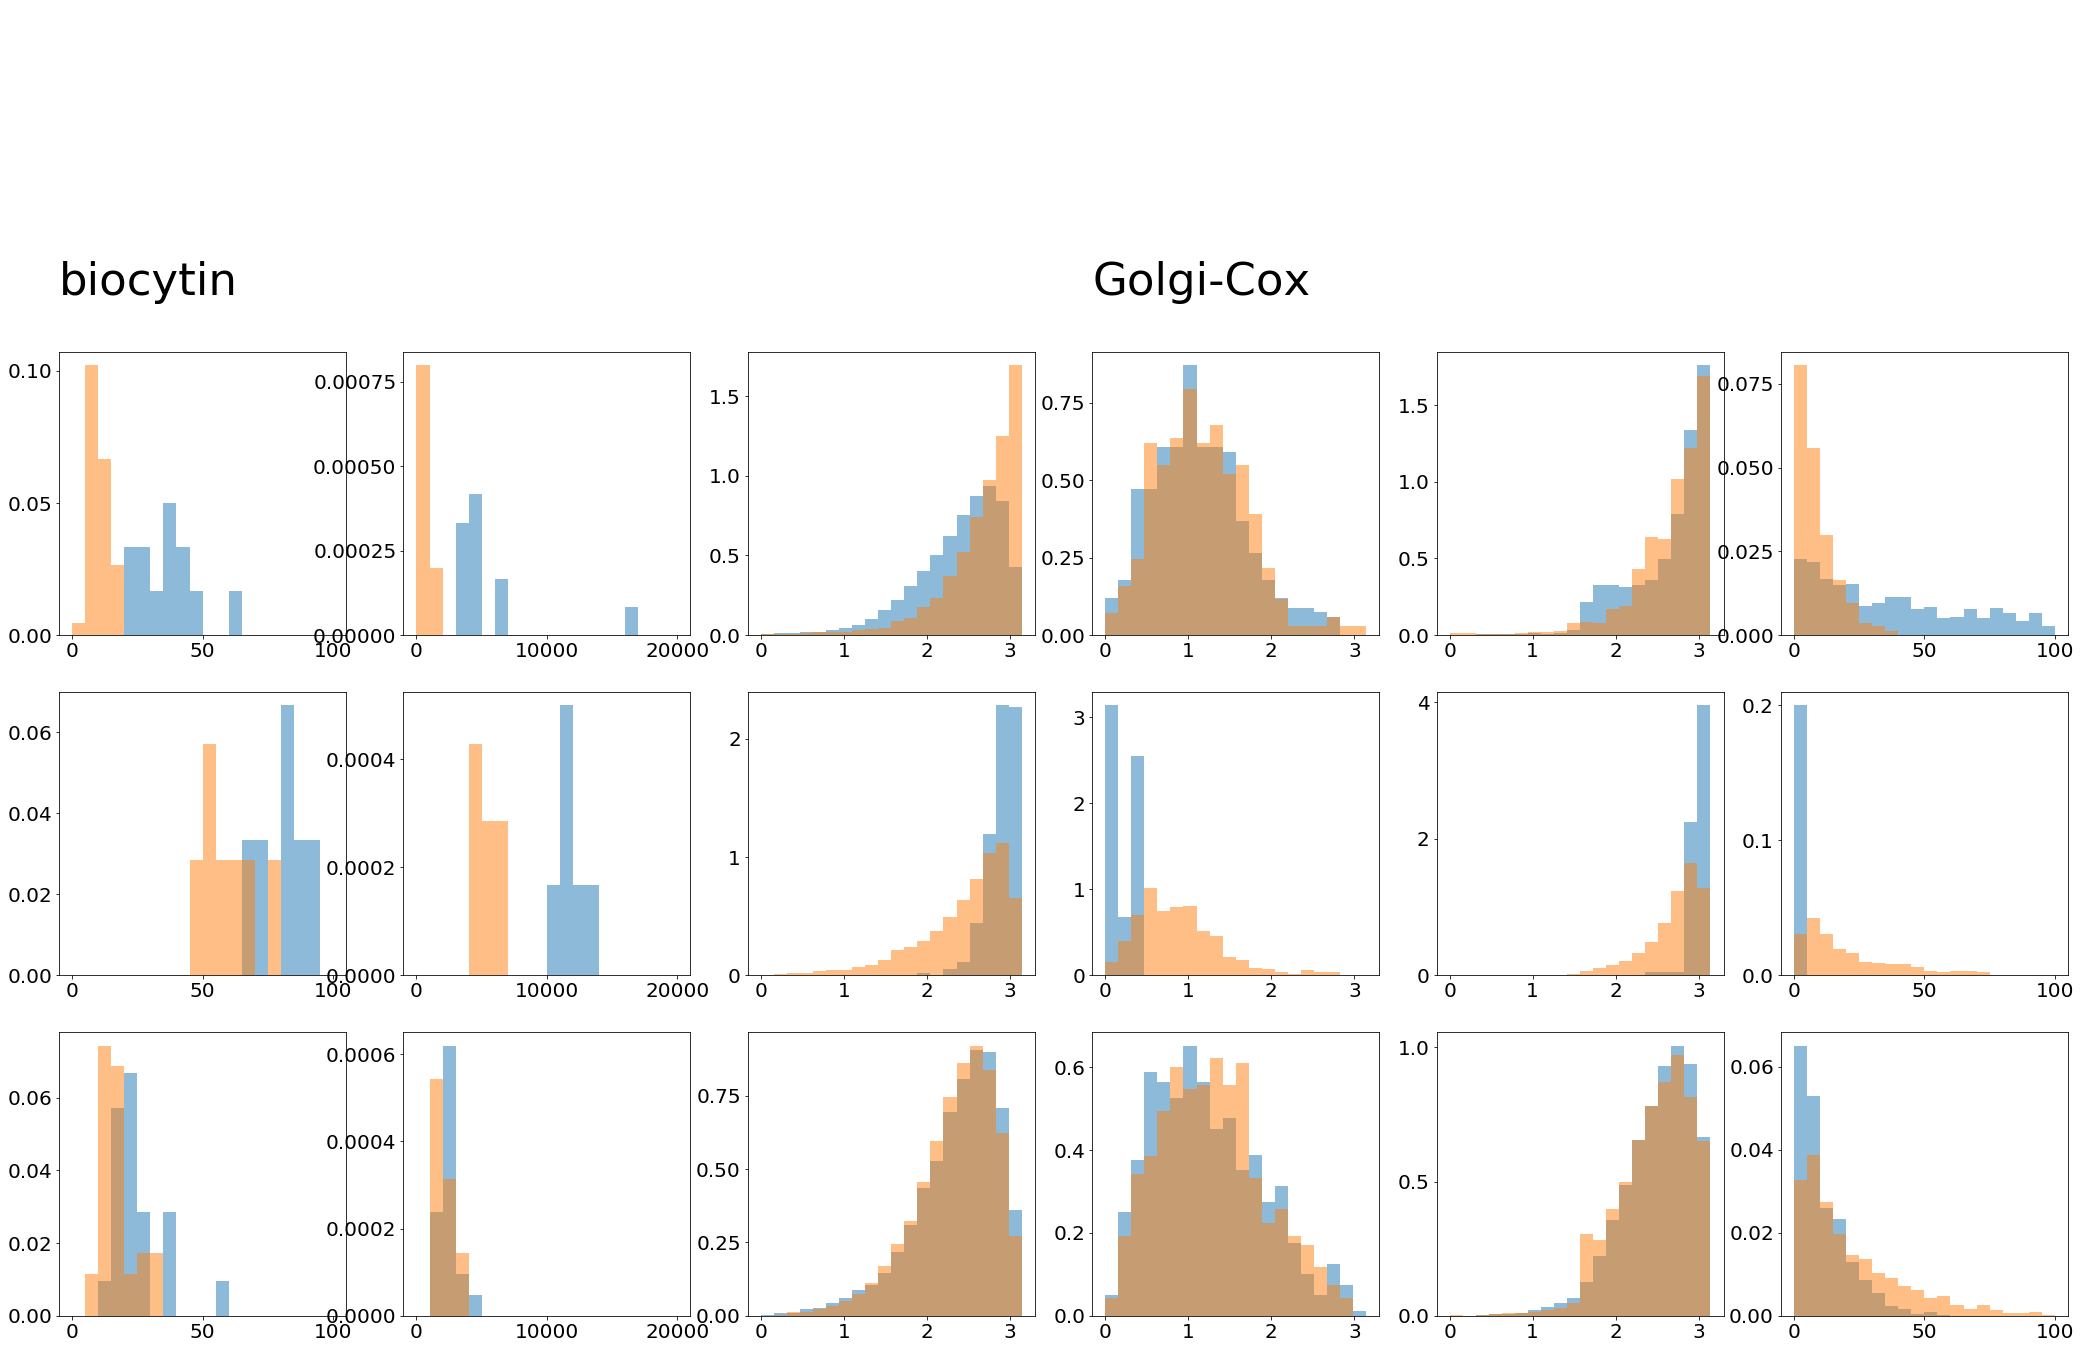

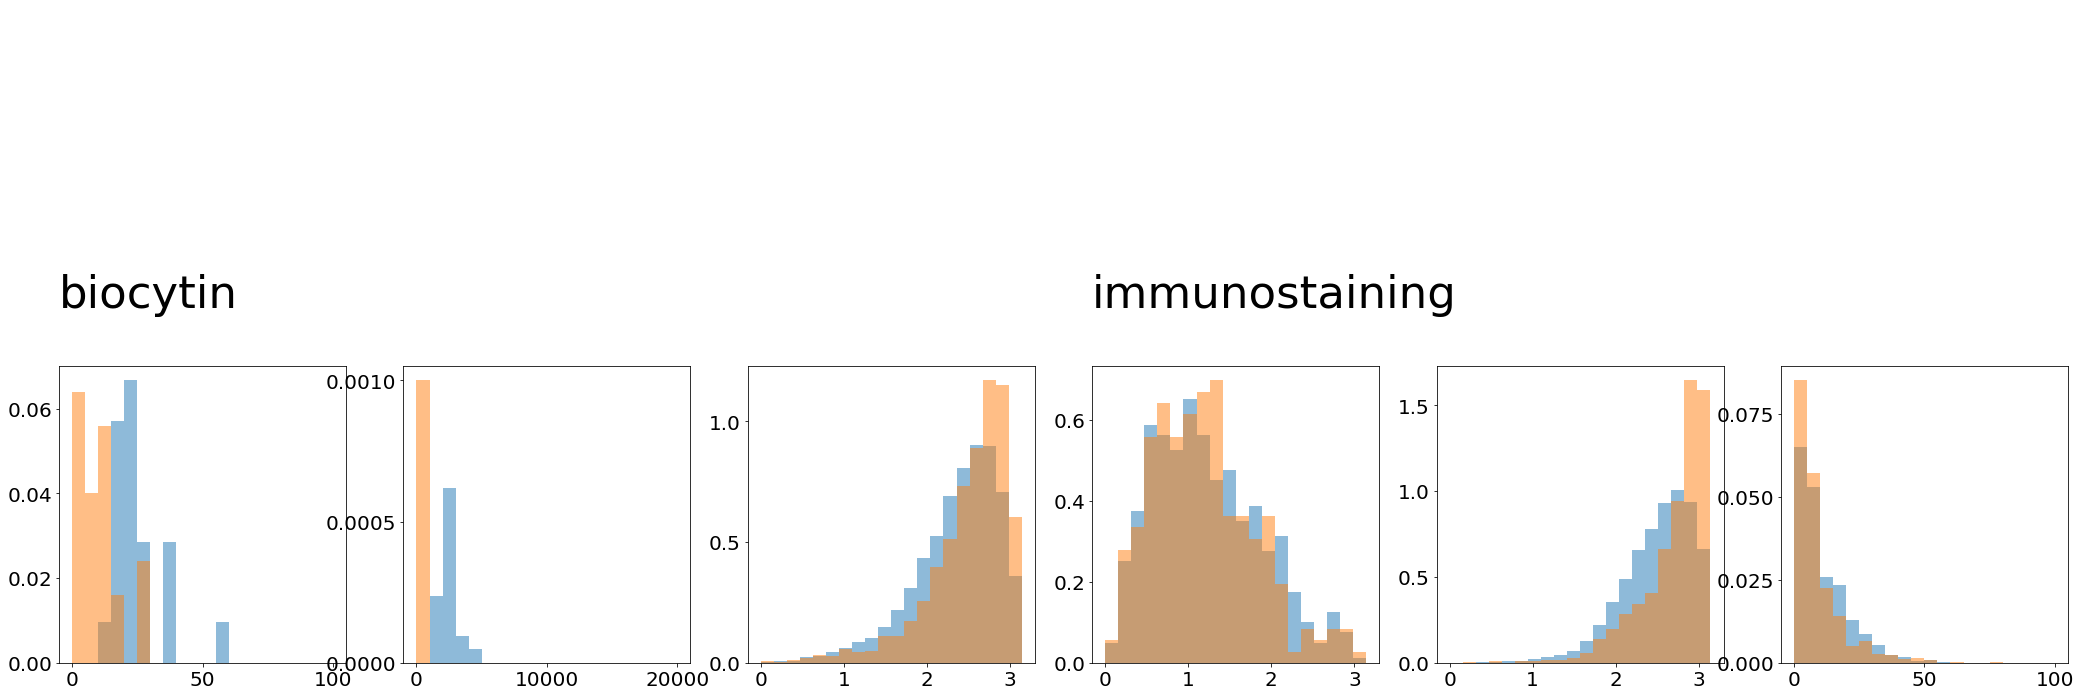

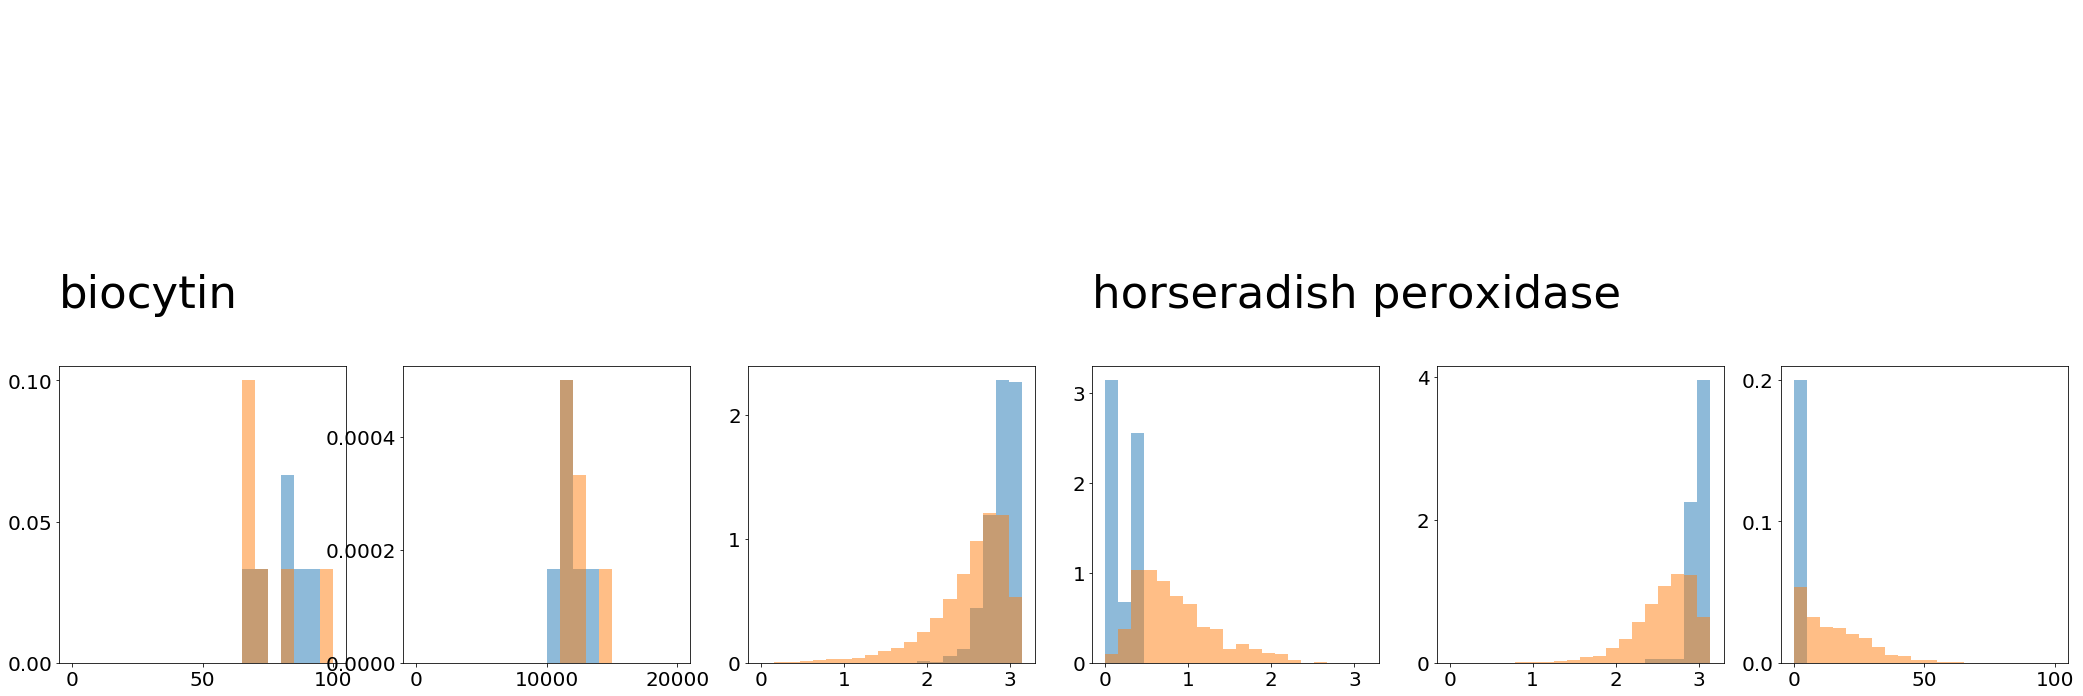

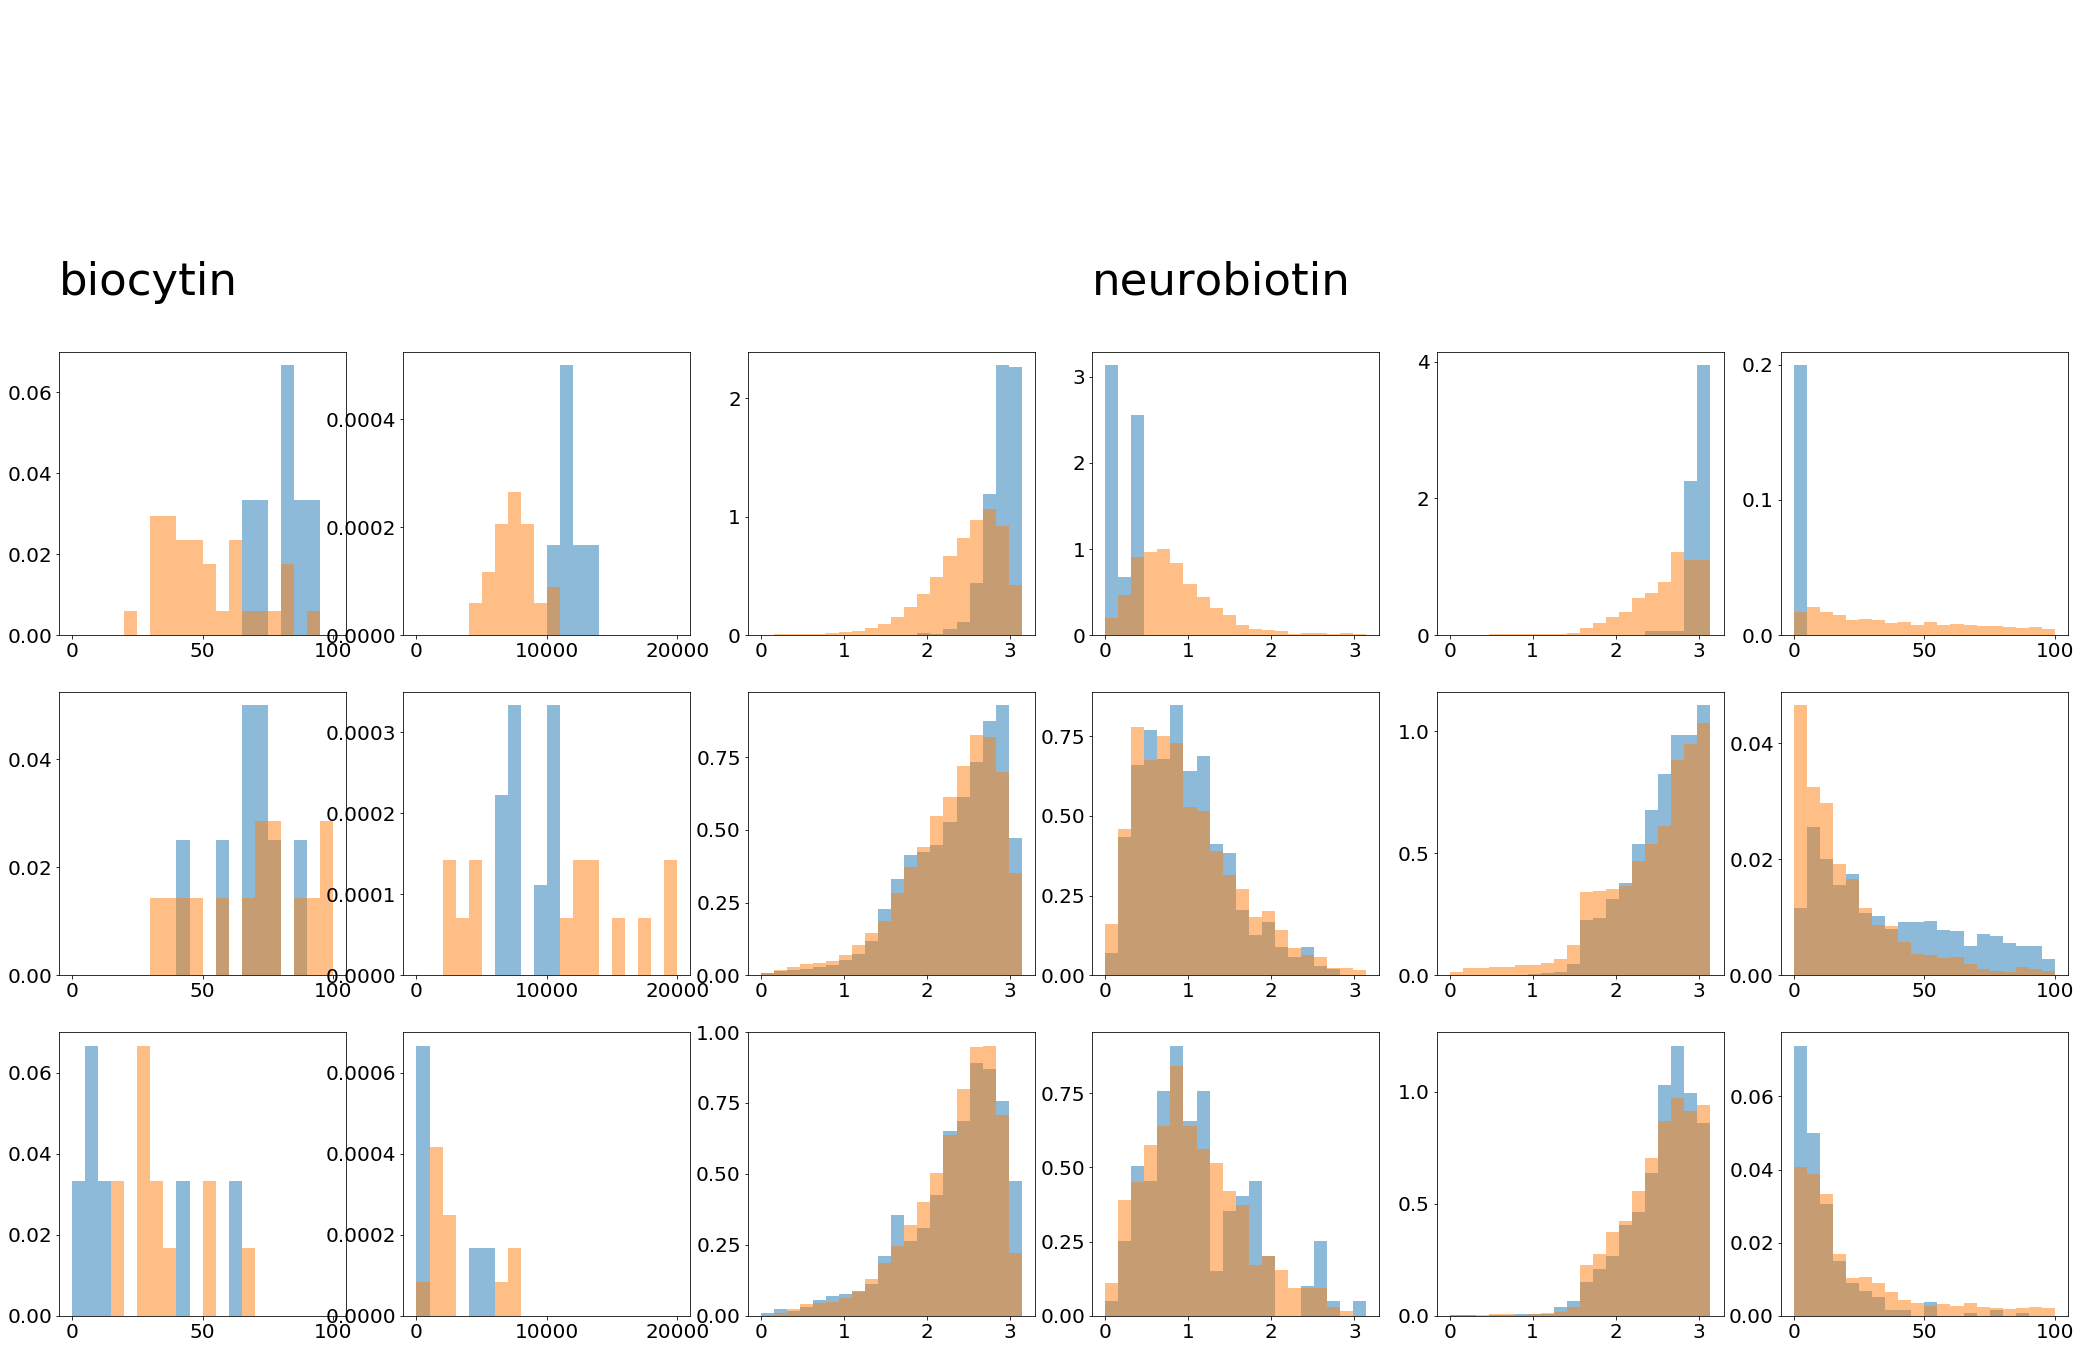

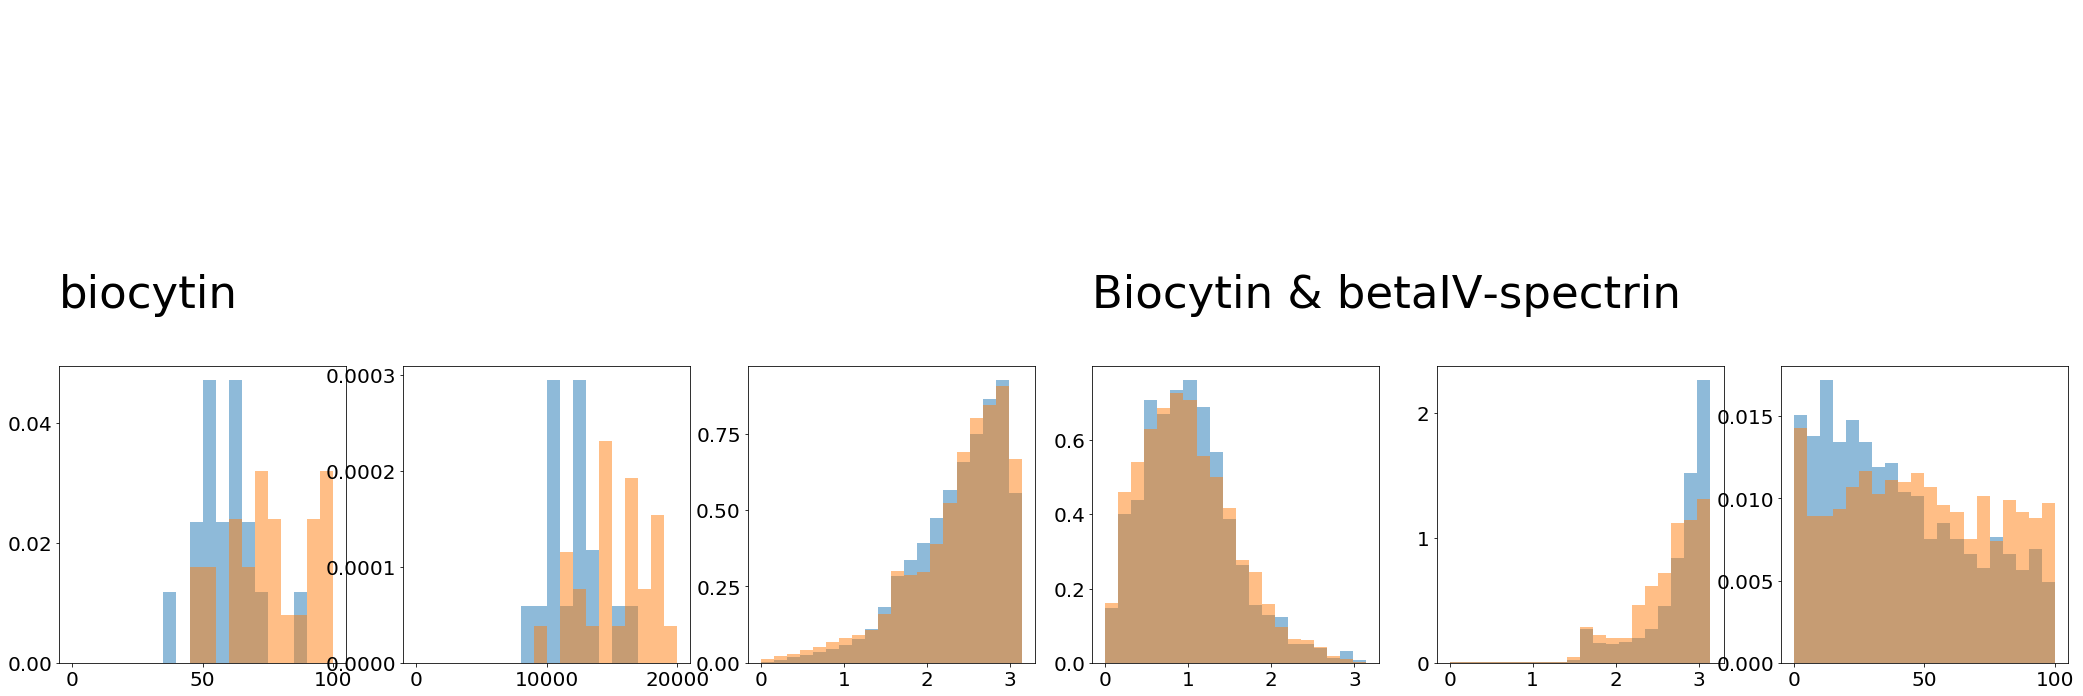

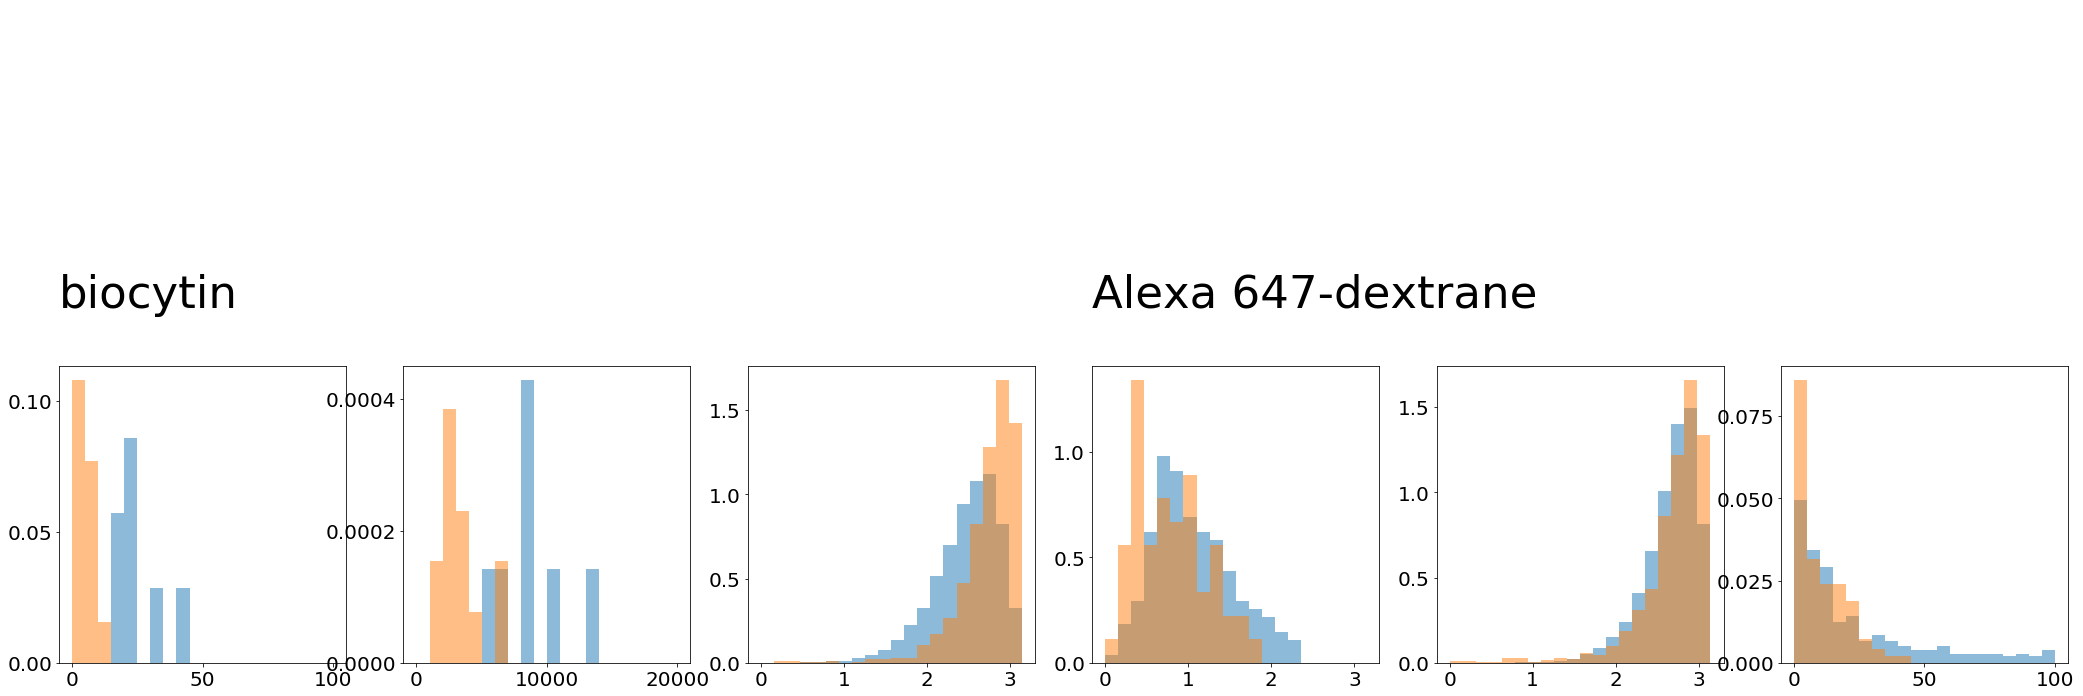

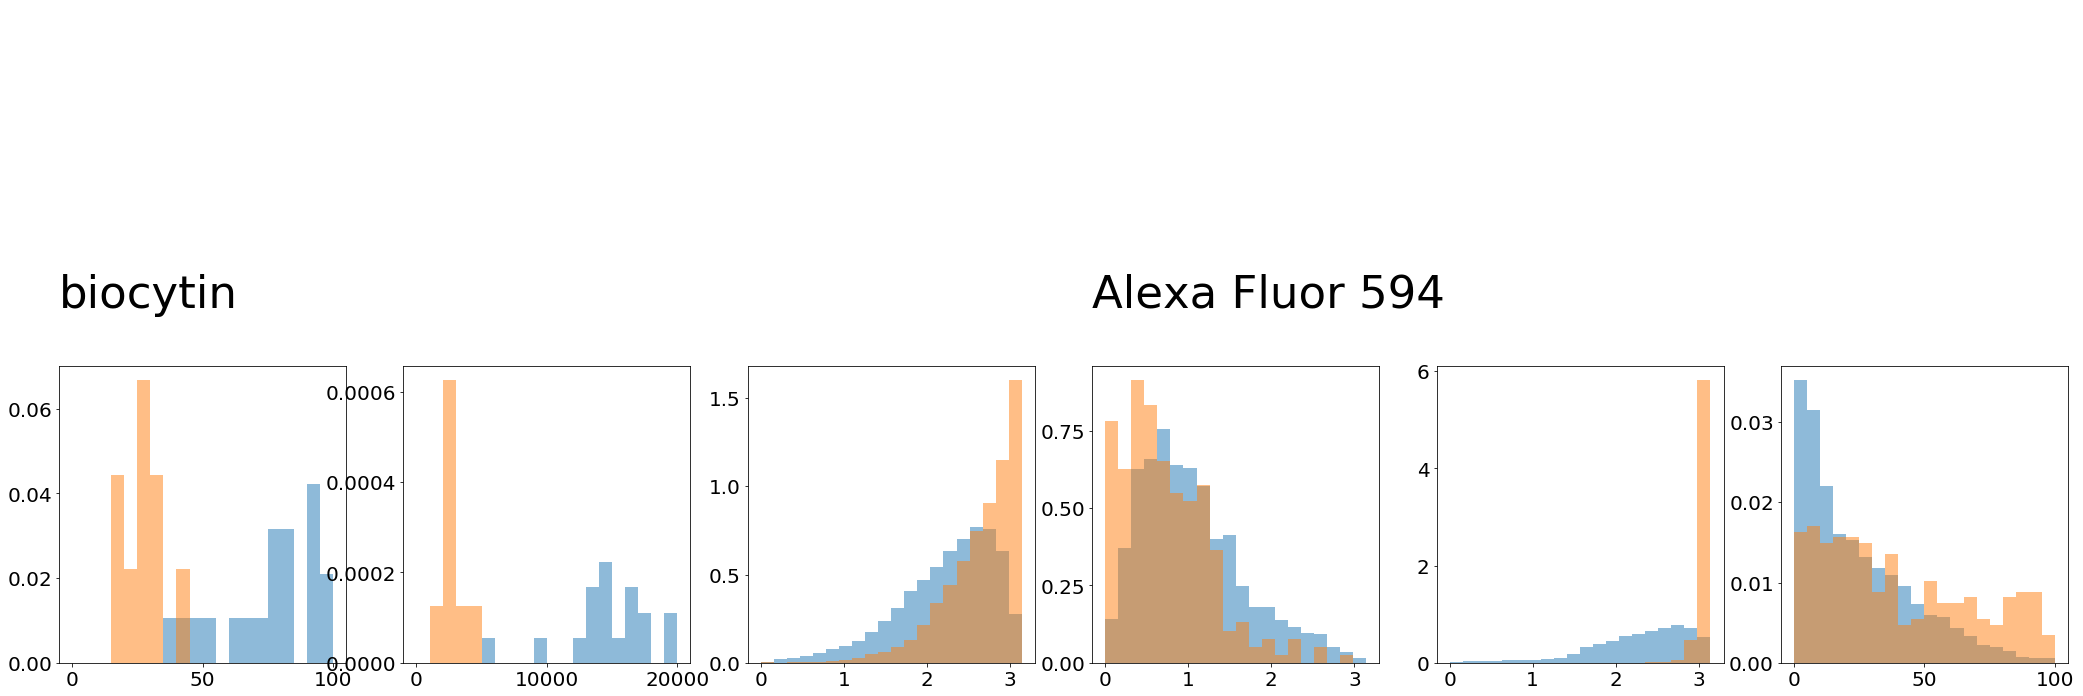

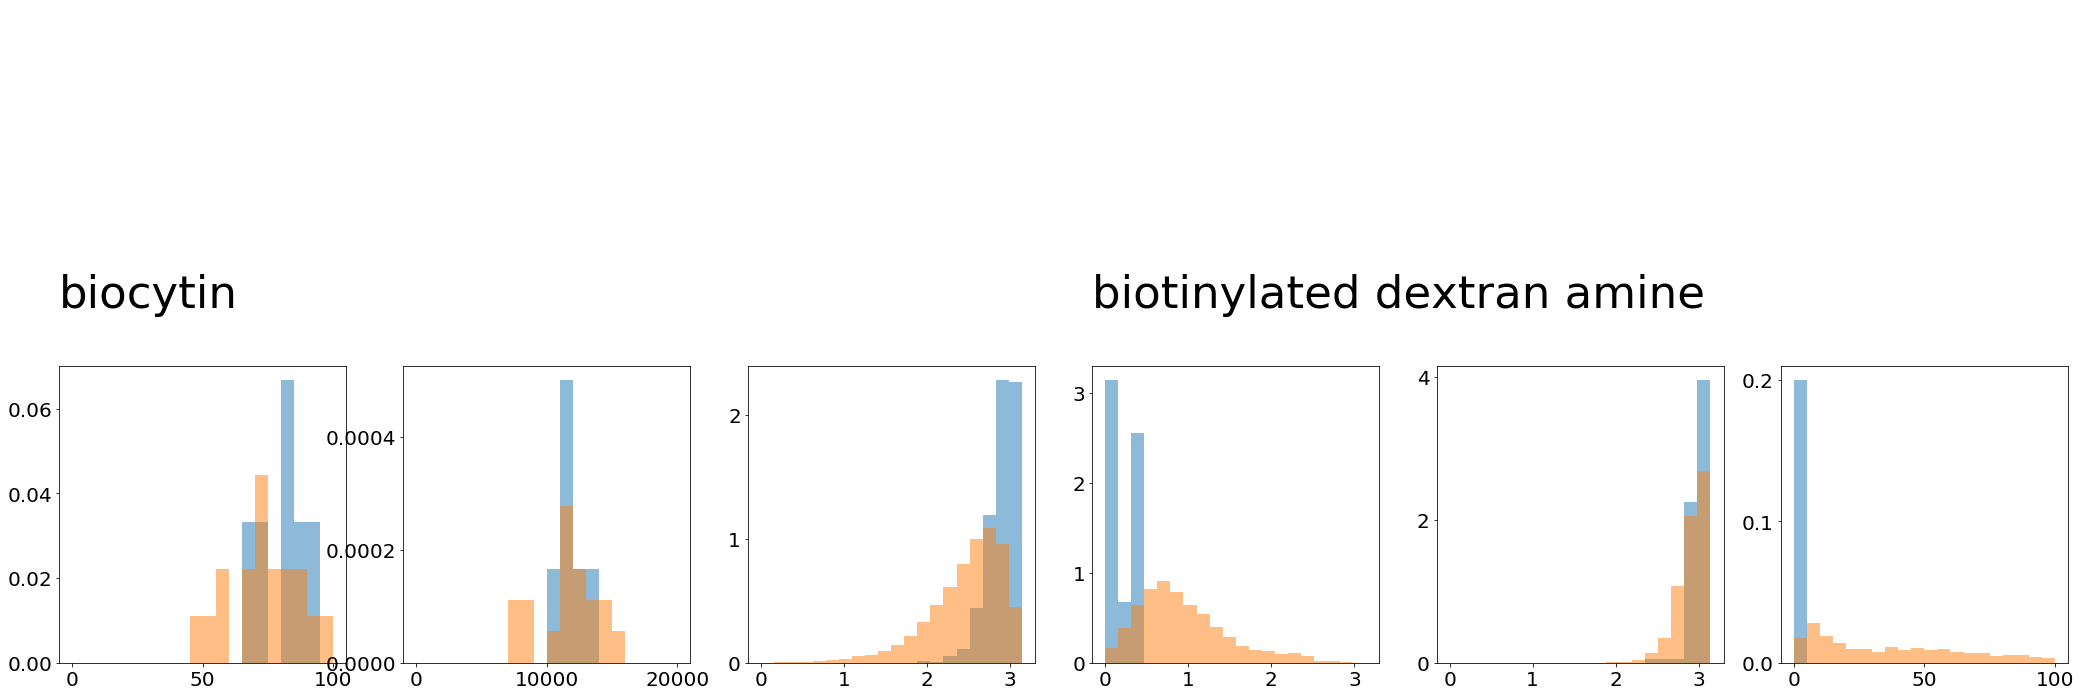

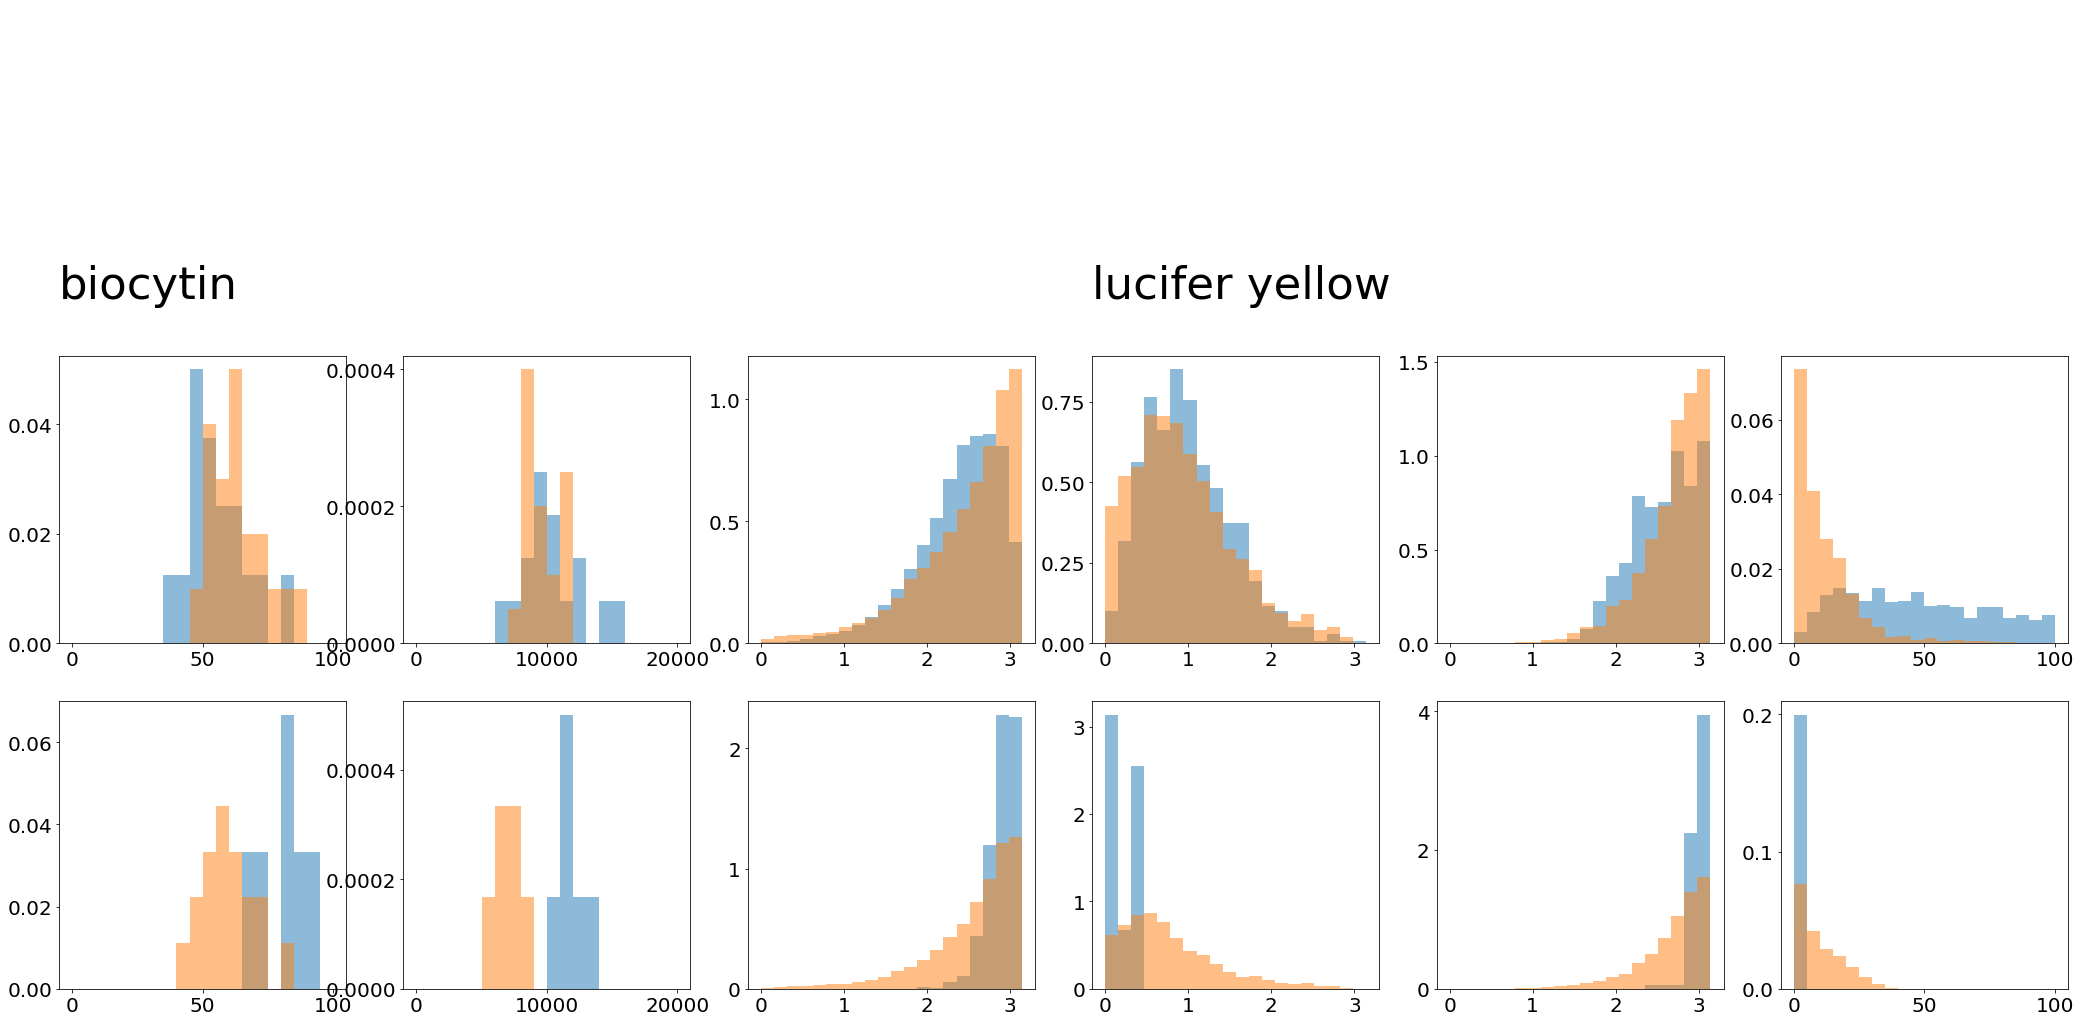

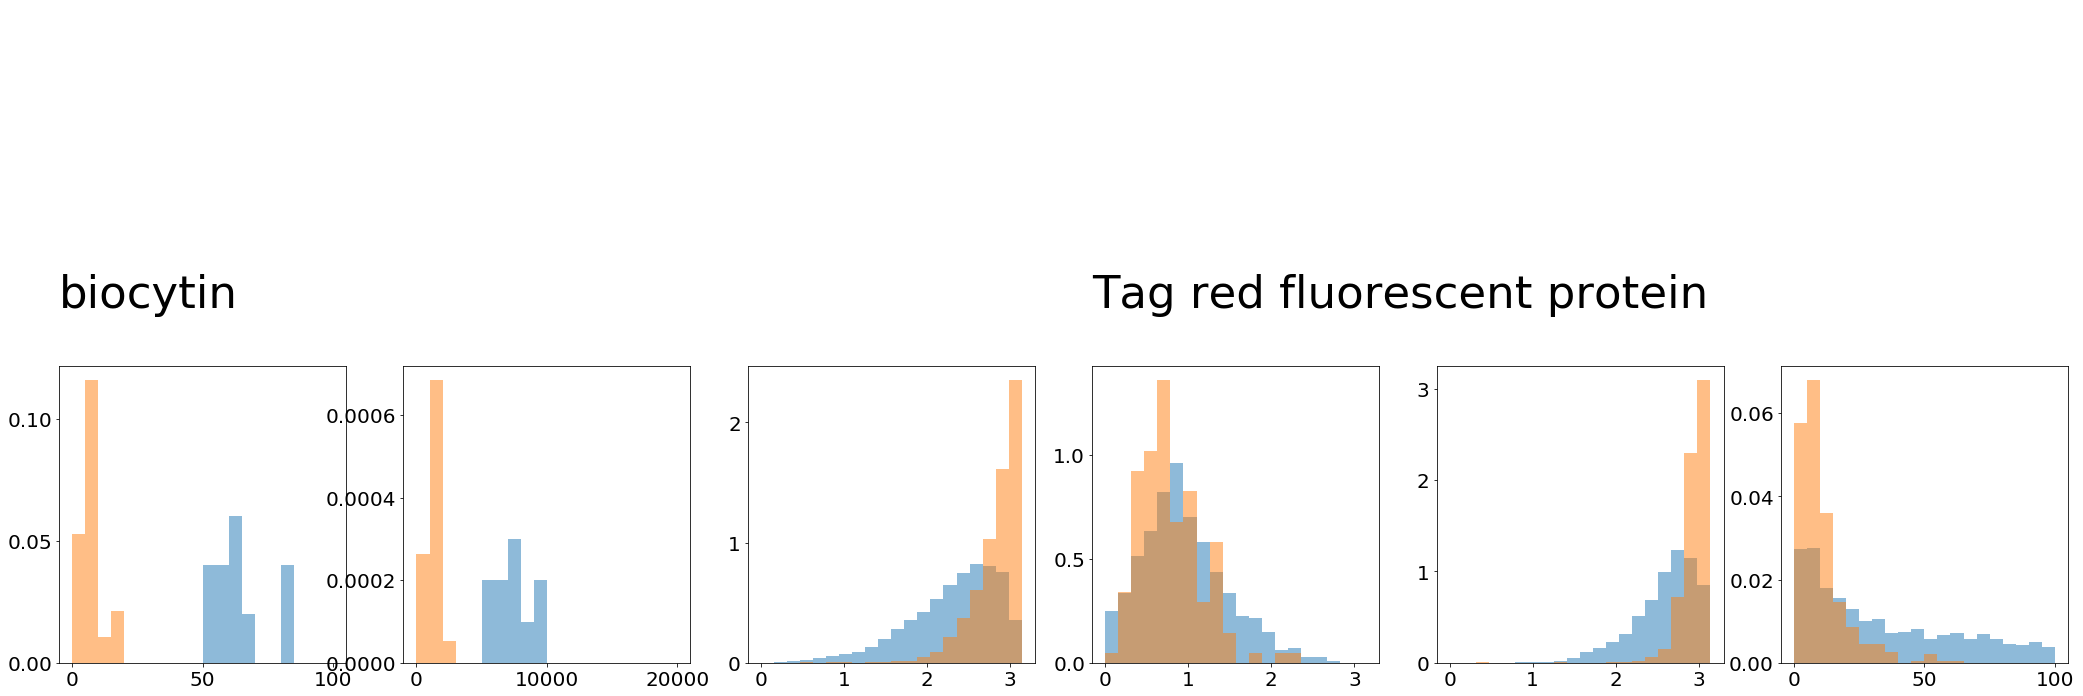

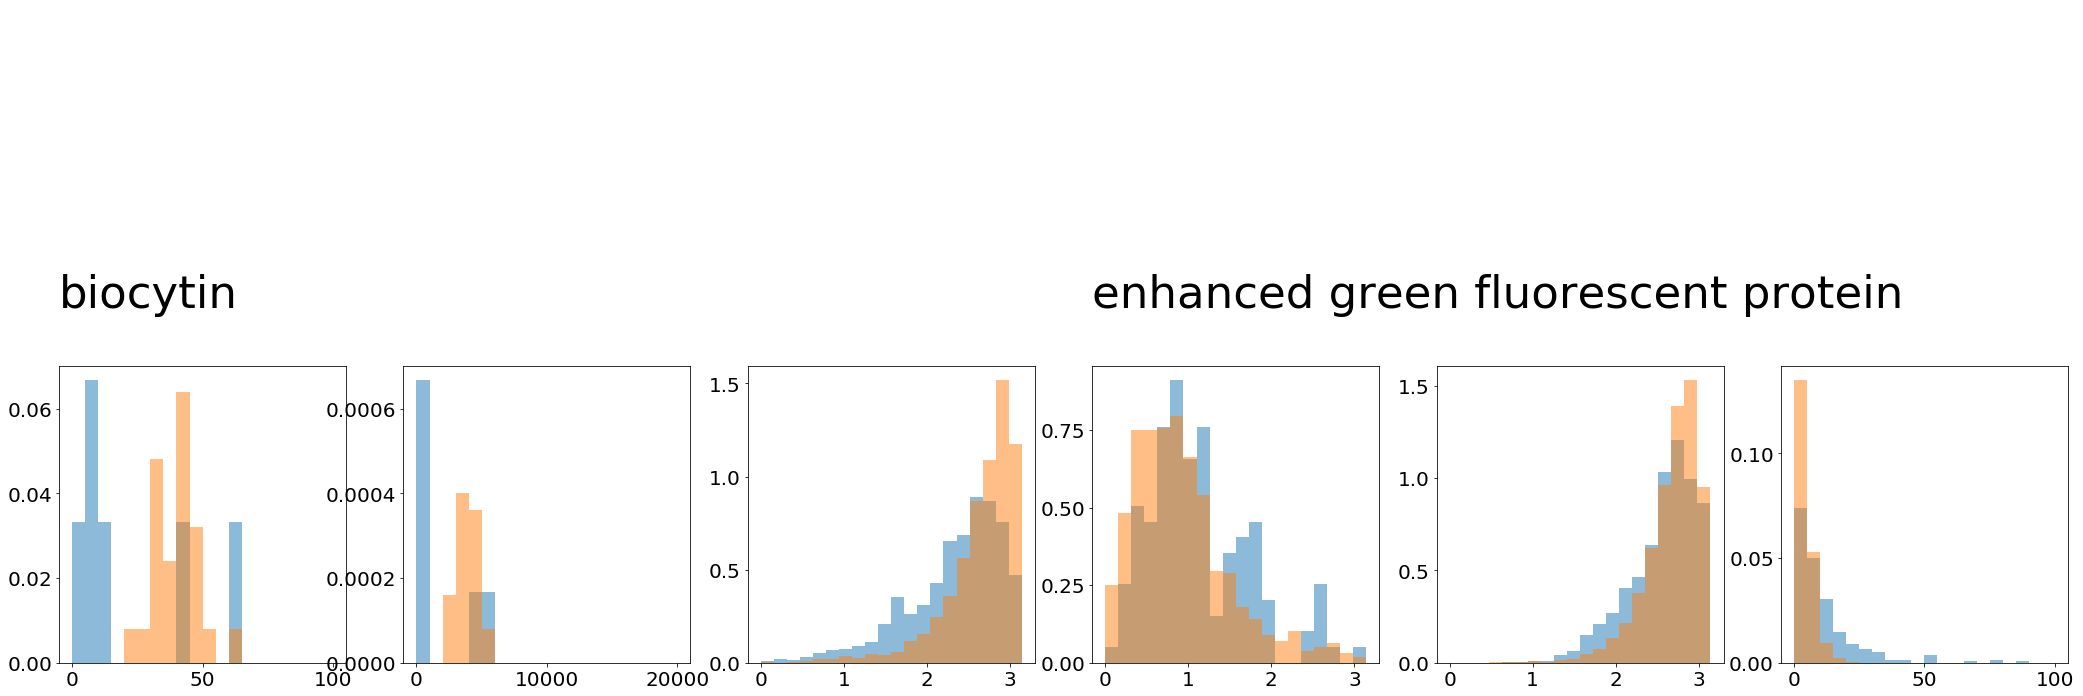

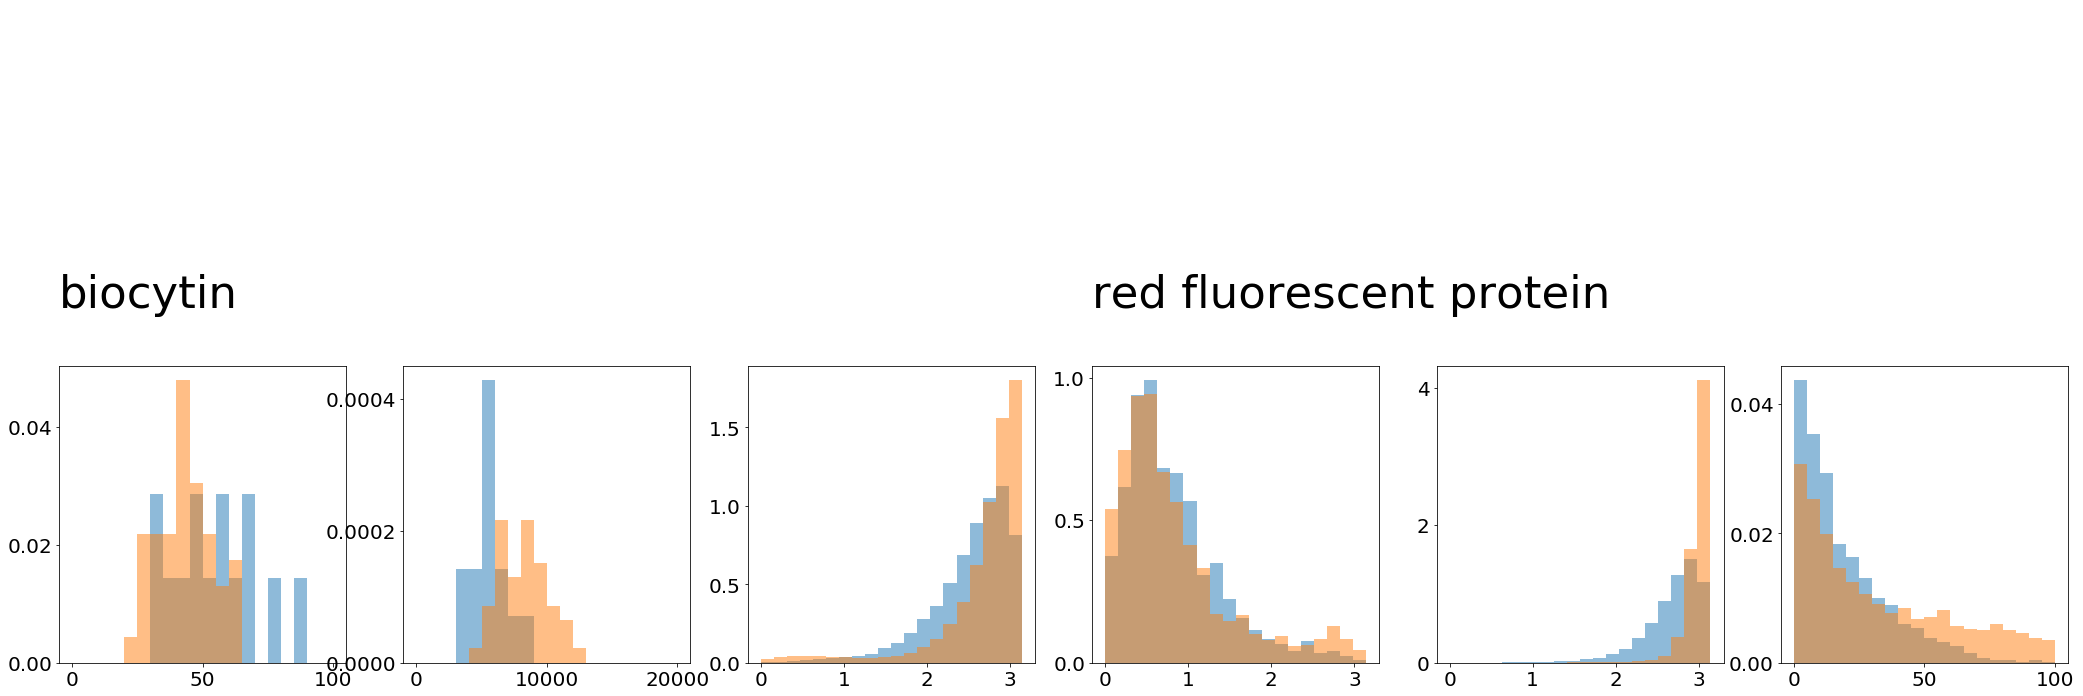

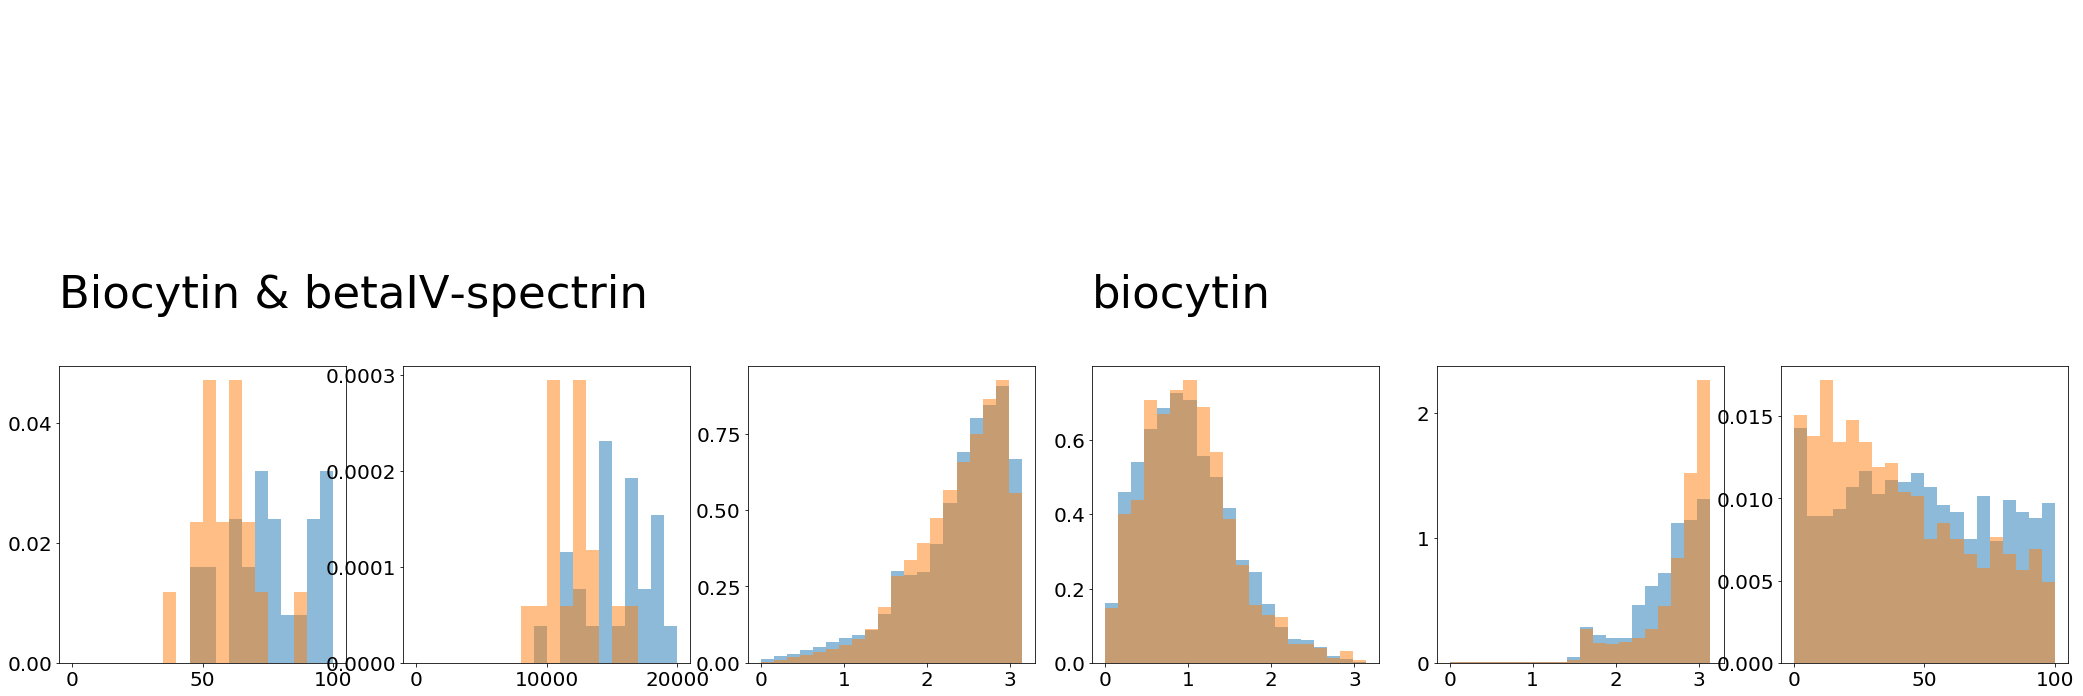

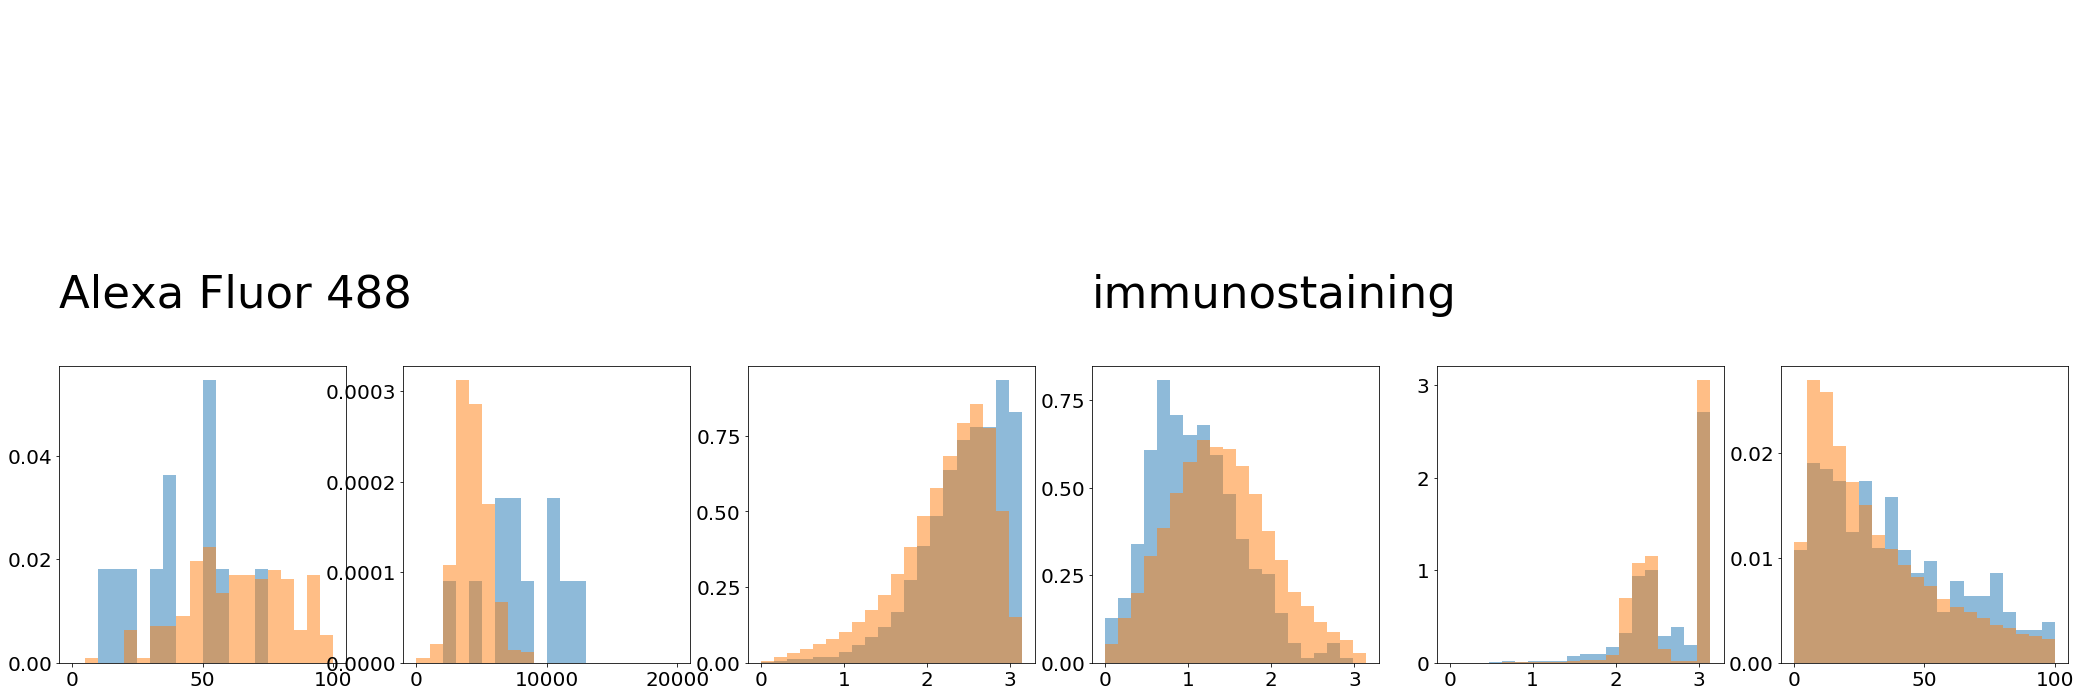

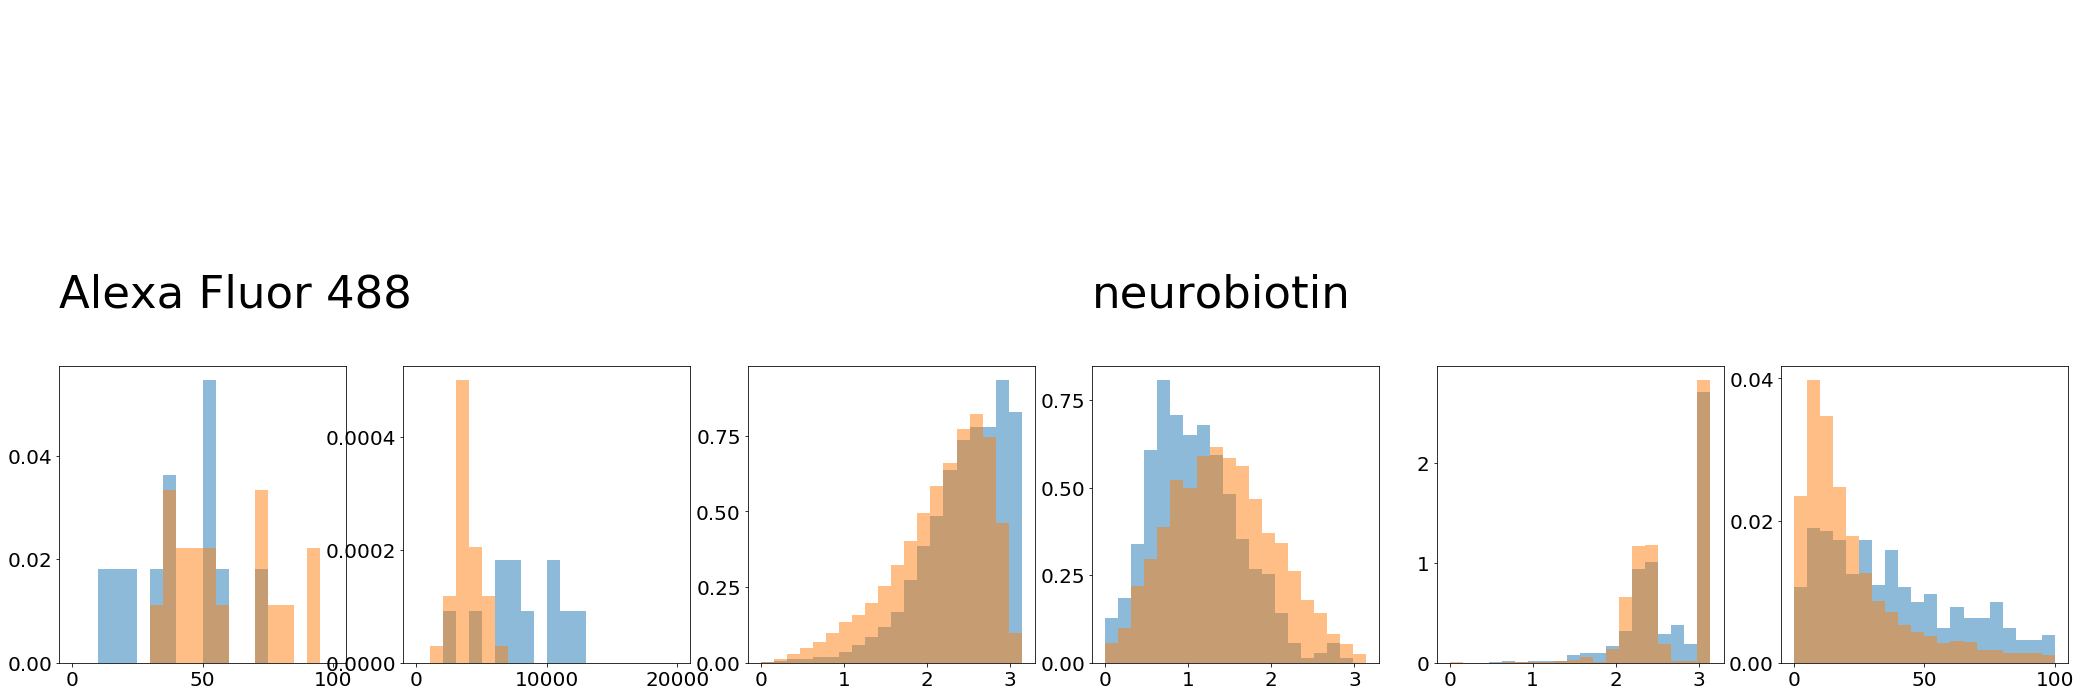

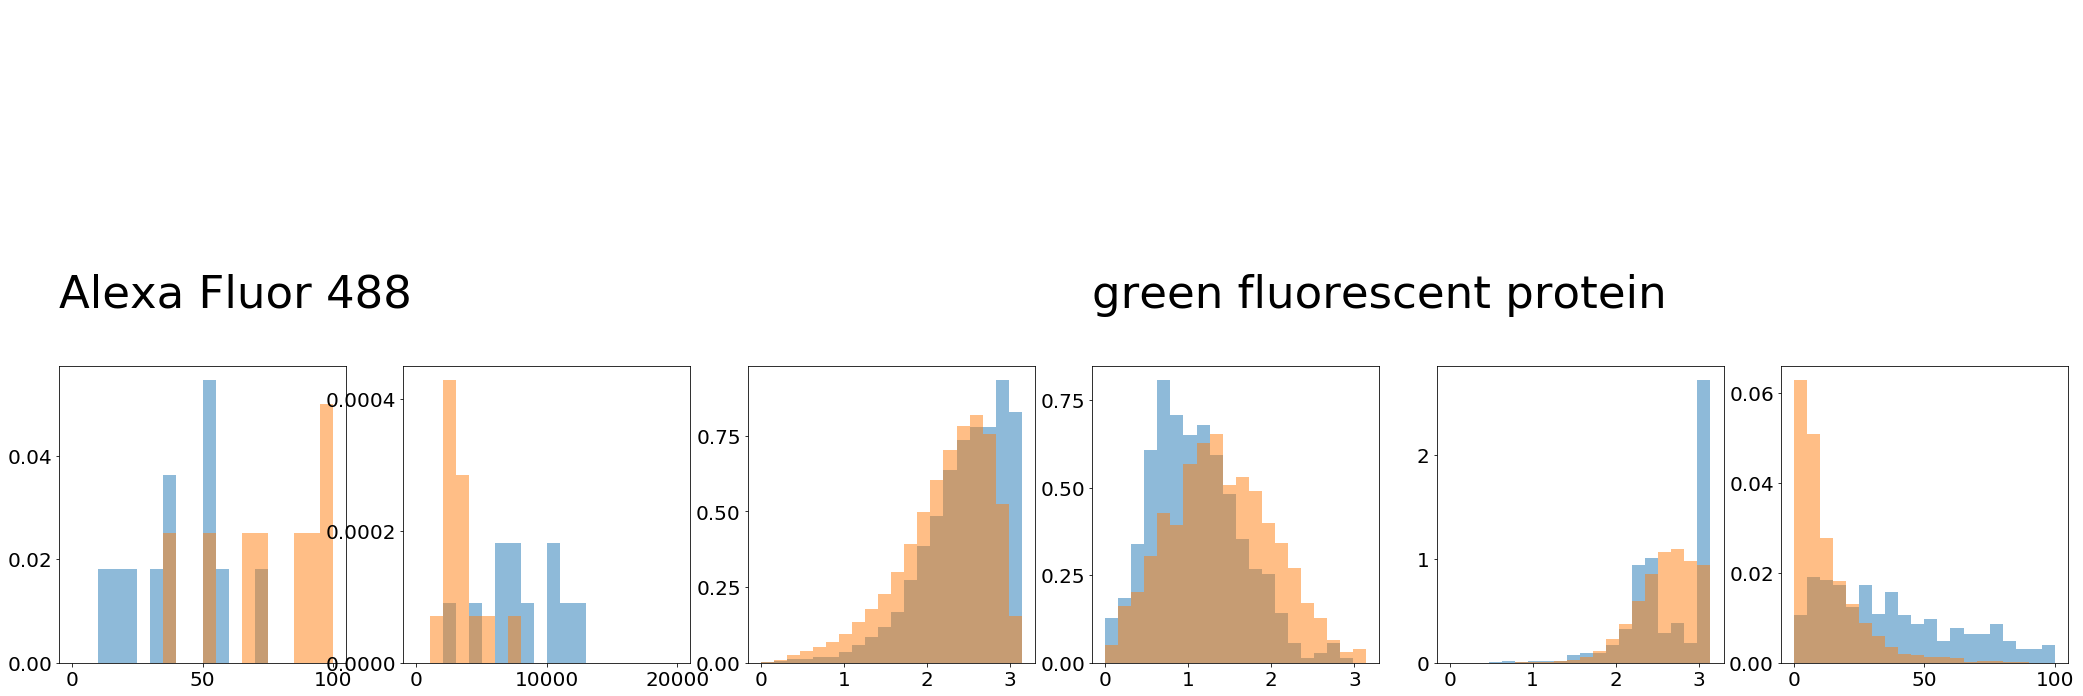

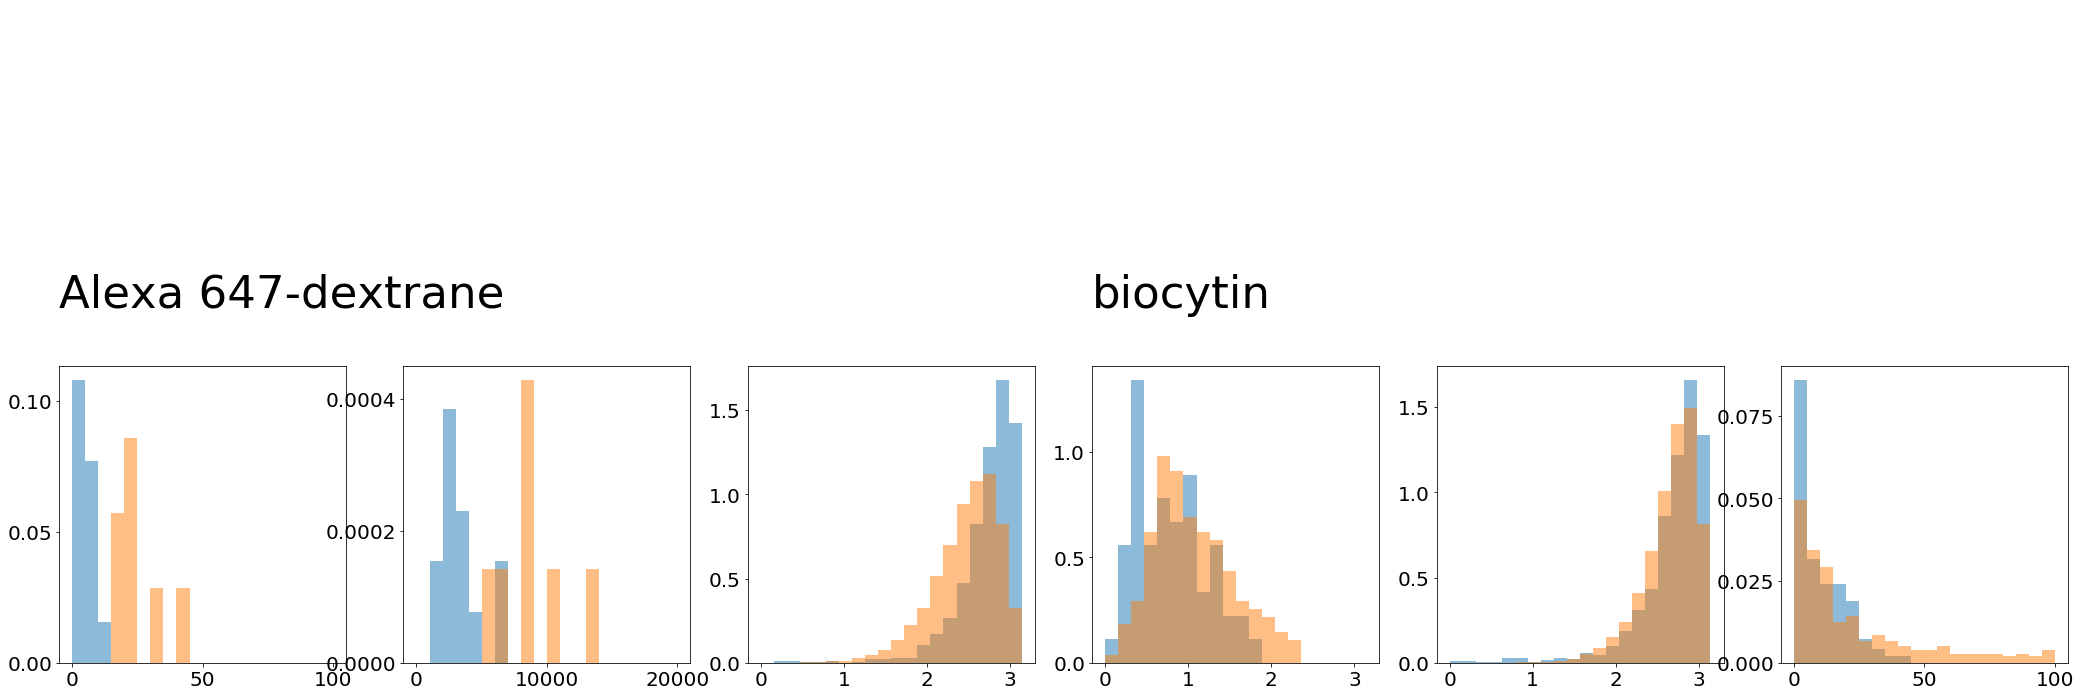

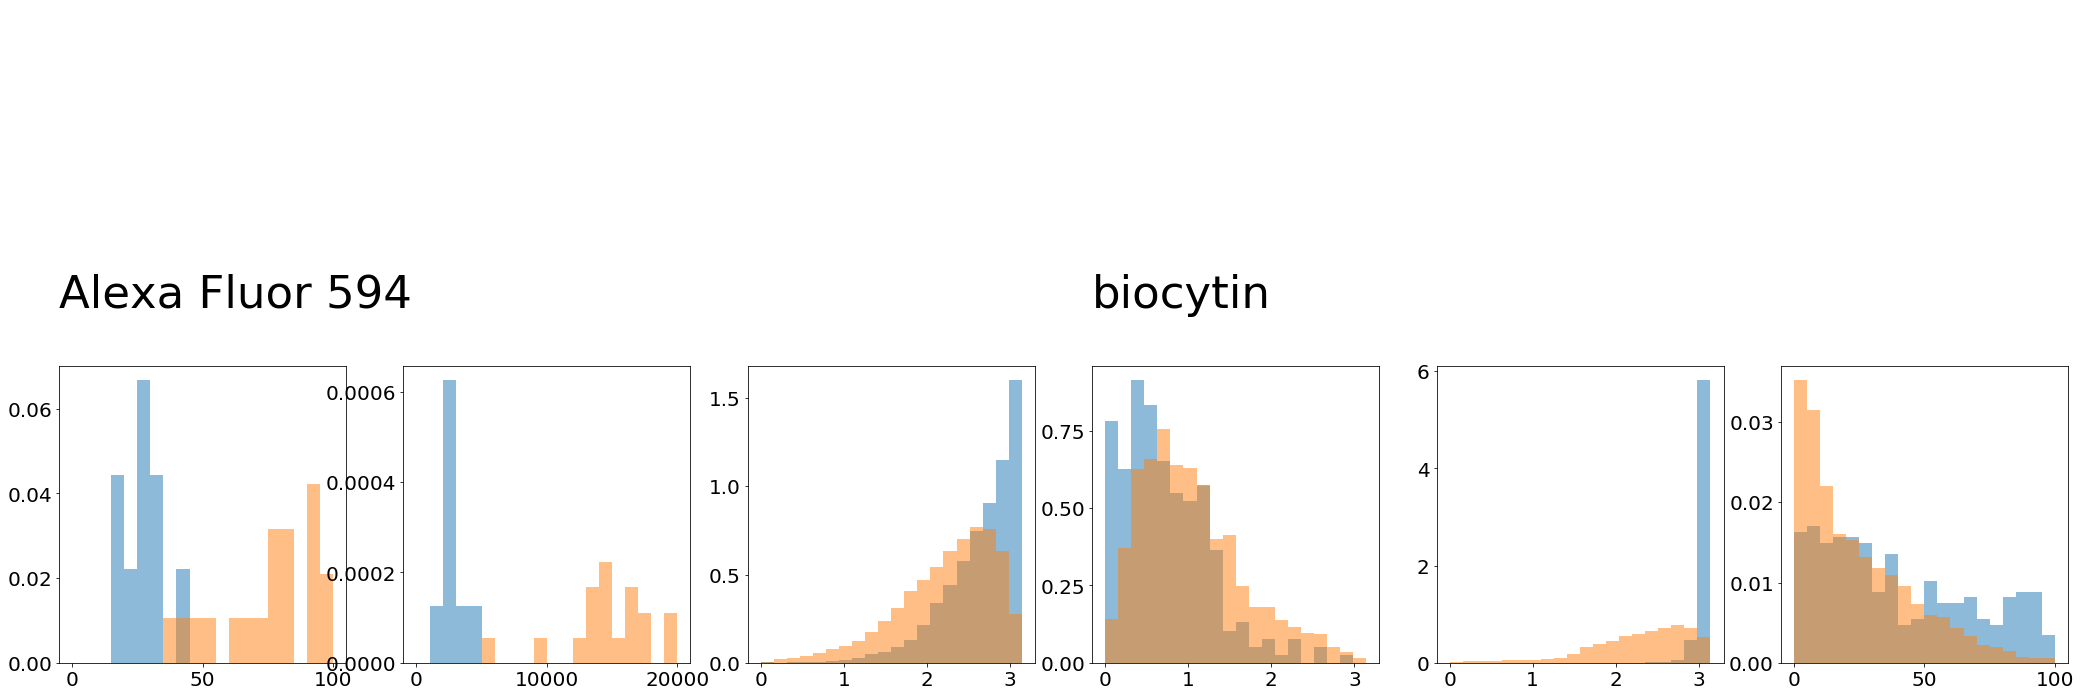

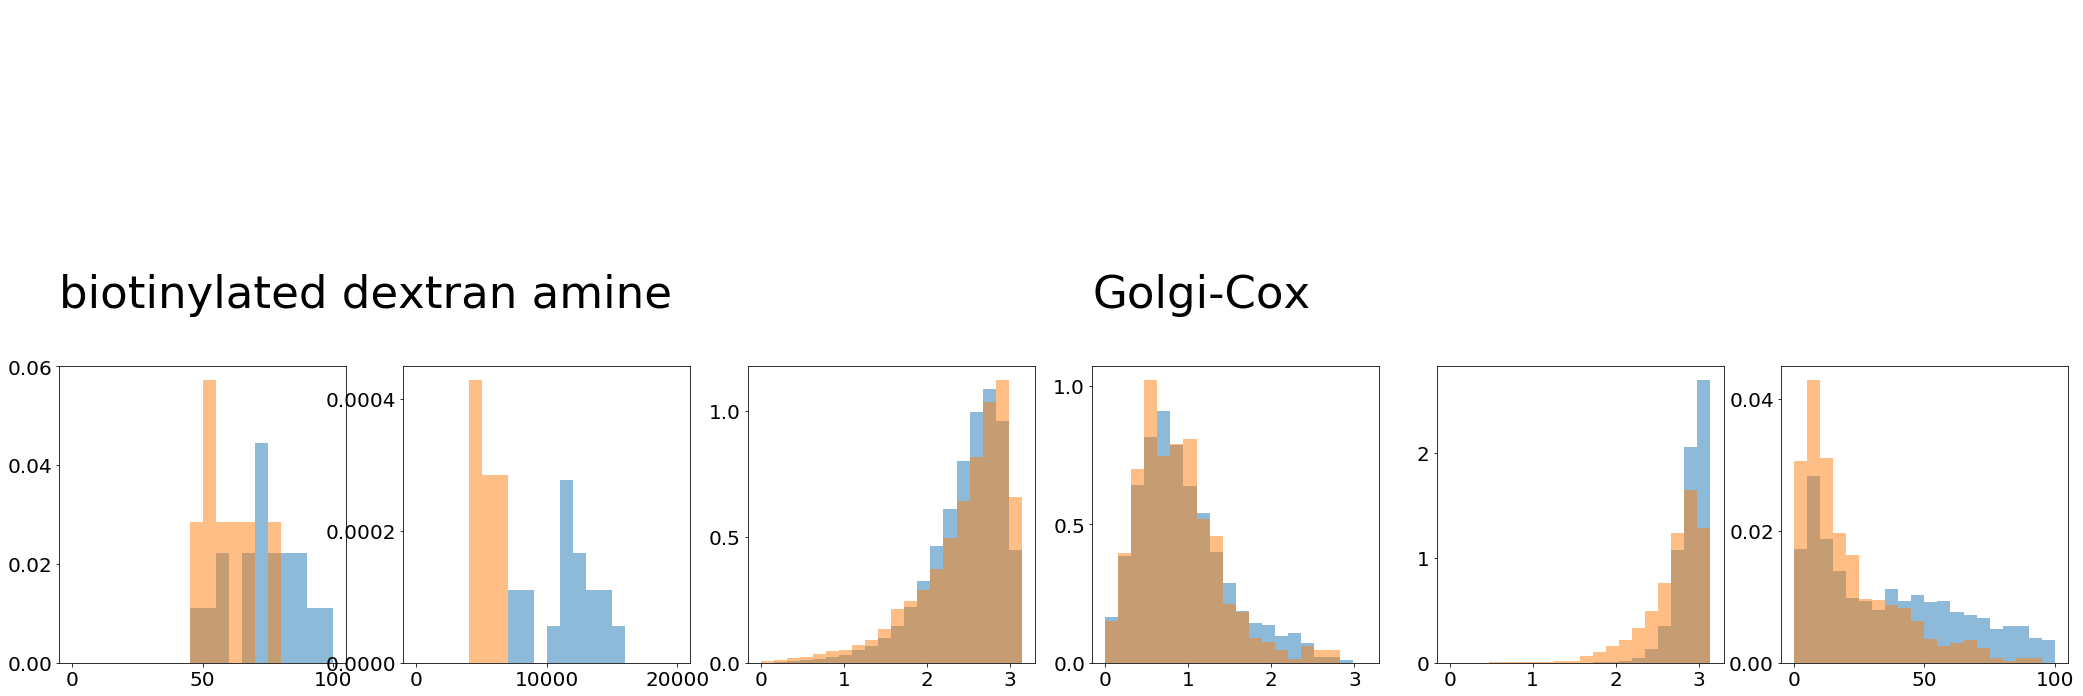

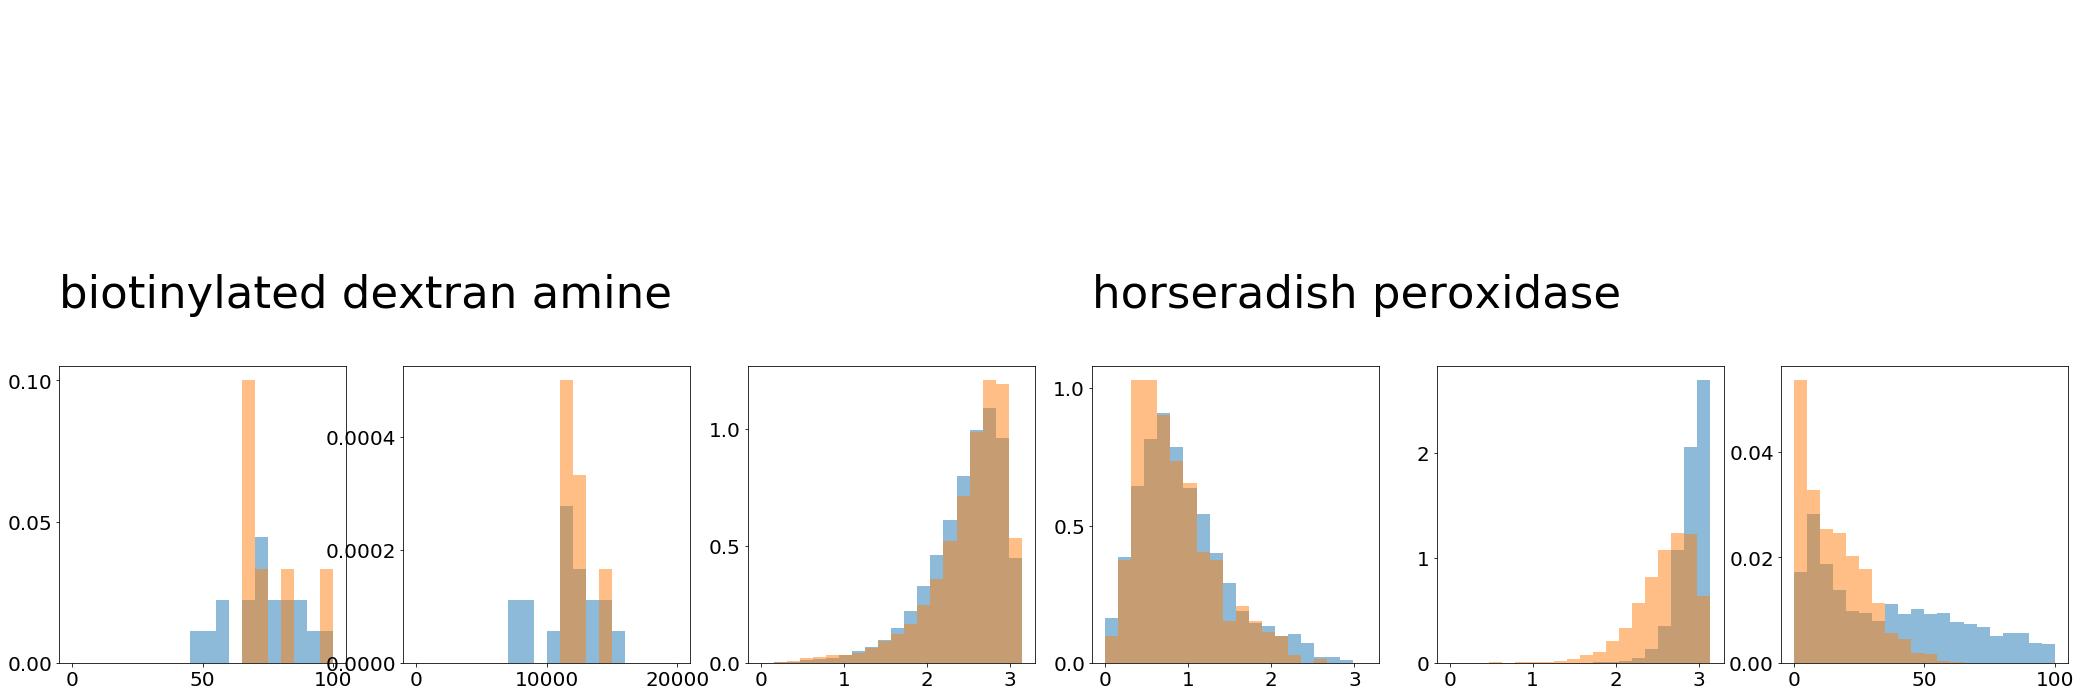

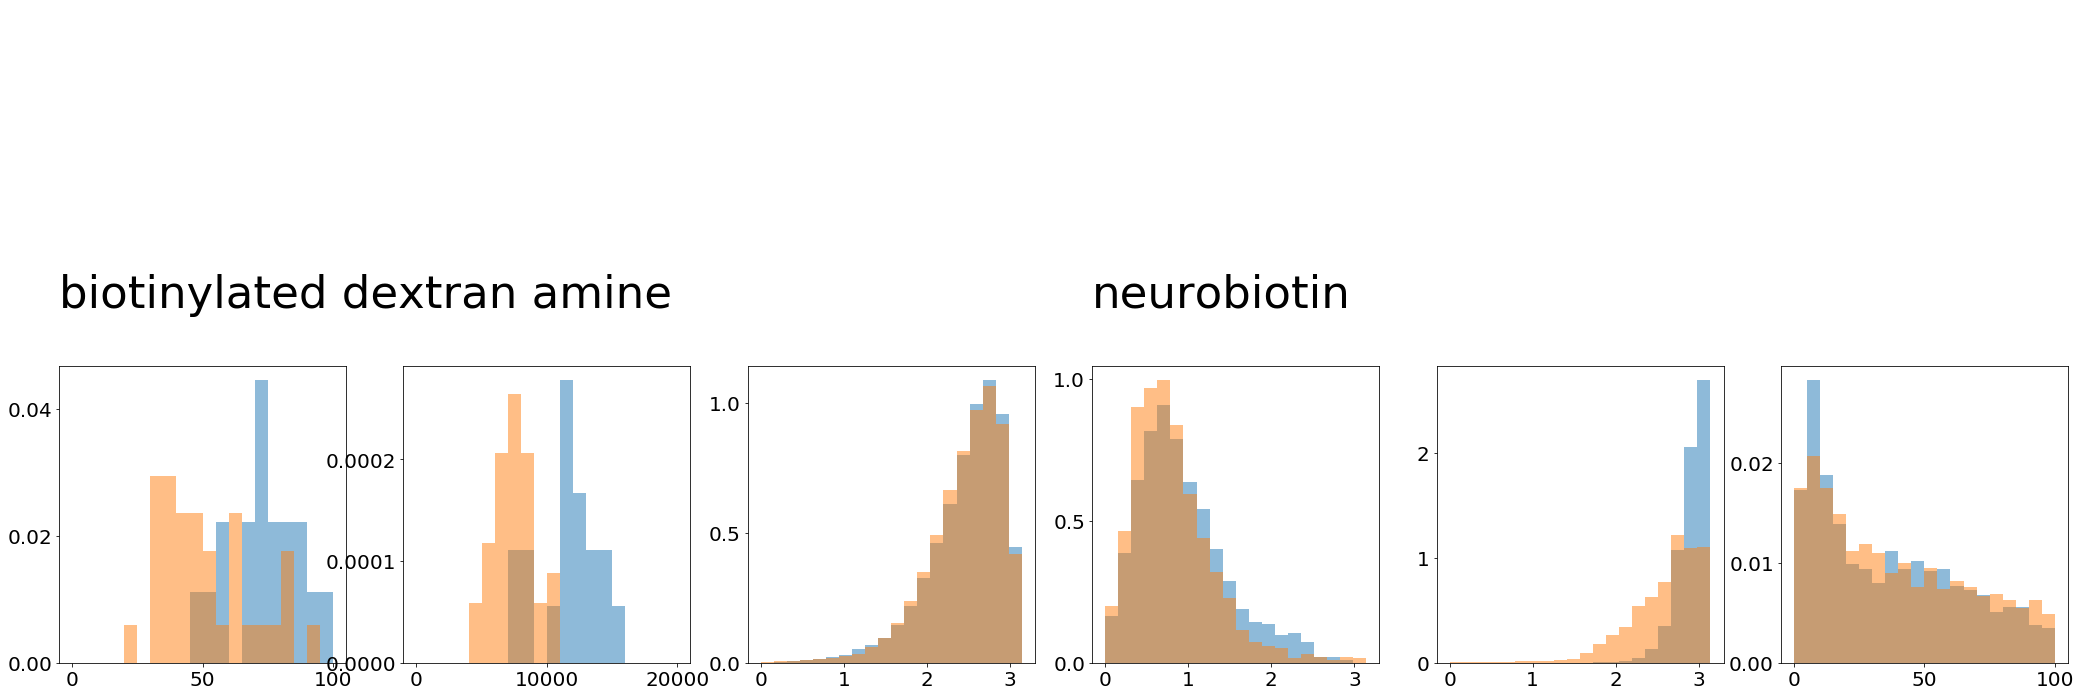

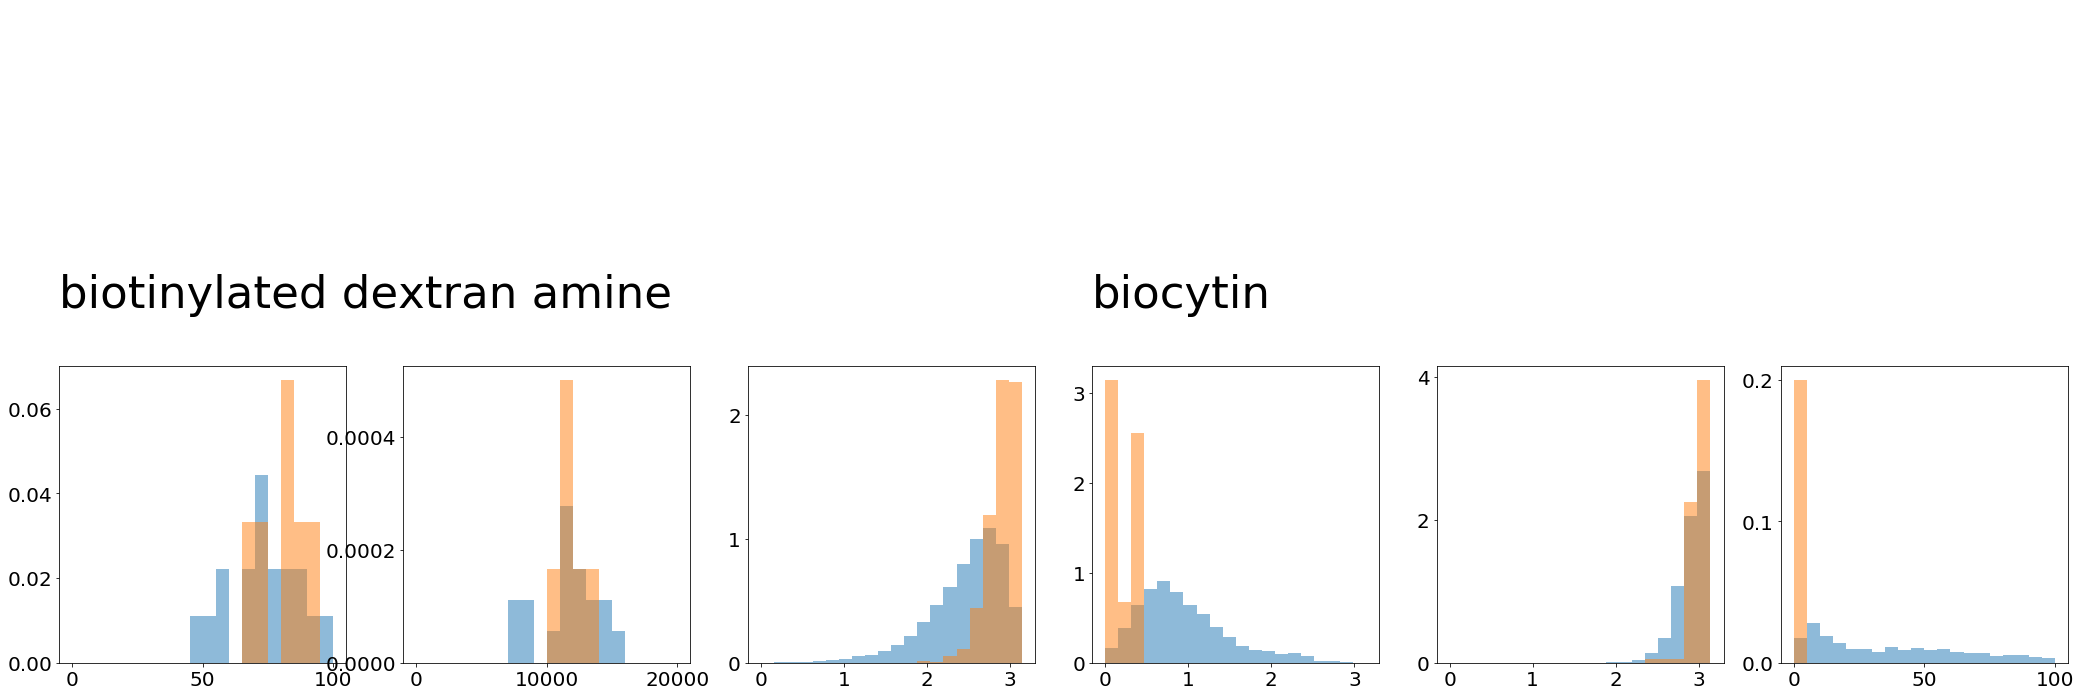

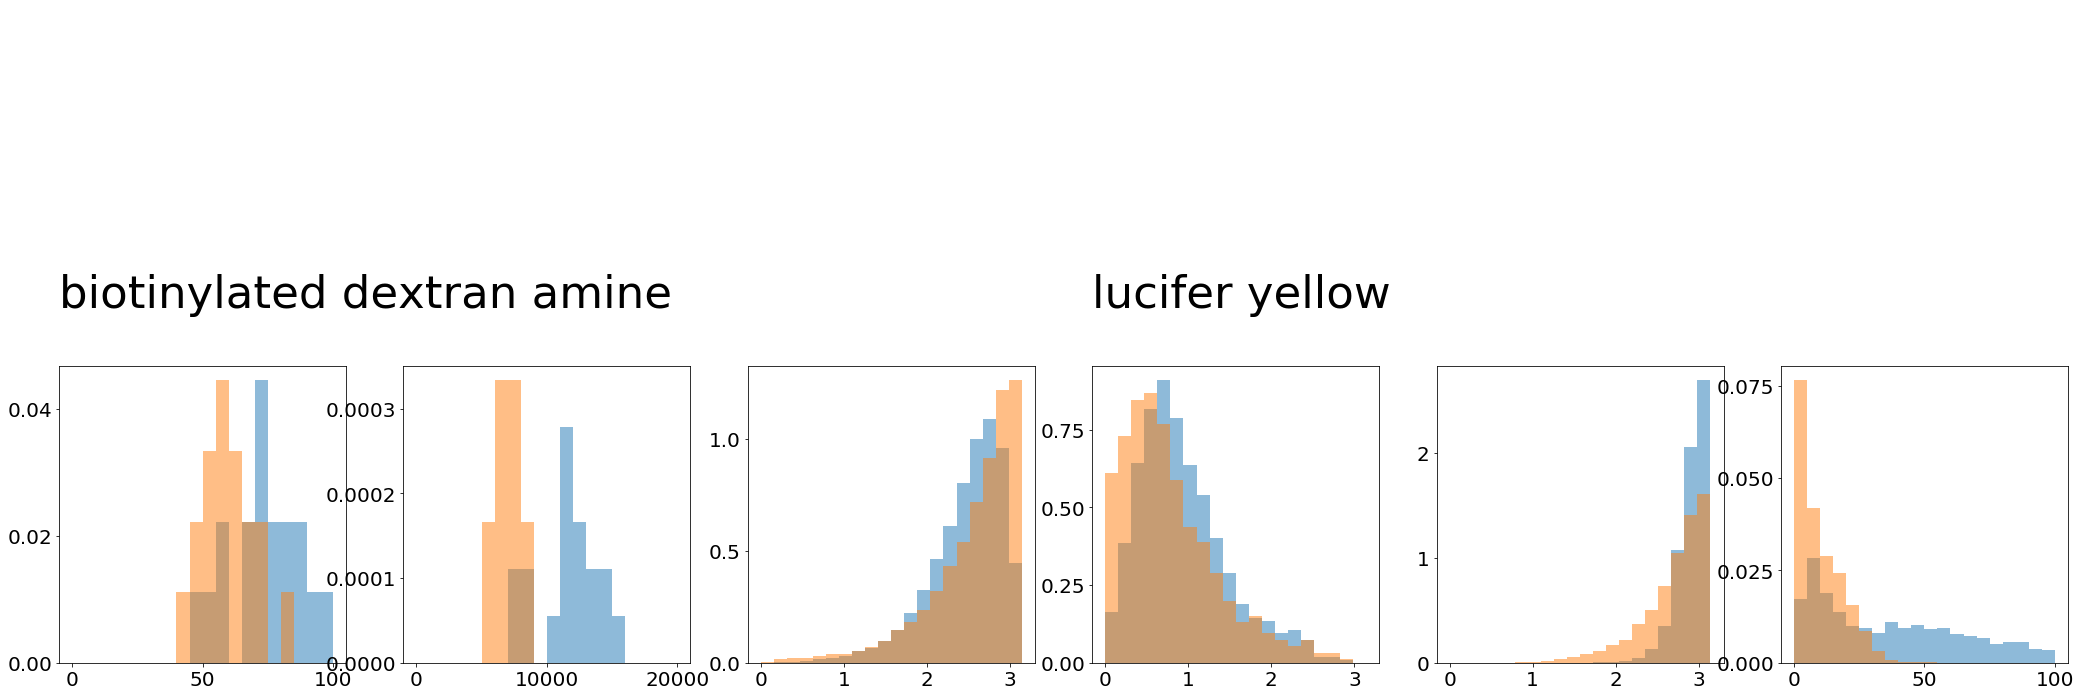

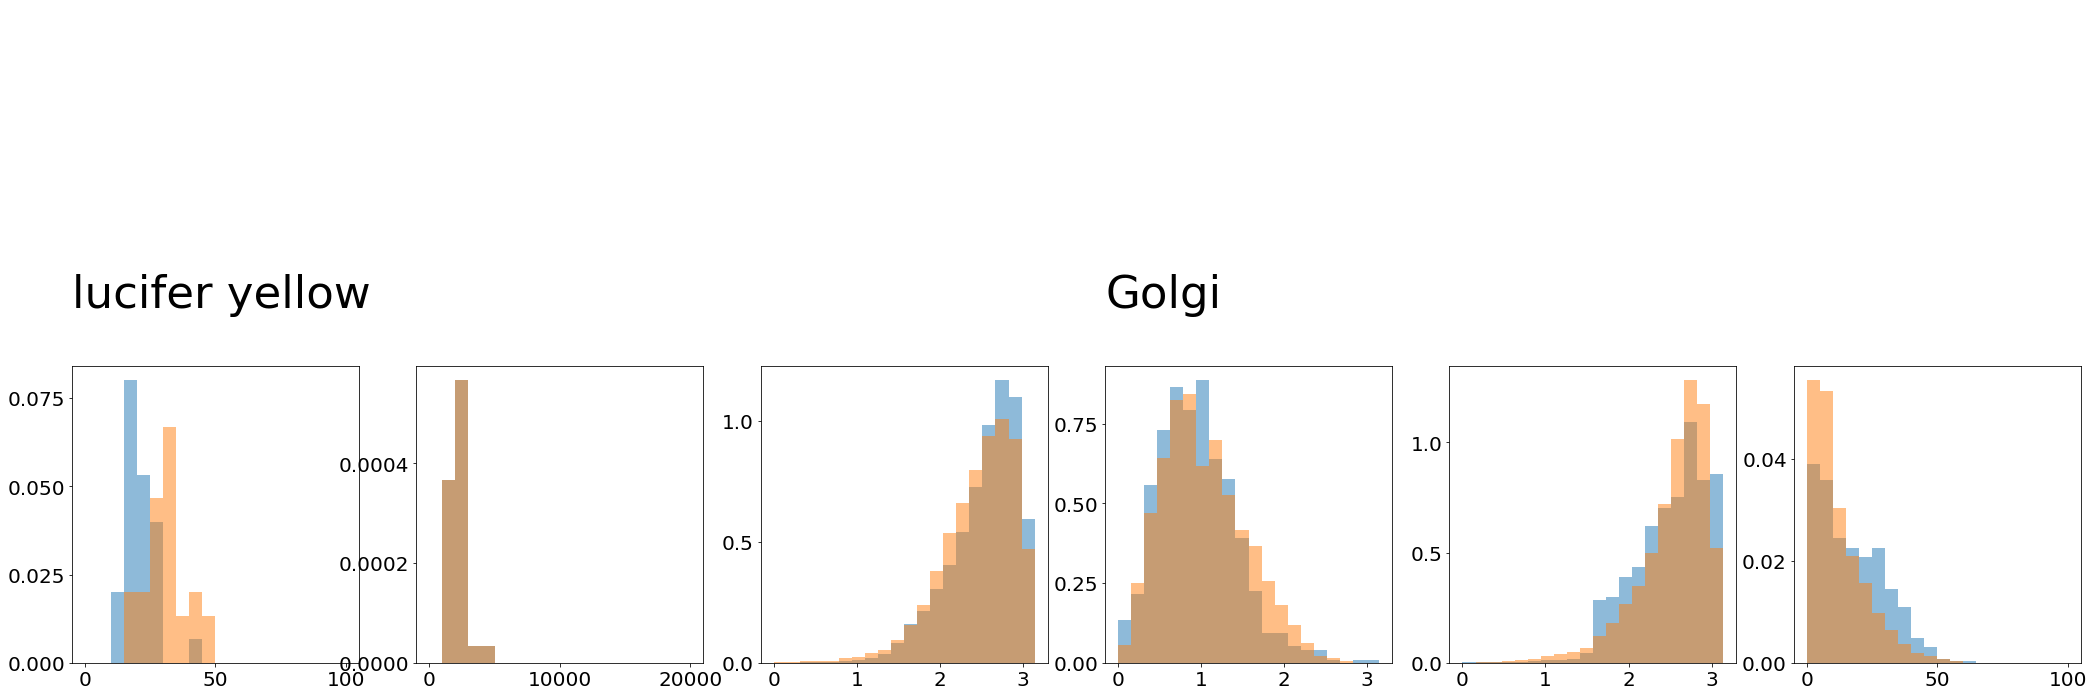

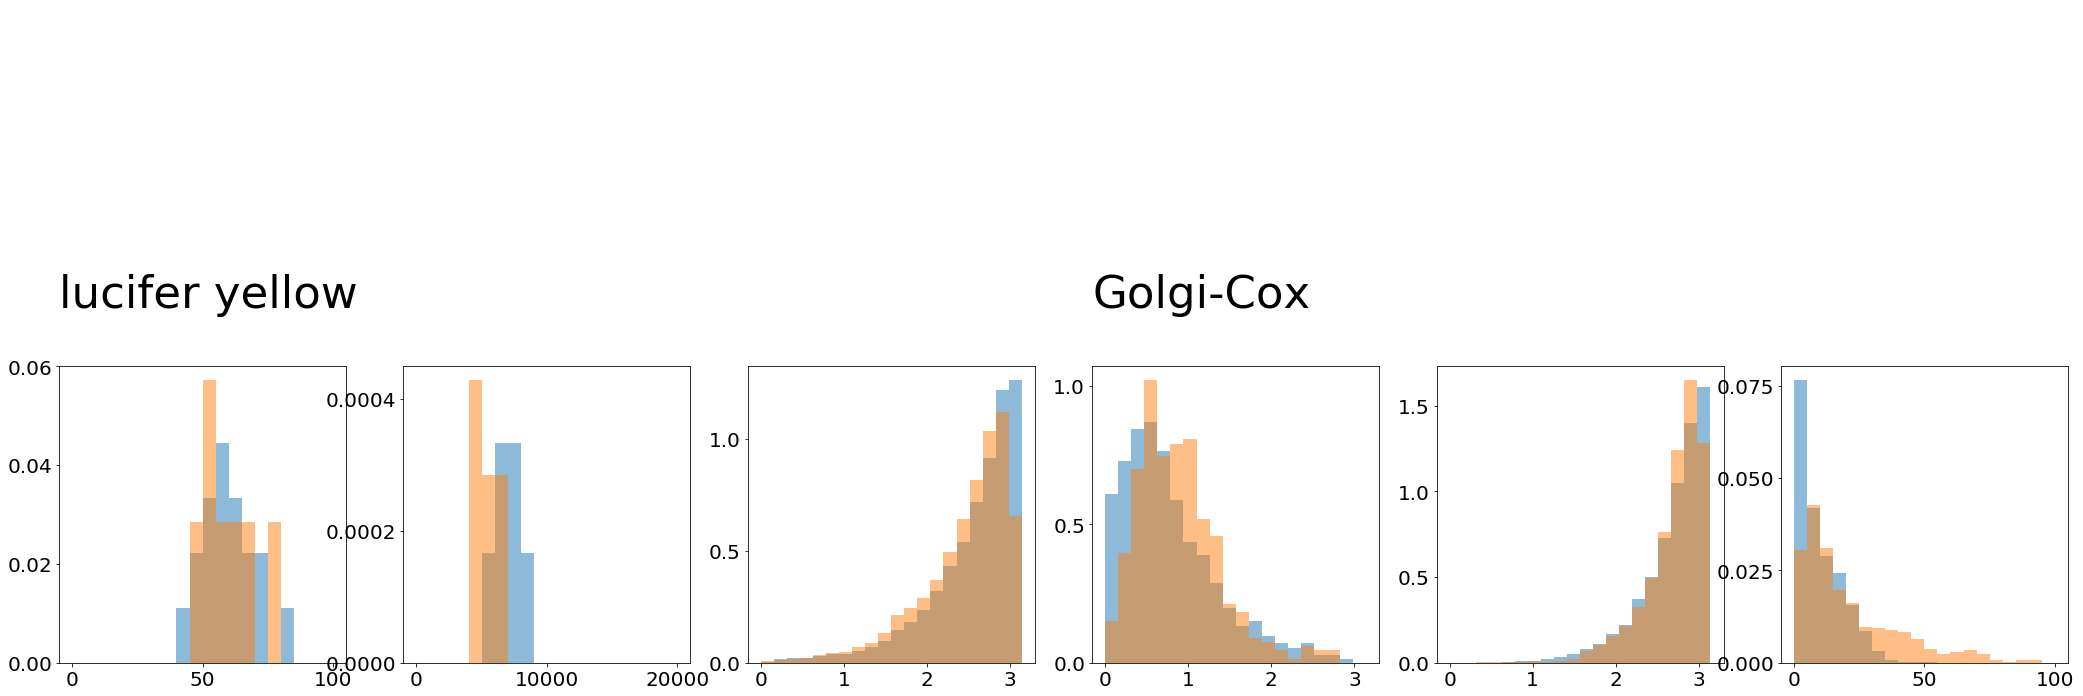

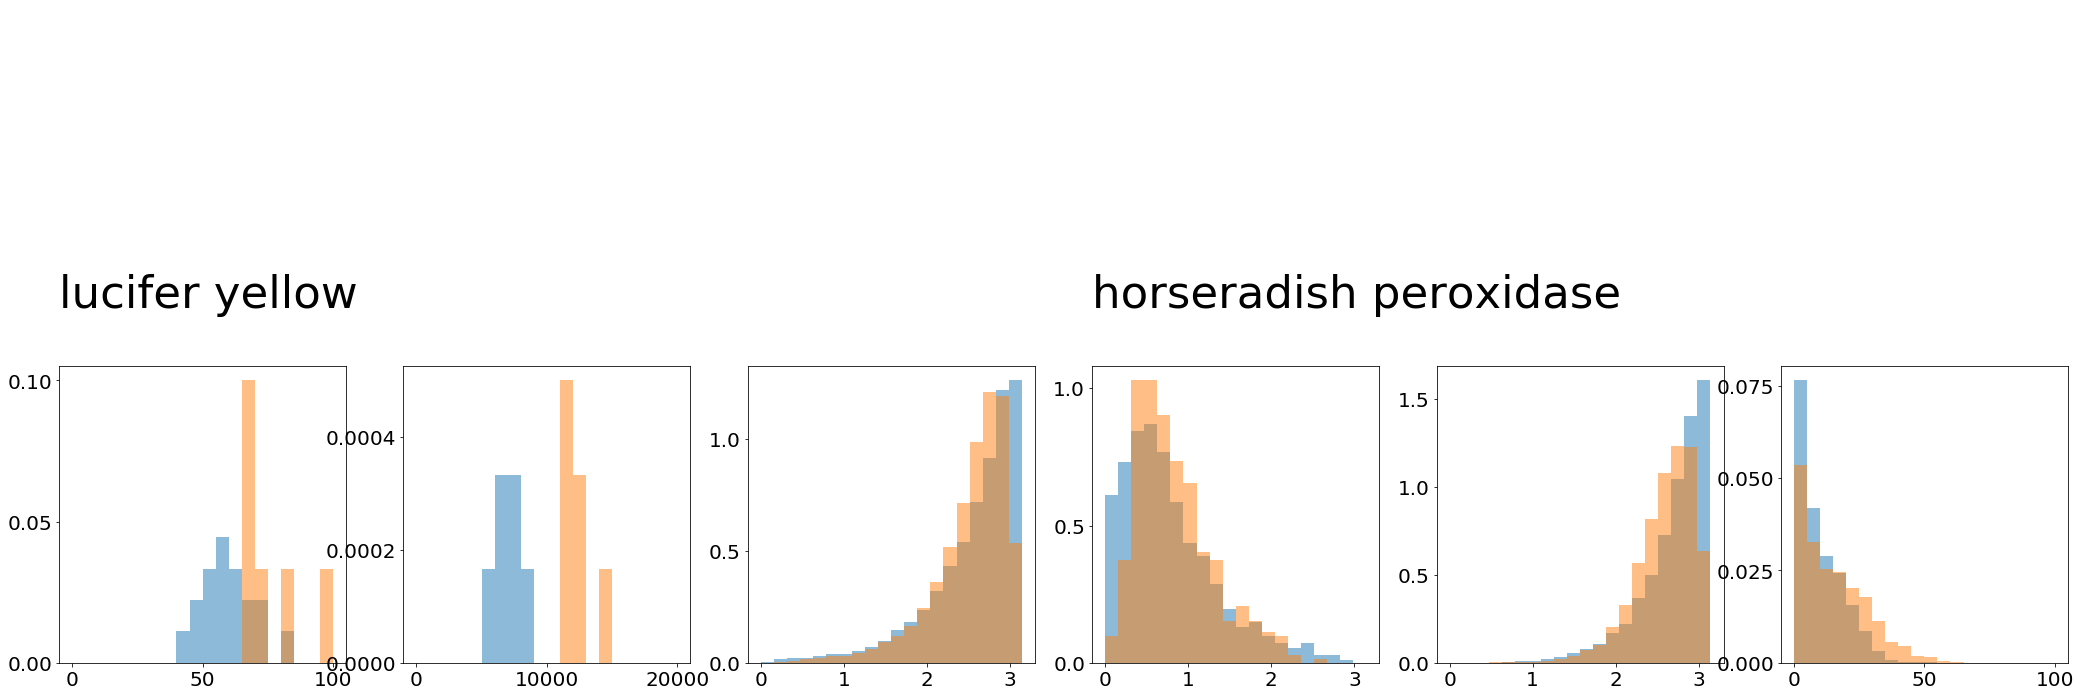

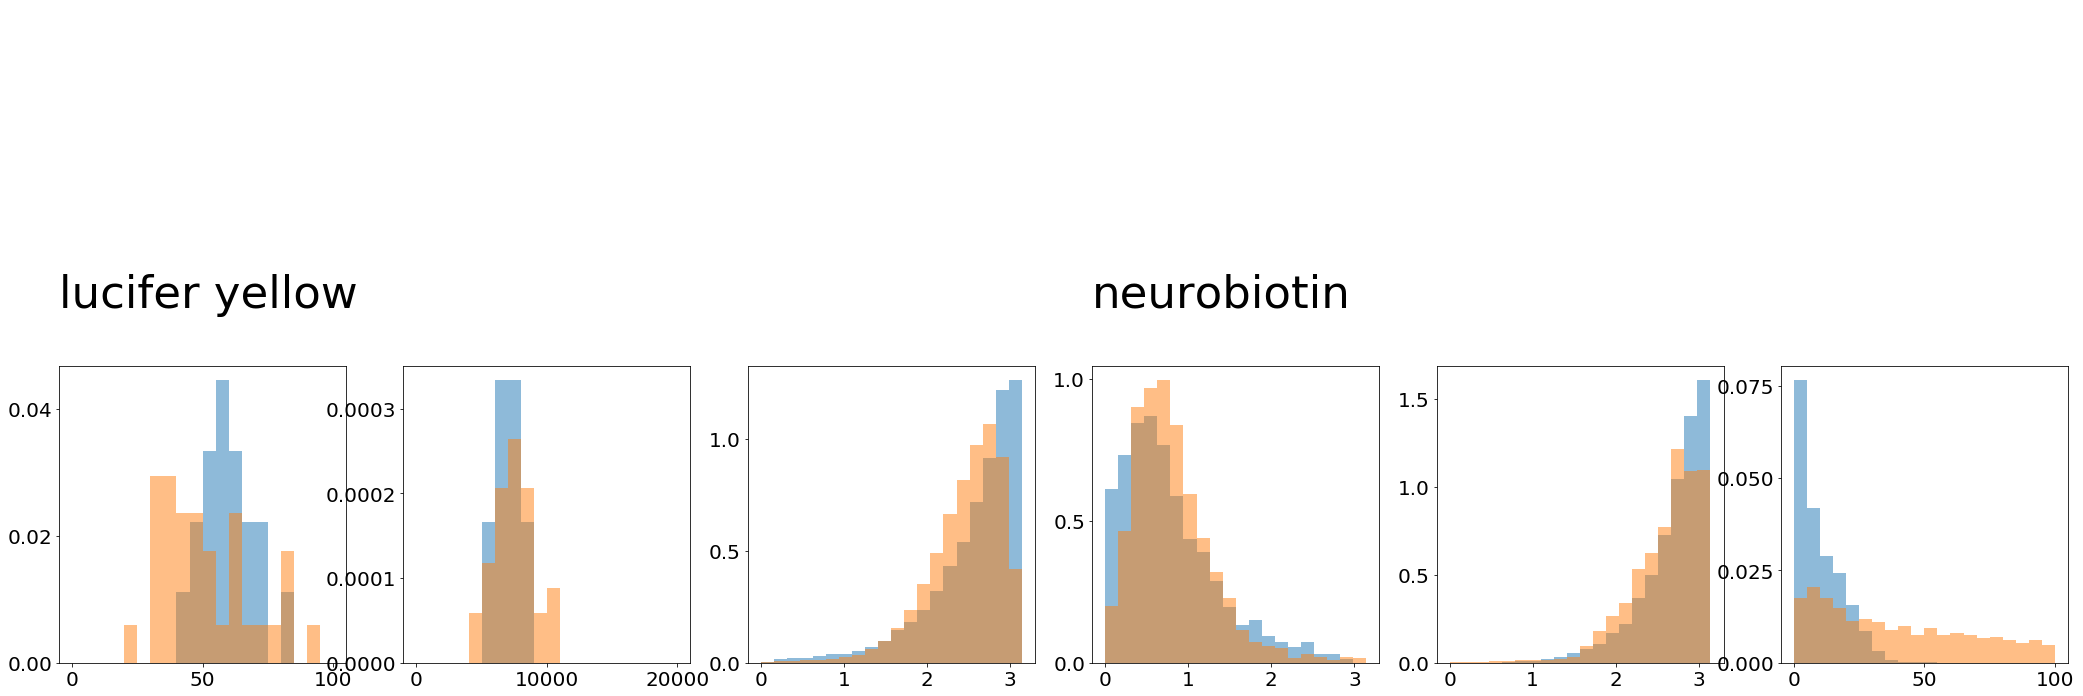

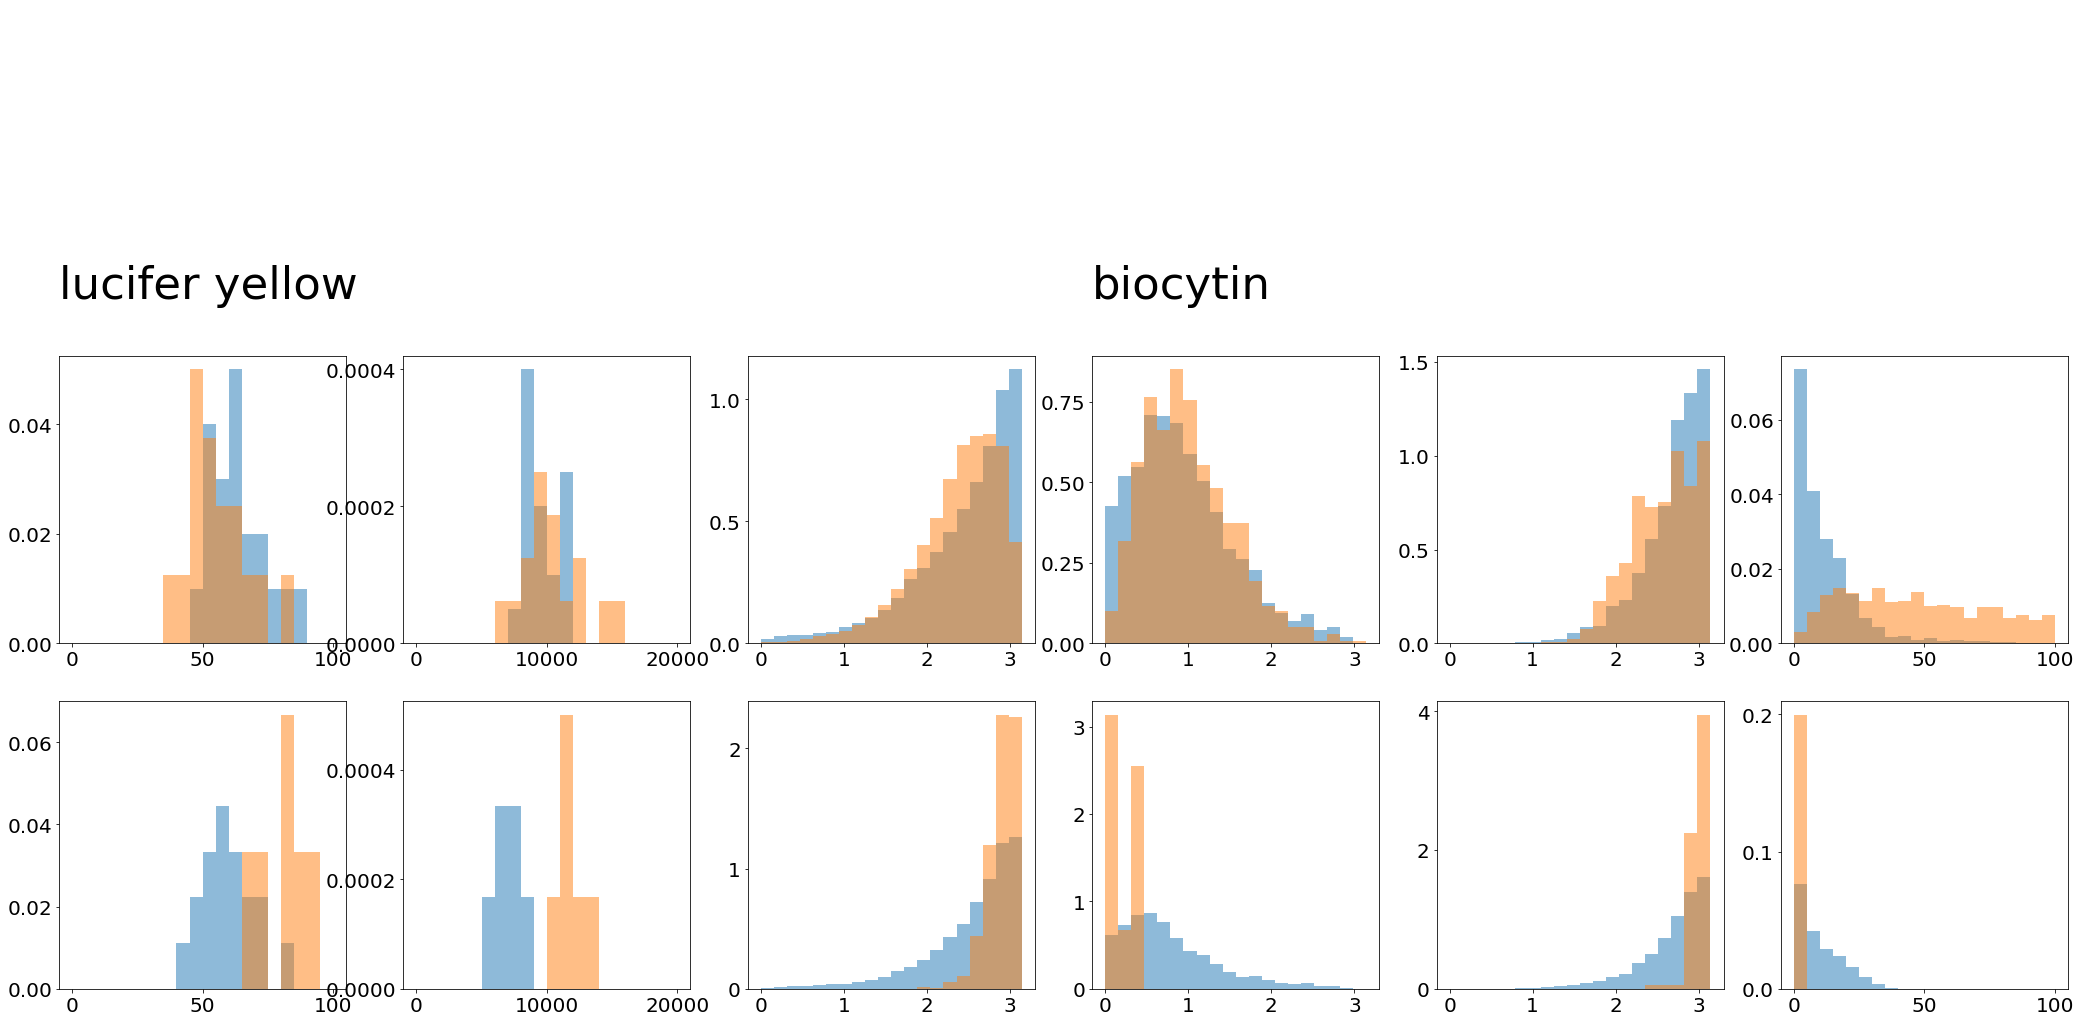

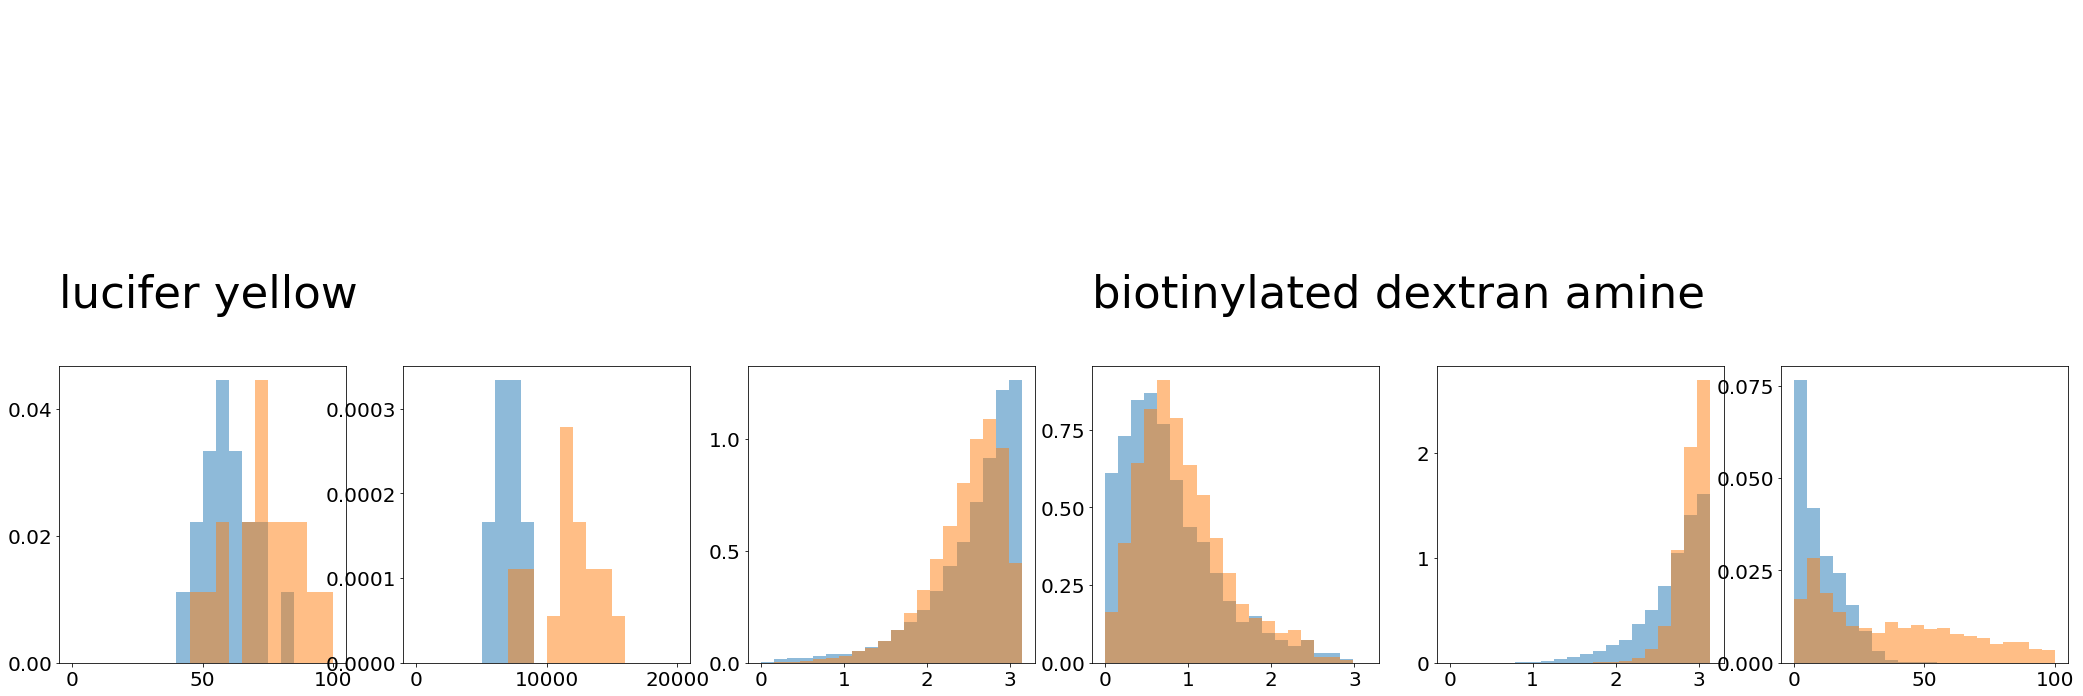

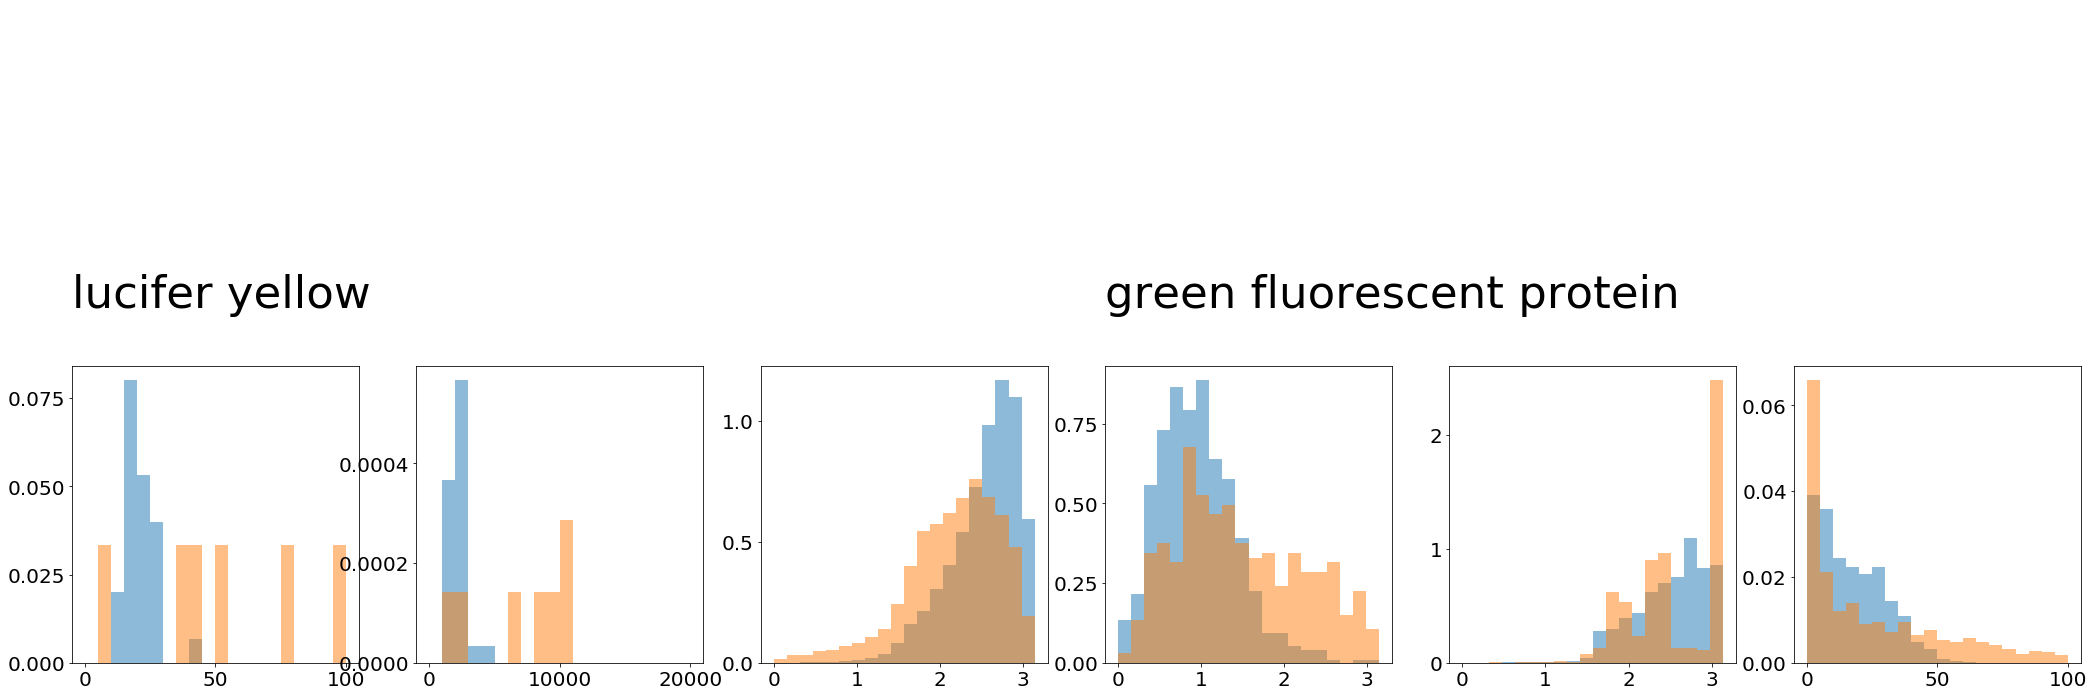

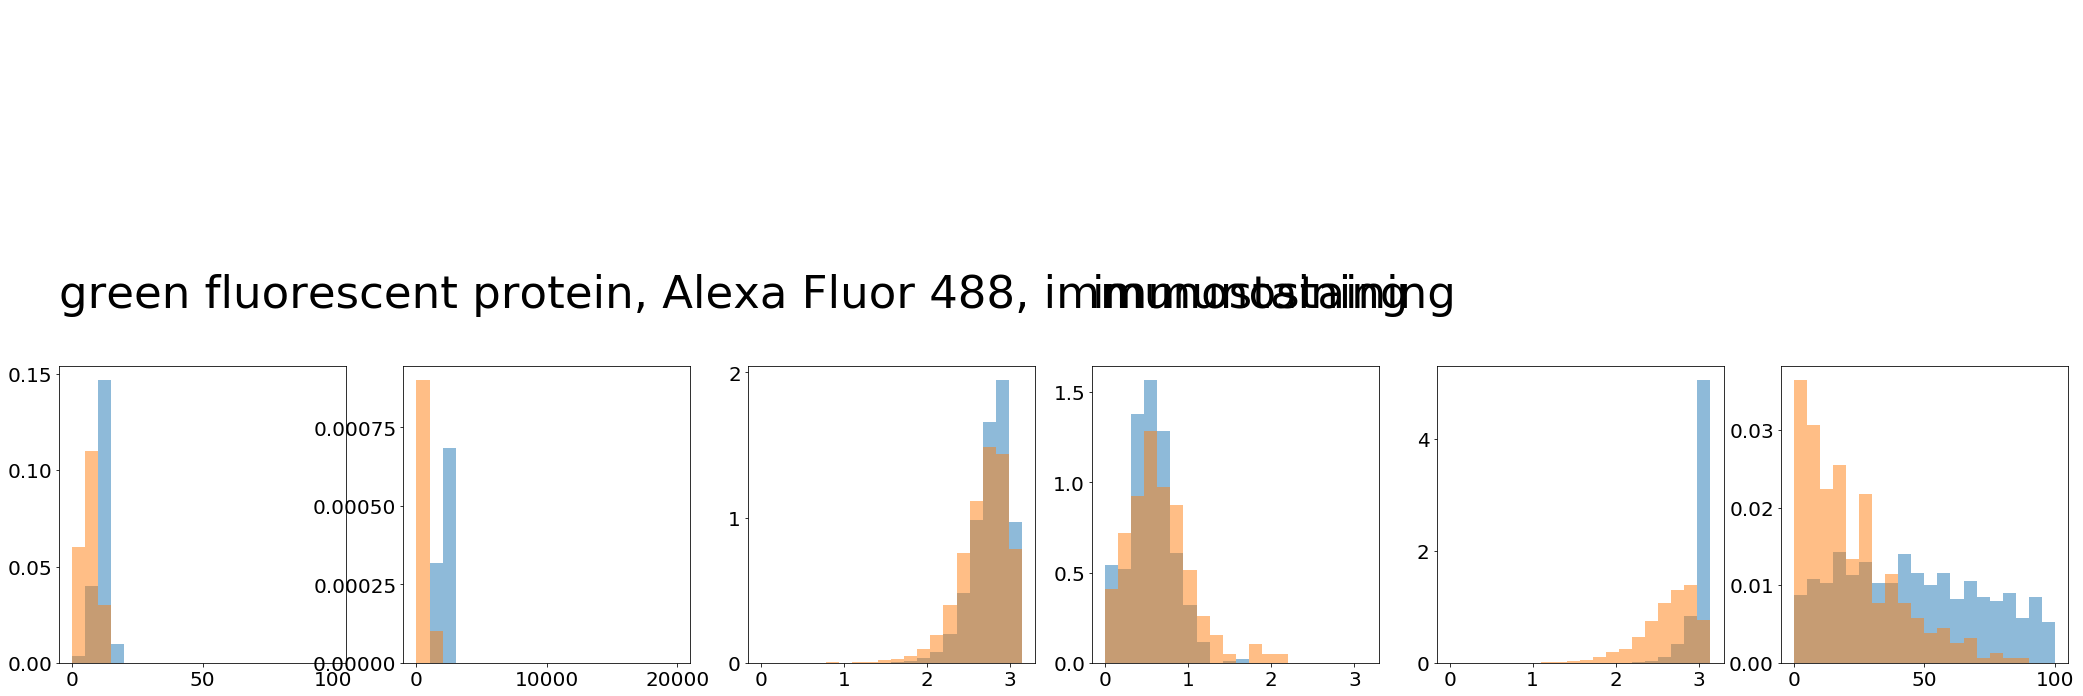

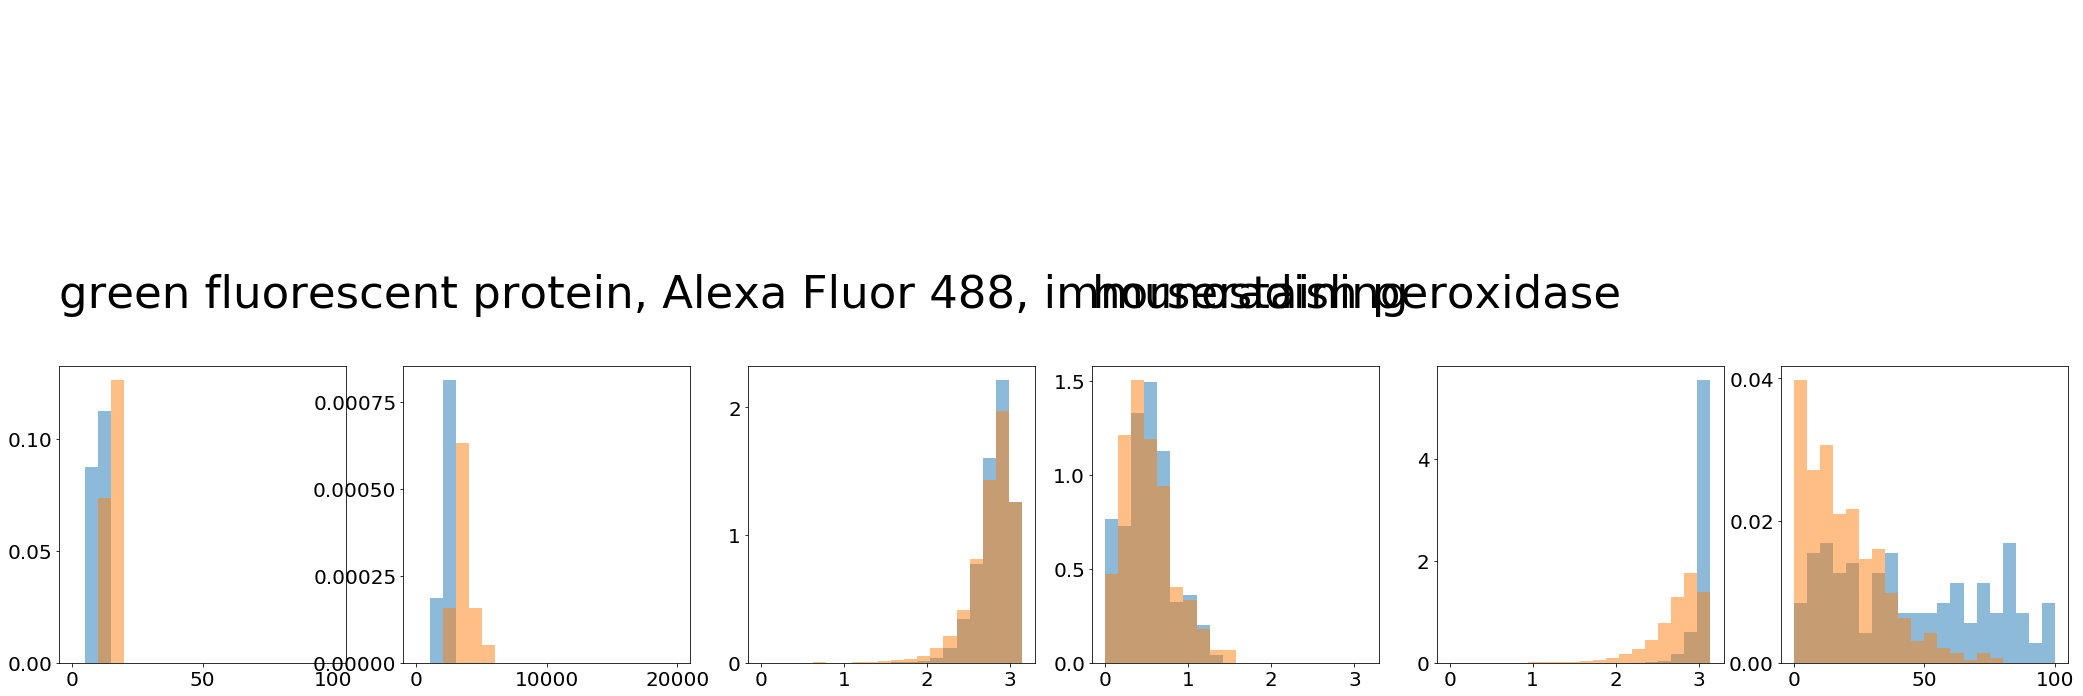

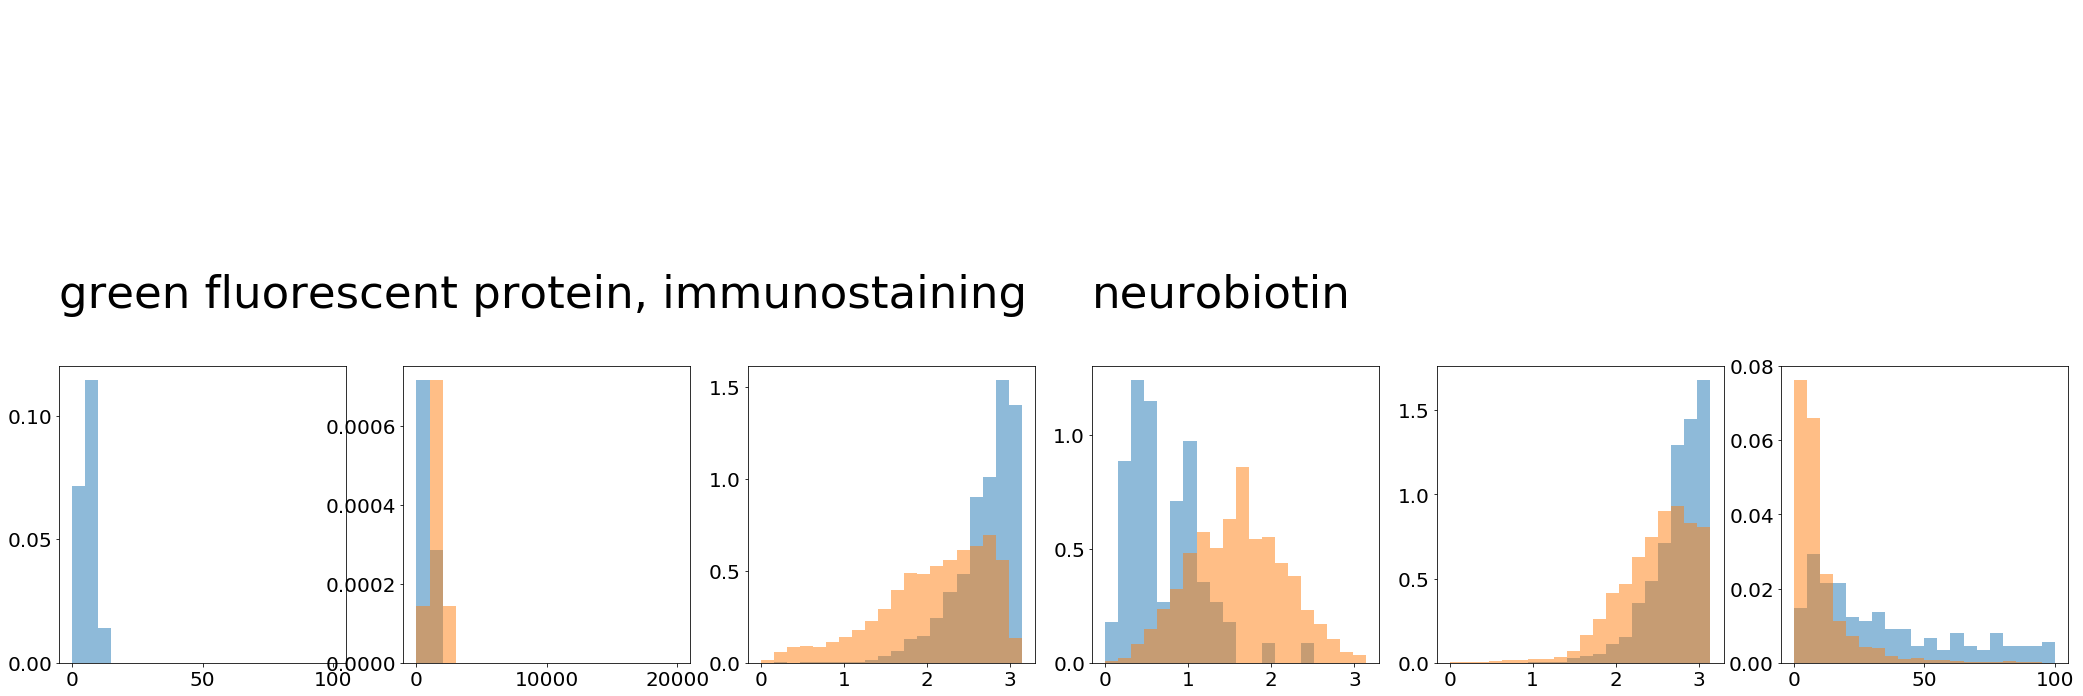

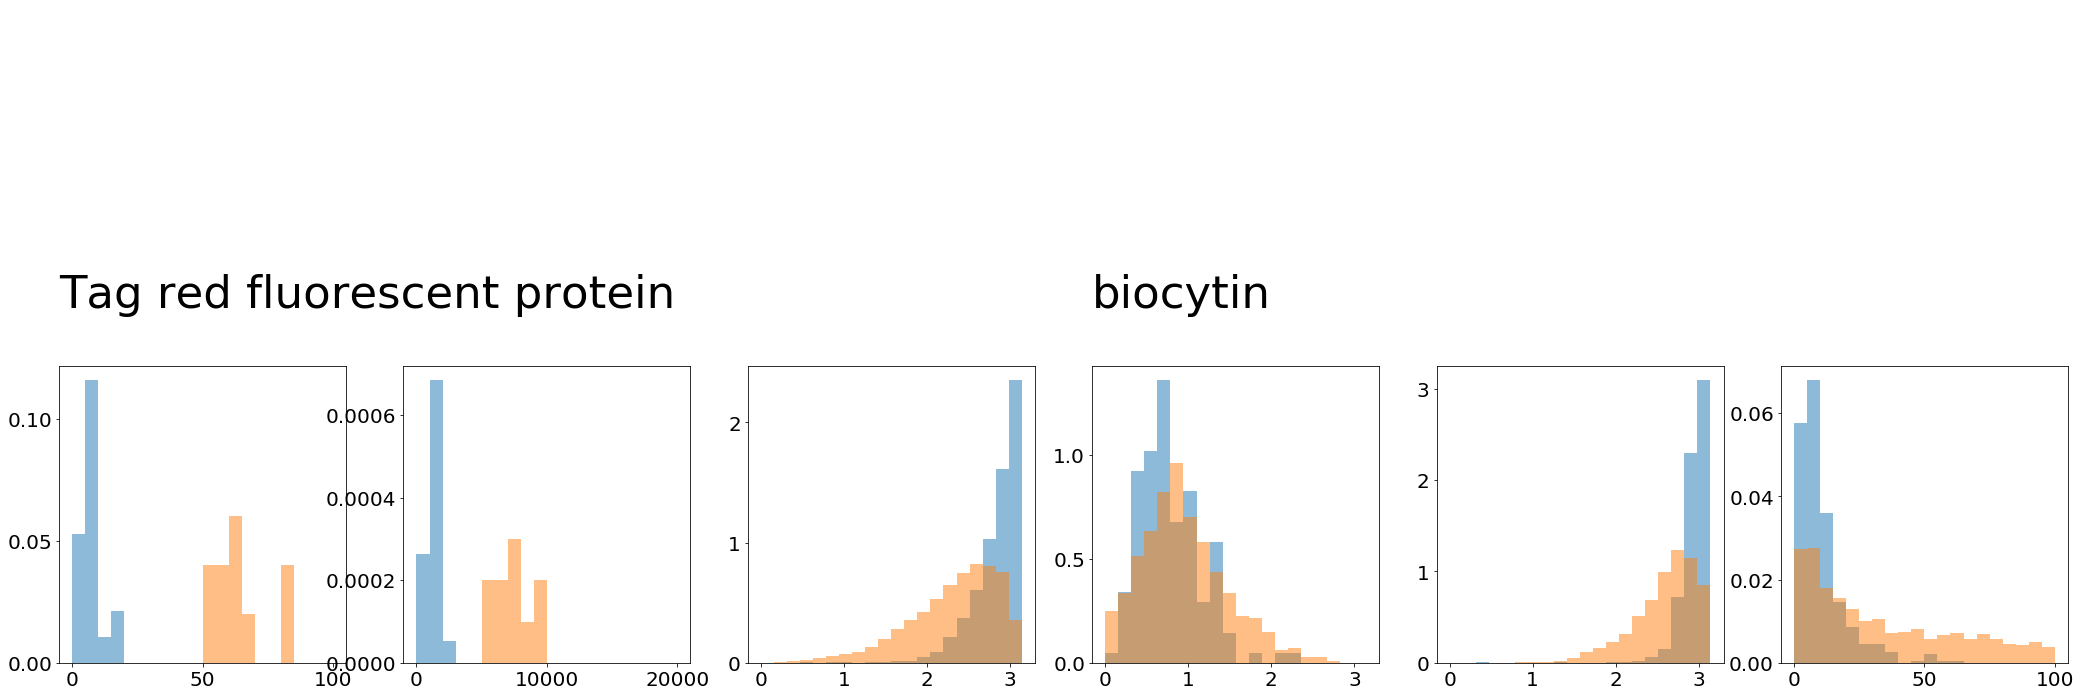

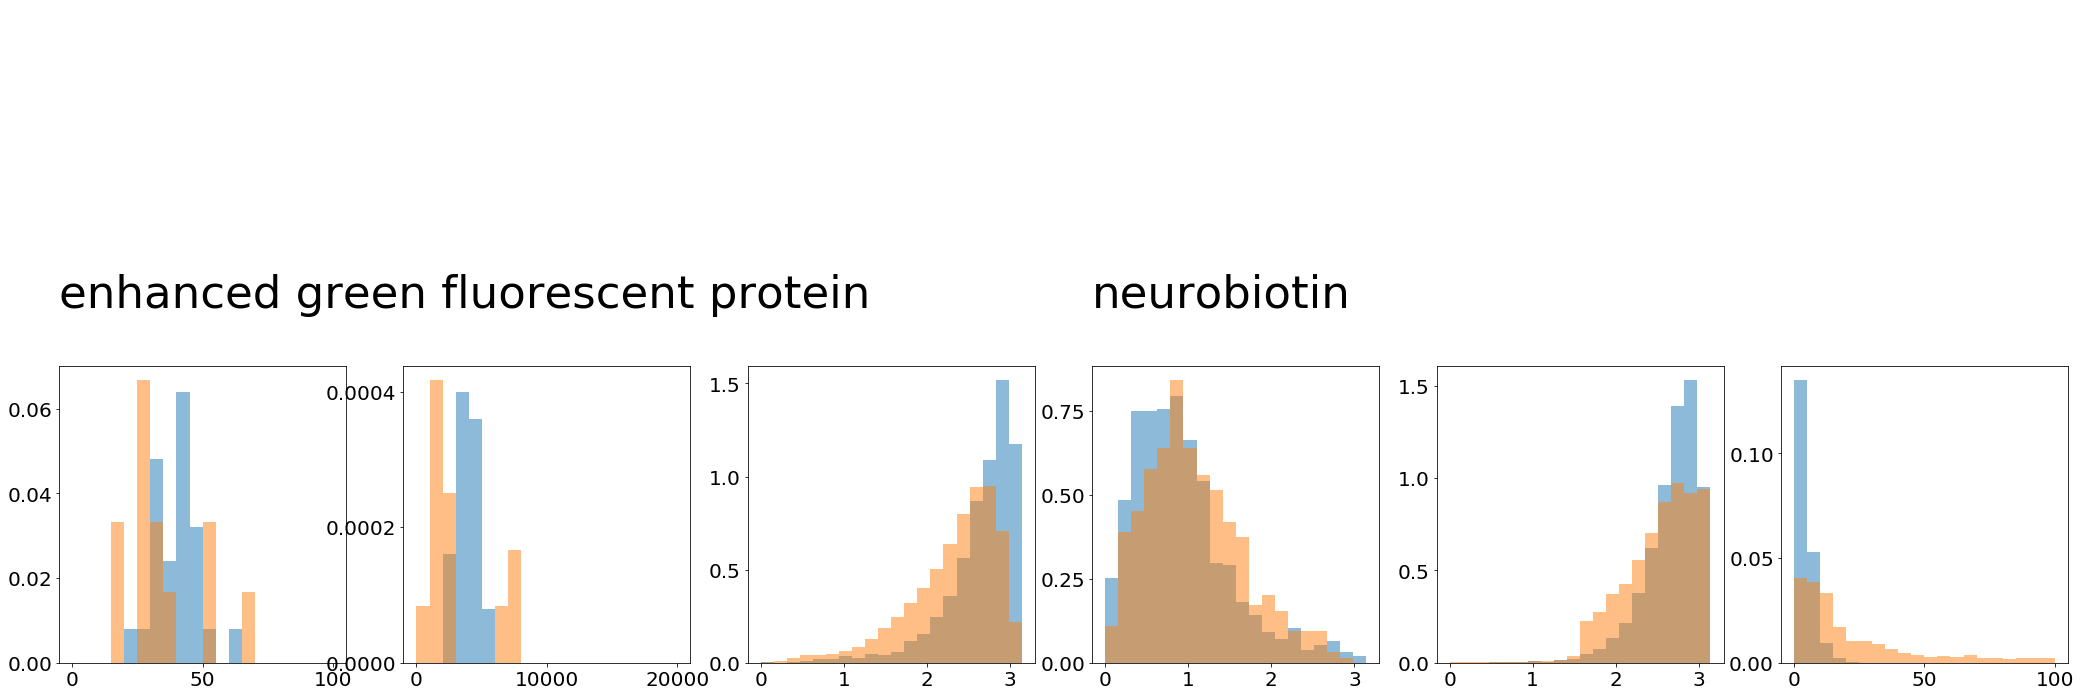

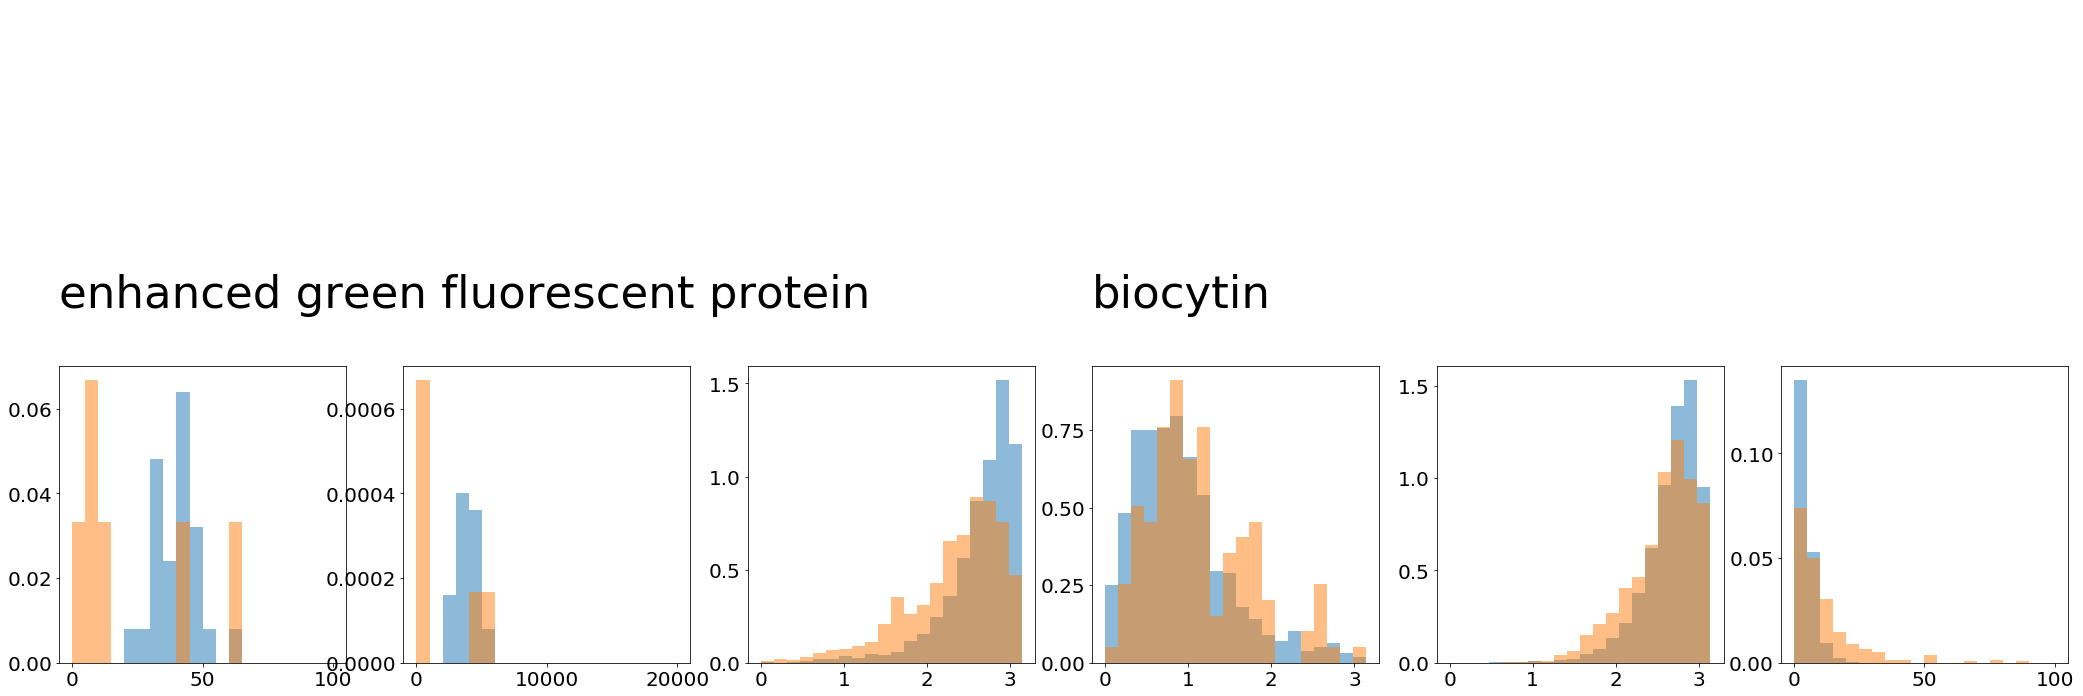

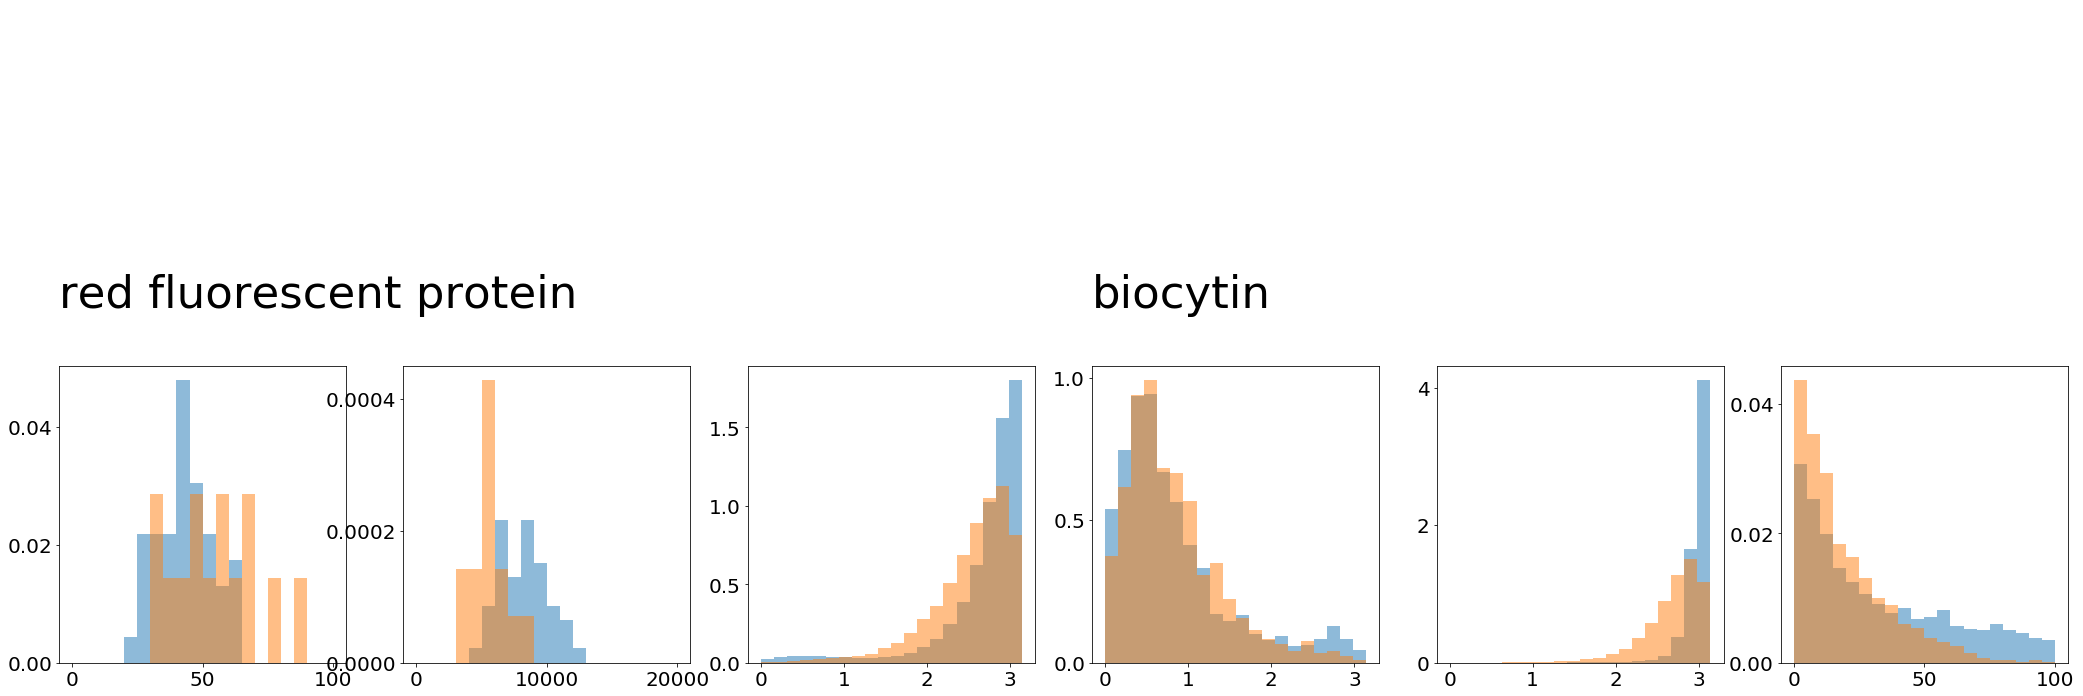

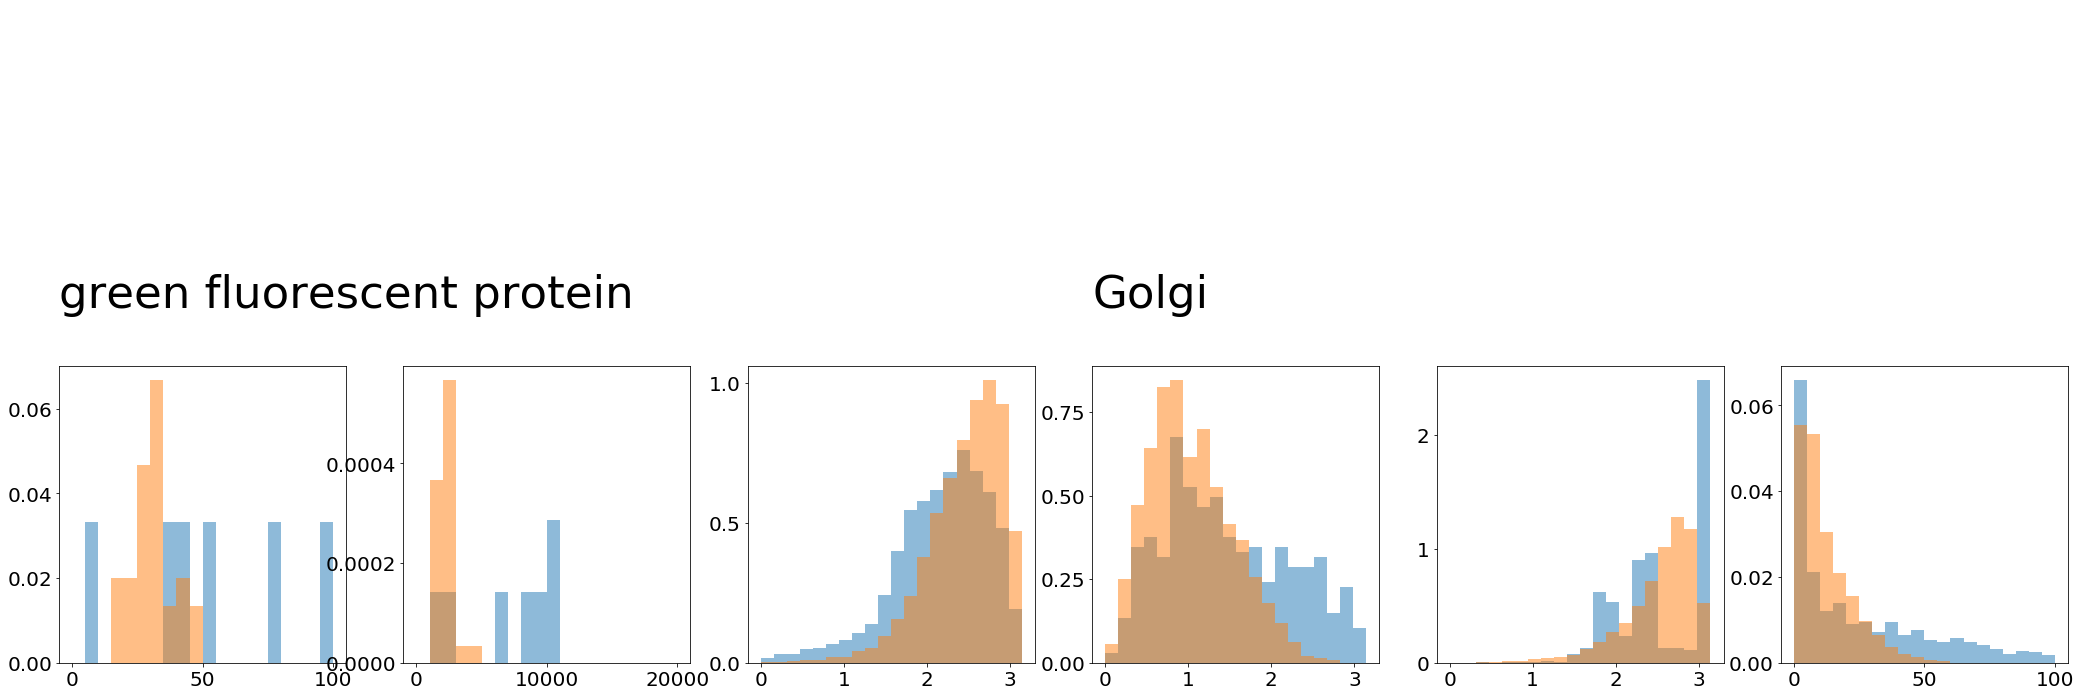

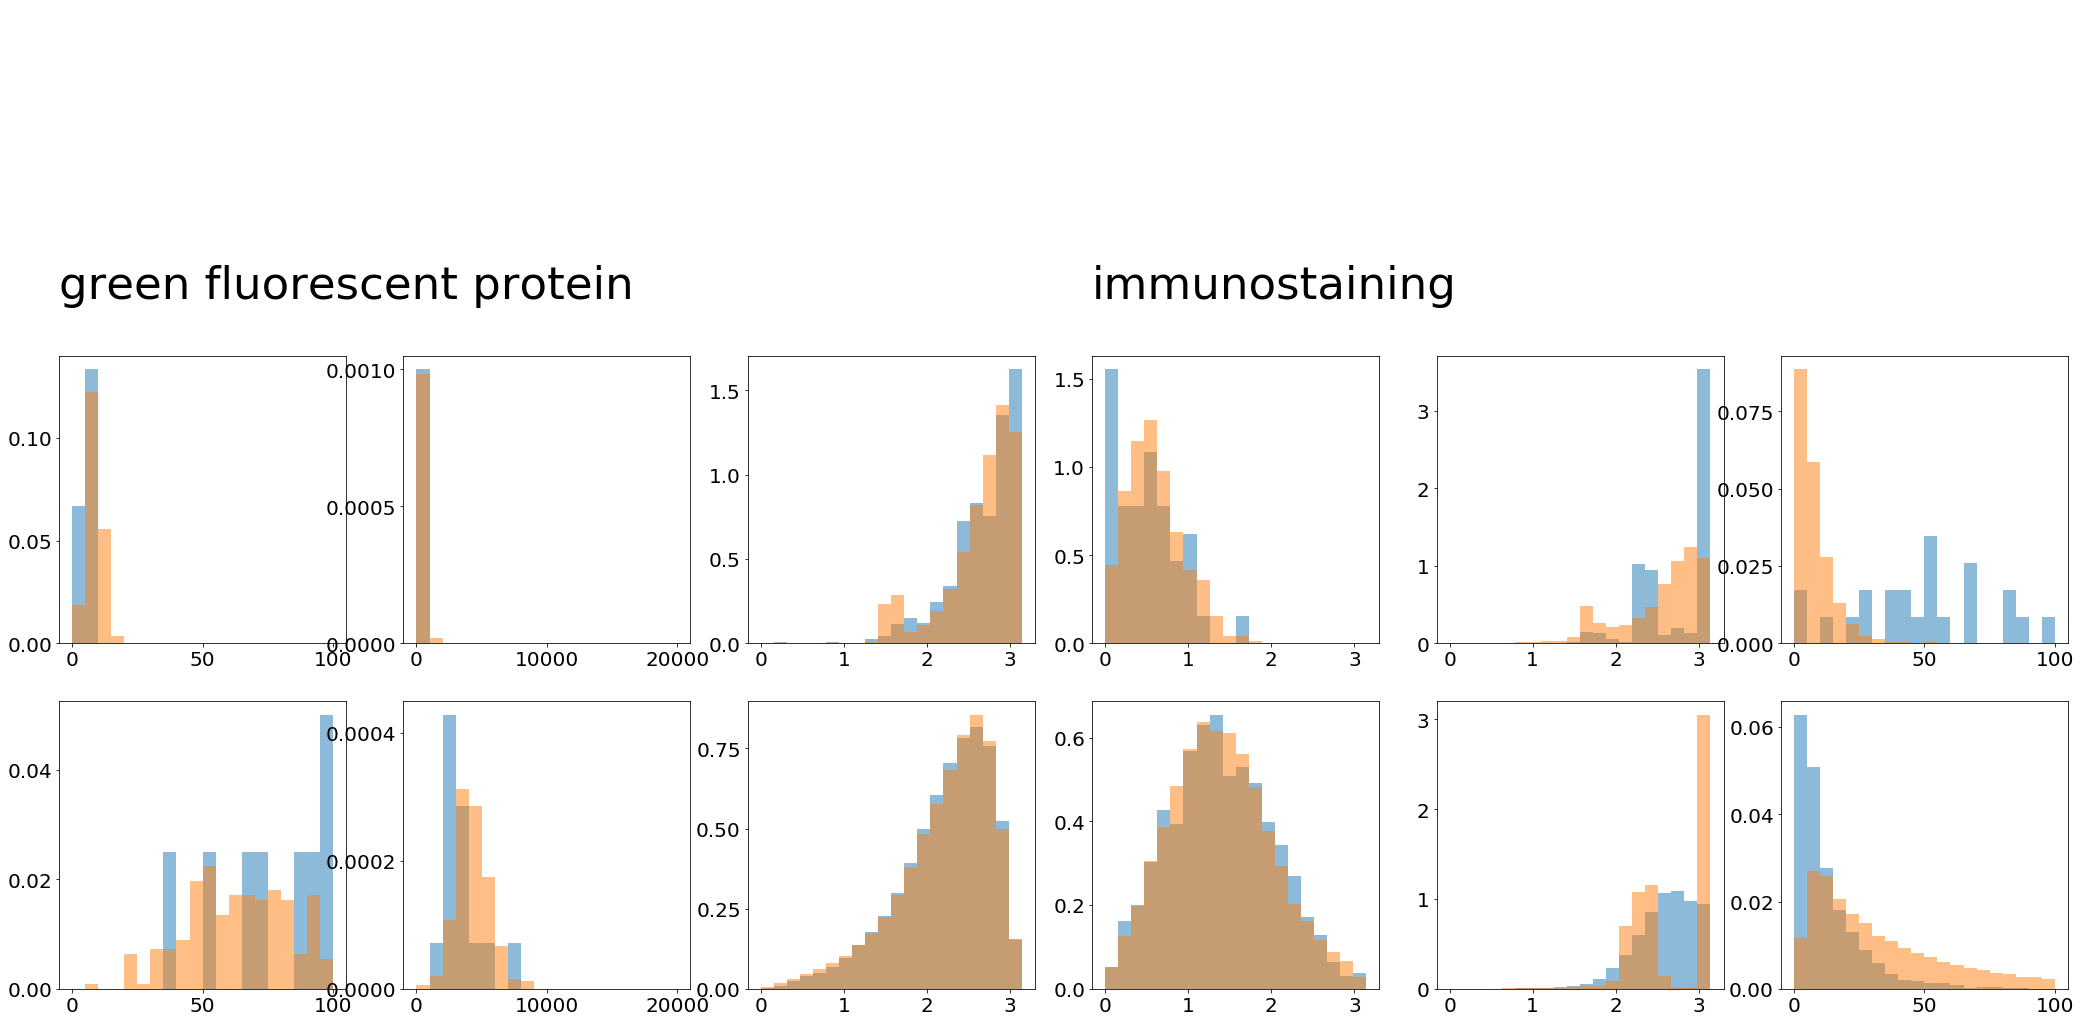

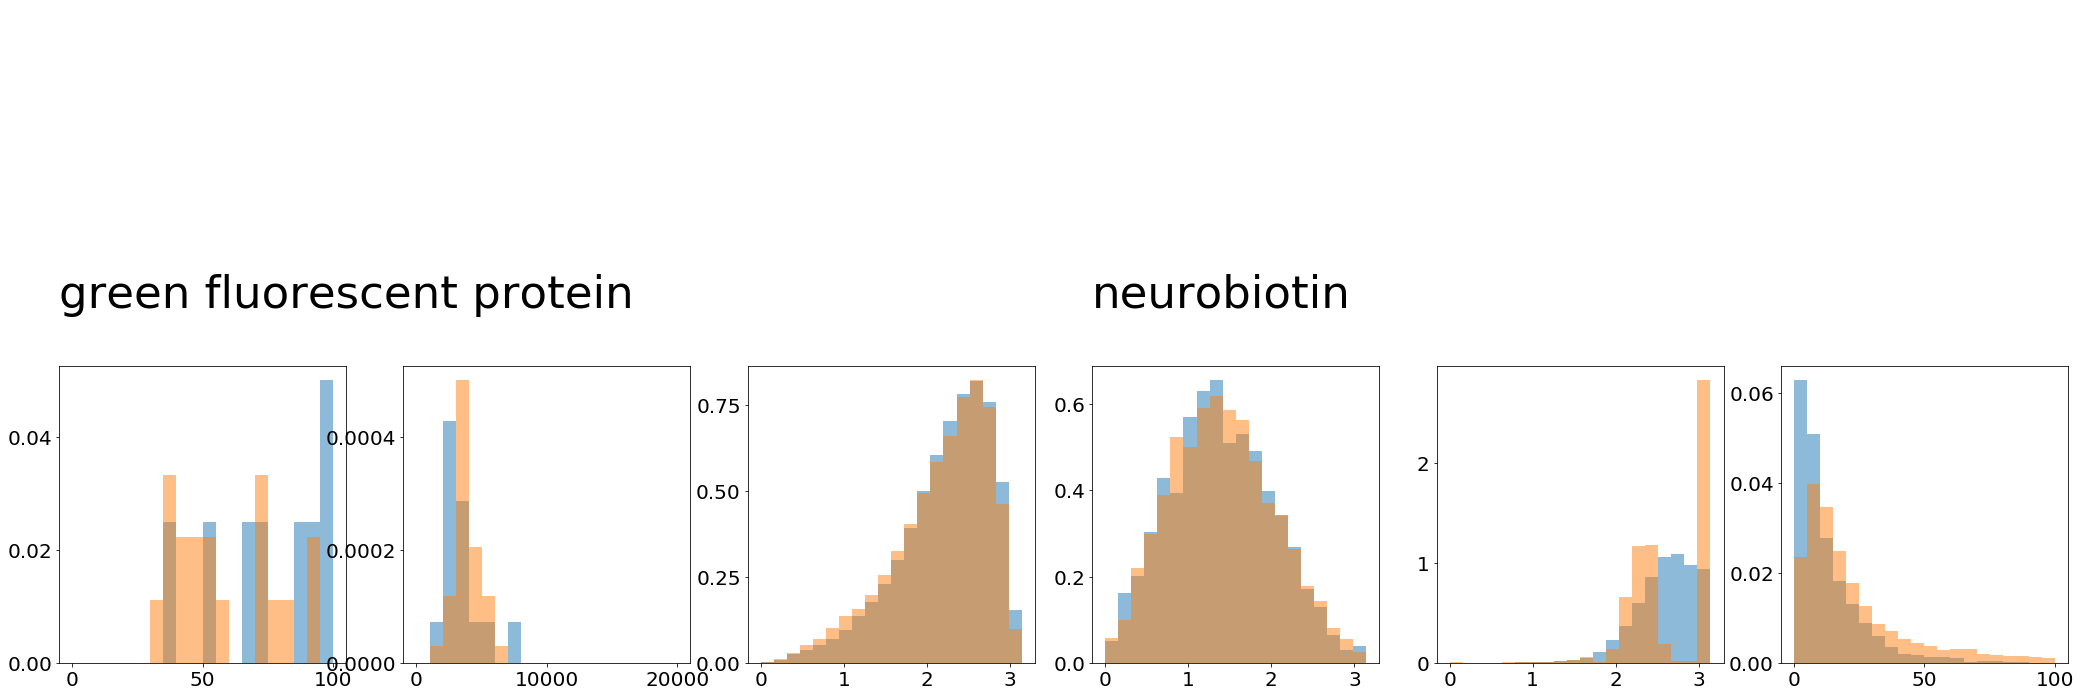

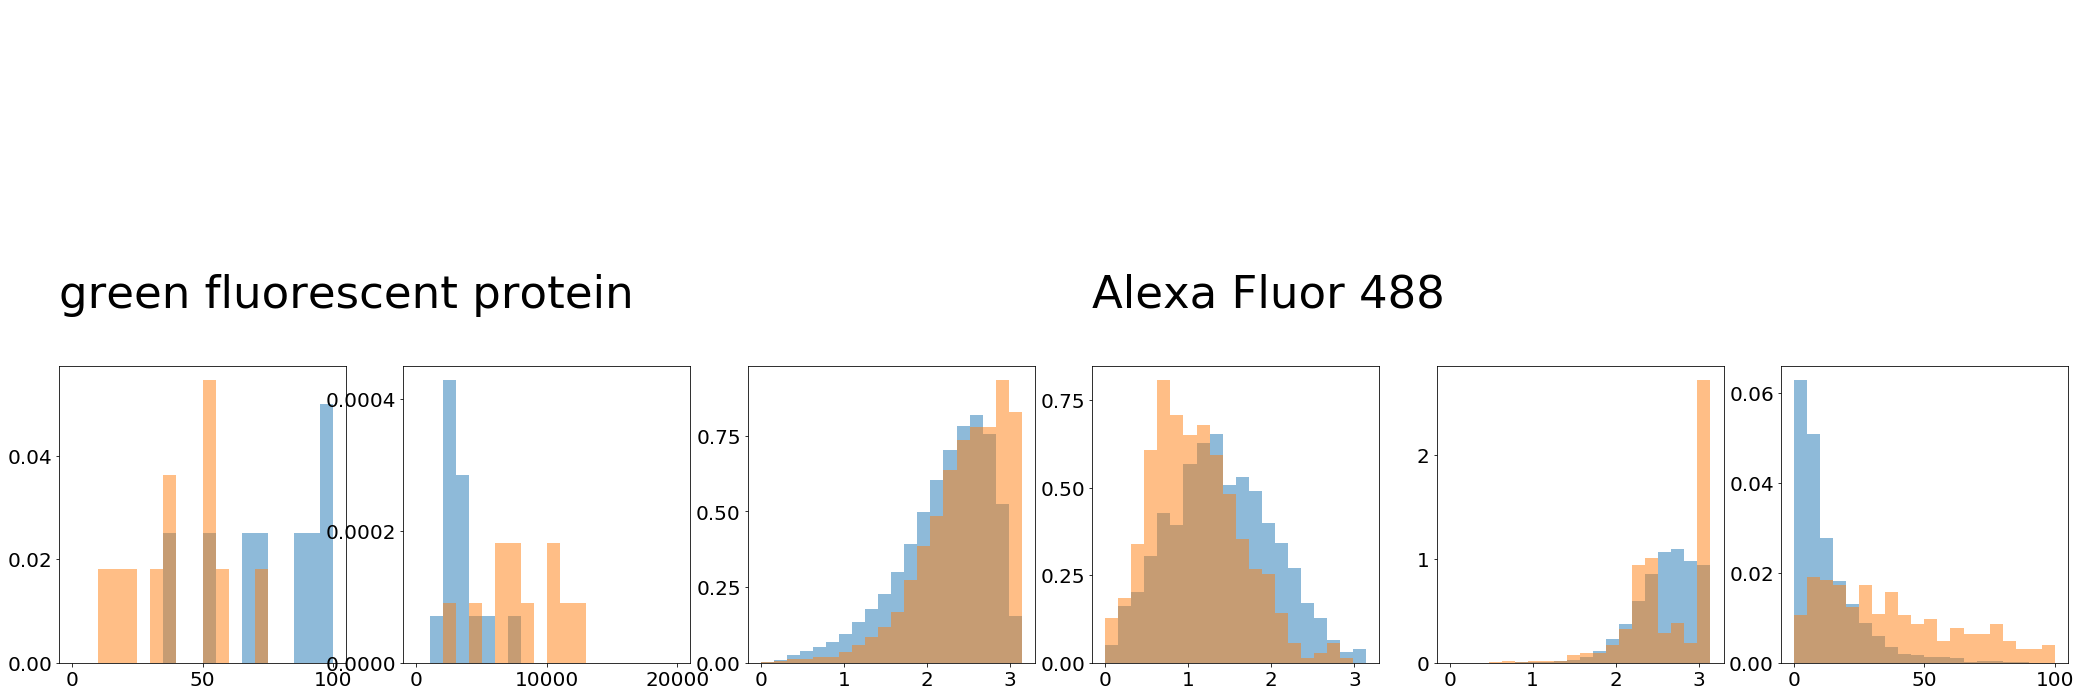

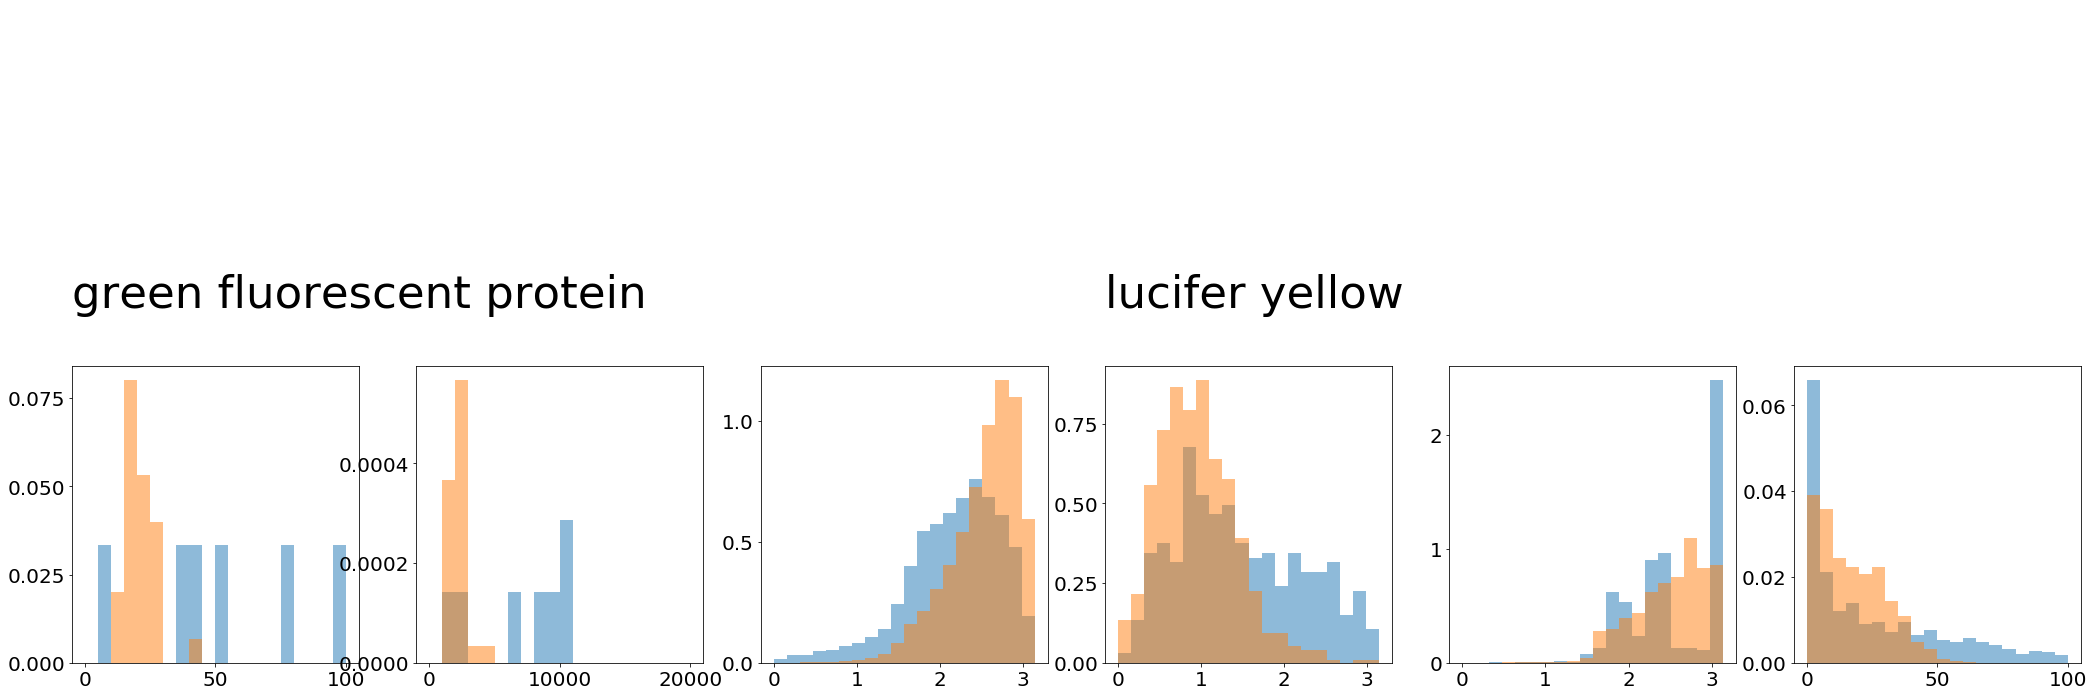

In [15]:
def pool_features(feature_matrix, 
                  feature_name,
                  indices):
    """
    Pull the values of a morphological feature for all the neurons in the group.
    
    Parameters:
    -----------
    feature_matrix: dataframe
        Rows are samples (neurons) and columns are metadata/features of samples
        
    feature_name: str
        name of the feature
    
    indices: list
        list of indices of neurons in feature_matrix
    
    Returns:
    --------
    values_in_features: numpy
        all the values of given features for all neurons of the indices.
    """
    if feature_name=='Number of branching (dendrite)' or \
    feature_name=='Total Length (dendrite)':
        values_in_features = np.array(feature_matrix.iloc[indices][feature_name])
    else:
        values_in_features = \
        np.concatenate(feature_matrix.iloc[indices][feature_name].values)
    return values_in_features


def plot_all_hist(feature_matrix,                      
                  feature_names,
                  ranges,
                  indices_of_regions,
                  val1,
                  val2,
                  label='stain'):
    """

    
    """

    
    n_regions = len(indices_of_regions)    
    comparing_regions = []
    for r in range(n_regions):
        index = indices_of_regions[r]
        index_1 = \
        index[np.where(feature_matrix.iloc[index][label]==\
                 val1)[0]]
        index_2 = \
        index[np.where(feature_matrix.iloc[index][label]==\
                 val2)[0]]
     
        if len(index_2) > 0 and len(index_1)> 0:
            comparing_regions.append(r)
    
    if(len(comparing_regions)>0):
        fig, axes = plt.subplots(len(comparing_regions)+1, 
                                 len(feature_names),
                            figsize=(6*(len(feature_names)), 
                                     6*(len(comparing_regions)+1))) 
        for i in range(len(feature_names)):
            #axes[0, i].text(0, 0, feature_names[i], dict(size=15))
            axes[0, i].axis('off')
        axes[0, 0].text(0, 0, val1, dict(size=45))
        axes[0, 3].text(0, 0, val2, dict(size=45))
        count = 1           
        for r in comparing_regions:
            index = indices_of_regions[r]
            index_1 = \
            index[np.where(feature_matrix.iloc[index][label]==\
                     val1)[0]]
            index_2 = \
            index[np.where(feature_matrix.iloc[index][label]==\
                     val2)[0]]
            for i in range(len(feature_names)):
                #print(r)
                feature_val_1 = pool_features(feature_matrix, 
                                               feature_names[i],
                                               index_1)
                axes[count, i].hist(feature_val_1, 
                                    range=ranges[i],
                                    bins=20,
                     normed=True,
                     alpha=0.5)
                feature_val_2 = pool_features(feature_matrix, 
                                               feature_names[i],
                                               index_2)
                axes[count, i].hist(feature_val_2,
                                    range=ranges[i],
                                    bins=20,
                     normed=True,
                     alpha=0.5)
                axes[count, i].locator_params(nbins=4)
                for tick in axes[count, i].xaxis.get_major_ticks():
                    tick.label.set_fontsize(20) 
                for tick in axes[count, i].yaxis.get_major_ticks():
                    tick.label.set_fontsize(20) 

            count += 1

feature_names = ['Number of branching (dendrite)',
                'Total Length (dendrite)',
                'global angle',
                'segmental branch angle',
                'local angle',
                'segmental neural length']

ranges = [(0, 100),(0, 20000), (0, np.pi),(0, np.pi), (0, np.pi),(0, 100)]

for i in list_all_staining_refined:
    for j in list_all_staining_refined:
        if i!=j:
            plot_all_hist(feature_matrix=neuron_with_features,                      
                      feature_names=feature_names,
                      ranges=ranges,
                      indices_of_regions=all_groups,
                      val1=i,
                      val2=j,
                      label='stain')
#plt.savefig('histogram_rats.eps')

Now we merge the matrix with the features of the neurons with neuromorpho matrix to get access to both labels.

# Treatment effect
The function to compute the treatment effects:

In [16]:
def is_significant(value, shuffle):
    """
    Retrun the significant value (p-value) of one value relative to
    a set of samples, assuming gussian distribution.
    
    Parameters:
    -----------
    value: float
        value to measure its significant
        
    shuffle: numpy array
        A set of samples
        
    Returns:
    --------
    significant: float
        a vlaue in [0, 1]; 1 means the value is coming from shuffle
        and 0 zeros means otherwise.
    """
    above = float(sum(shuffle>np.abs(value)))/float(len(shuffle))  
    below = float(sum(shuffle<-np.abs(value)))/float(len(shuffle))  
    return above + below


def treatment_effects(feature_matrix,                      
                      feature_name,
                      indices_of_regions,
                      n_shuffles,
                      val1,
                      val2,
                      label='stain'):
    """   
    Return the treatment effect for two different values of the labels.
    
    Parameters:
    -----------
    feature_matrix: dataframe
        Rows are samples (neurons) and columns are metadata/features of samples
    
    feature_name:
        name of one of the feature_matrix's colums.
        
    indices_of_regions: list
        Each element of the list is an array of indcies that indicate
        one gourp of regions to be compared for two different labels.
        
    n_shuffles: int
        number of times that the data should be shuffled to find
        the confidence interval.
    
    label: str
        the label that the treatment effect is computing based upon. For the staining
        methods, simply write label='stain'
    
    val1, val2: str
        the valuse of the labels. For example in the case of staining methods
        we can write: val1='Golgi', val2='Golgi-Cox'
    
    
    Returns:
    --------
    wilcoxson: numpy array
        the output of wilcoxson test for each brain regions, i.e. the 
        size of array is the same as the size of the brain regions.
    
    f_in_all_regions: float
        the score for the wilcoson test when the output for 
        all the brian regions are weighted by the number of samples in the regions.
    
    
    f_in_all_regions_baseline: numpy array of length n_shuffles
        each element in this array is the result of shuffling of the brain regions. 
        
    """
    treatment_effect = []
    treatment_effect_baseline = []
    n_regions = len(indices_of_regions)
    f_in_all_regions_baseline = np.zeros([n_regions, n_shuffles])
    
    f_in_region = np.zeros(n_regions)
    n_neurons = np.zeros(n_regions)
    wilcoxson = np.nan*np.zeros(n_regions)
    for r in range(n_regions):
        index = indices_of_regions[r]
        index_1 = \
        index[np.where(feature_matrix.iloc[index][label]==\
                 val1)[0]]
        index_2 = \
        index[np.where(feature_matrix.iloc[index][label]==\
                 val2)[0]]
     
        if len(index_2) > 0 and len(index_1)> 0:
            n_neurons[r] = len(index_2) + len(index_1)
            feature_val_1 = pool_features(feature_matrix, 
                                               feature_name,
                                               index_1)
            feature_val_2 = pool_features(feature_matrix, 
                                               feature_name,
                                               index_2)
            f_in_region[r] = \
                np.mean(feature_val_1) - np.mean(feature_val_2)
            wilcoxson[r] = \
        stats.mannwhitneyu(feature_val_1, feature_val_2).pvalue
            # SHUFFLING 
            for shuff in range(n_shuffles):
                contac = np.append(feature_val_1,
                                   feature_val_2)
                np.random.shuffle(contac)
                f_in_all_regions_baseline[r, shuff] = \
                np.mean(contac[:len(index_1)]) -\
                np.mean(contac[len(index_1):])
    if sum(n_neurons)==0:
        return np.nan, np.nan, np.nan
    else:
        n_neurons = n_neurons/sum(n_neurons)
        f_in_all_regions = np.sum(f_in_region*n_neurons)  
        f_in_all_regions_baseline = \
        np.dot(np.expand_dims(n_neurons,1), 
               np.ones([1,n_shuffles]))*f_in_all_regions_baseline
        f_in_all_regions_baseline = np.sum(f_in_all_regions_baseline,
                                           axis=0)

        return wilcoxson, f_in_all_regions, f_in_all_regions_baseline

def treatment_effect_accumulate(feature_matrix, 
                                indices_of_regions,
                                feature_names,
                                staining_list,
                                n_shuffles,
                                n_regions):
    """   
    Return the treatment effect for all the pairs of staining methods.
    
    Parameters:
    -----------
    feature_matrix: dataframe
        Rows are samples (neurons) and columns are metadata/features of samples

    indices_of_regions: list
        Each element of the list is an array of indcies that indicate
        one gourp of regions to be compared for two different labels.
        
    feature_name:
        name of one of the feature_matrix's colums.
        
    staining_list: list
        list of ll staining methods.
        
    n_shuffles: int
        number of times that the data should be shuffled to find
        the confidence interval.
    
    n_regions: int
        number of regions to be compared.
    
    val1, val2: str
        the valuse of the labels. For example in the case of staining methods
        we can write: val1='Golgi', val2='Golgi-Cox'
    
    
    Returns:
    --------
    treatment_effect_significant: numpy array 
        Its shape is shape l*l where l is the number of staining methods
        and (i,j) value is the significance of treatment effect corresponding 
        staining methods.
    
    f_in_all_regions: numpy array
        the values of wilcoxon for all the regions
    
    
    f_in_all_regions_baseline: numpy array
        the baseline values of wilcoxon for all the regions
        
    """
    n_stain = len(staining_list)
    n_features = len(feature_names)
    treatment_effect_significant = np.nan*np.zeros([n_features, n_stain, n_stain])
    treatment_effect_mag = np.nan*np.zeros([n_features, n_stain, n_stain])
    wilcoxson_all = np.nan*np.zeros([n_features, n_stain, n_stain, n_regions])
    for f in range(n_features):
        for s1 in range(n_stain):
            for s2 in range(n_stain):
                wilcoxson, f_in_all_regions, f_in_all_regions_baseline = \
                treatment_effects(feature_matrix=feature_matrix,                      
                    feature_name=feature_names[f],
                    indices_of_regions=indices_of_regions,
                    n_shuffles=n_shuffles,
                    val1=staining_list[s1],
                    val2=staining_list[s2])
                if np.isnan(f_in_all_regions)==False:
                    treatment_effect_significant[f, s1, s2] = \
                    is_significant(f_in_all_regions, 
                                   f_in_all_regions_baseline)
                    treatment_effect_mag[f, s1, s2] = f_in_all_regions
                    wilcoxson_all[f,s1,s2,:] = wilcoxson
    for i in range(n_stain):
        treatment_effect_significant[:,i,i] = np.nan
        treatment_effect_mag[:,i,i] = np.nan
    return treatment_effect_significant, treatment_effect_mag, wilcoxson_all

# just one example for the wilcoxon matrix    
wilcoxson, f_in_all_regions, f_in_all_regions_baseline \
    = treatment_effects(feature_matrix=neuron_with_features,                      
                      feature_name='Number of branching (dendrite)',
                      indices_of_regions=all_groups,
                      n_shuffles=100,
                      val1='neurobiotin',
                      val2='Alexa Fluor 488',
                      label='stain')

Computing the treatment effect

In [17]:
feature_names = ['Total Length (dendrite)',
                 'Number of branching (dendrite)', 
                 'global angle',
                 'local angle',
                 'segmental branch angle', 
                 'segmental neural length']

treatment_effect_significant, treatment_effect_mag, wilcoxson_all = \
treatment_effect_accumulate(feature_matrix=neuron_with_features, 
                            indices_of_regions=all_groups,
                            feature_names=feature_names,
                            staining_list=list_all_staining_refined,
                            n_shuffles=100, 
                            n_regions=len(all_groups))

## Figure 3
Proportion of significant differences between pairs of staining methods over all groups and morphological features.

significant_value=.05


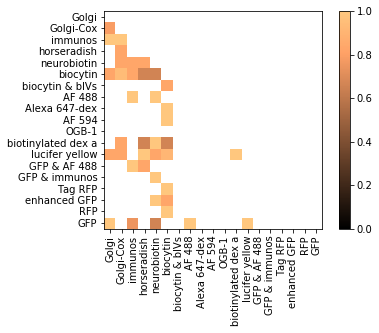

significant_value=.001


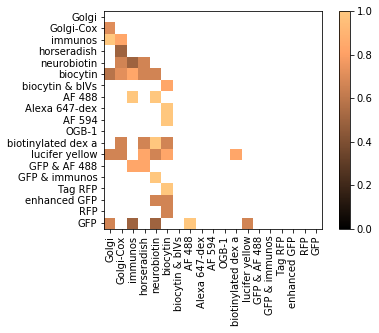

In [18]:
def plot_significant_wilcoxon(list_all_staining_refined, 
                             wilcoxson_all, 
                             significant_value=.05):
    n  = len(list_all_staining_refined)
    wil = np.nan*np.ones([n,n])
    for stain1 in range(n):
        for stain2 in range(n):
            if (stain1<stain2):
                a = np.squeeze(wilcoxson_all[:,stain1, stain2, :])
                vals = a[~np.isnan(a)]
                if len(vals)>0:
                    wil[stain2, stain1] = \
                        float(sum(vals<significant_value))/float(len(vals))
    colorsu = plt.get_cmap('copper')
    colorsu.set_bad('w')
    n = wil.shape[1]
    a = plt.imshow(wil, 
           cmap=colorsu)
    a.set_clim(0,1)
    plt.colorbar();
    plt.xticks(range(wil.shape[0]), list_all_staining_refined_name, rotation=90);
    plt.yticks(range(wil.shape[0]), list_all_staining_refined_name, rotation=0);
    plt.show()

print("significant_value=.05")
plot_significant_wilcoxon(list_all_staining_refined, 
                            wilcoxson_all, 
                         significant_value=.05)

print("significant_value=.001")
plot_significant_wilcoxon(list_all_staining_refined, 
                            wilcoxson_all, 
                         significant_value=.001)
#plt.savefig('significant_wilcoxon.eps')

## Figure 4 

treatment effect significant for feature: Total Length (dendrite)


/opt/anaconda/miniconda2/envs/py34/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/opt/anaconda/miniconda2/envs/py34/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less_equal
/opt/anaconda/miniconda2/envs/py34/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater_equal
/opt/anaconda/miniconda2/envs/py34/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in less


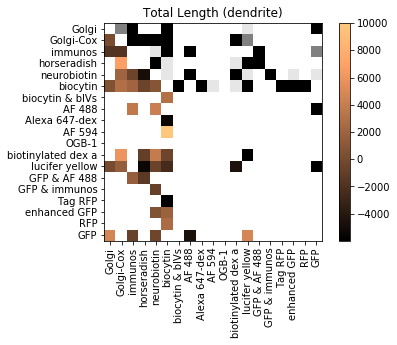

treatment effect significant for feature: Number of branching (dendrite)


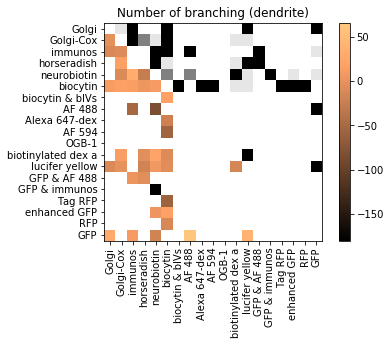

treatment effect significant for feature: global angle


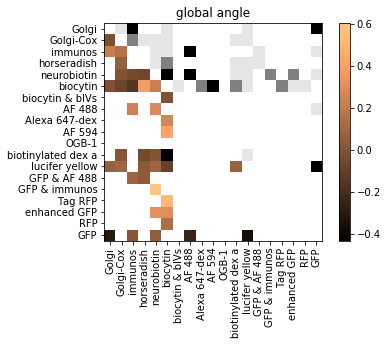

treatment effect significant for feature: local angle


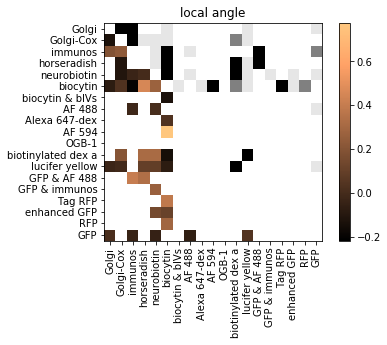

treatment effect significant for feature: segmental branch angle


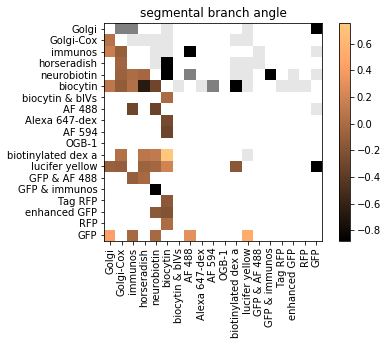

treatment effect significant for feature: segmental neural length


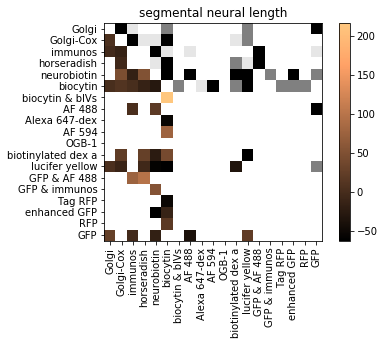

In [19]:
def plot_pairwise_averaged_effect(treatment_effect_significant,
                                  feature_names,
                                index_of_feature):
    colorsd = plt.get_cmap('copper')
    colorsd.set_bad(alpha=0.0)

    colorsu = plt.cm.gray
    colorsu.set_bad('w')
    n = treatment_effect_significant.shape[1]

    #for f_ind in range(6): 
    up = deepcopy(np.squeeze(treatment_effect_significant[index_of_feature,:,:]))
    # b = up[~np.isnan(up)]
    # print(len(b))
    # print(sum(b<.05))
    up[up>.05] = .9
    up[np.where(np.logical_and(up<=.05, up>=.001))] = .5
    up[up<.001] = 0
    up[np.tril_indices(n)] = np.nan

    a = plt.imshow(up, 
           cmap=colorsu)
    a.set_clim(0,1)

    down = deepcopy(treatment_effect_mag[index_of_feature,:,:])
    if index_of_feature==0:
        down[9,5] = 10000
    down[np.triu_indices(n)] = np.nan

    plt.imshow(down, 
           cmap=colorsd)
    plt.colorbar();
    #plt.clim(0,1)
    plt.title(feature_names[index_of_feature]);
    plt.xticks(range(down.shape[0]), list_all_staining_refined_name, rotation=90);
    plt.yticks(range(down.shape[0]), list_all_staining_refined_name, rotation=0);
    plt.show()
for i in range(6):
    print('treatment effect significant for feature: '+feature_names[i])
    plot_pairwise_averaged_effect(\
                        treatment_effect_significant=treatment_effect_significant,
                                  feature_names=feature_names,
                        index_of_feature=i)
#plt.savefig('summary'+str(f_ind)+'.eps')